In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
from isaac.dataset import read_dataset, prepare_dataset
from isaac.utils import plot_confusion_matrix
from isaac.models import RNNModel, ComplexRNNModel
from isaac.constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS
from isaac.training import evaluate, training_loop

# MASS TRAINING (Humans achieve 46% +- 29%)

## Read dataset and preprocess it

In [4]:
all_trials = read_dataset("data/passive_trials.h5")
train_loader, val_loader, scaler = prepare_dataset(all_trials, MASS_CLASS_COLS, normalise_data=True, 
                                                   batch_size=128, test_size=0.3, equiprobable_training_classes=True)

In [5]:
Y = []
for x,y in train_loader:
    
    Y.extend(list(y))

counts = np.unique(Y, return_counts=True)[1]

In [6]:
counts

array([144, 144, 144])

In [7]:
print("Majority class: ", np.max(counts) / np.sum(counts))

Majority class:  0.3333333333333333


## Define model, loss and optimizer

In [8]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = len(BASIC_TRAINING_COLS)    # input dimension
first_hidden_dim = 12  # hidden layer dimension
second_hidden_dim = 6     # number of hidden layers
output_dim = 3   # output dimension

model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model and plot loss and accuracy

In [10]:
epoch_losses, epoch_accuracies = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs=1000)

  0%|          | 1/1000 [00:00<11:52,  1.40it/s]

1.0990901291370392 33.101851851851855 25.0


  0%|          | 2/1000 [00:01<11:41,  1.42it/s]

1.0985386967658997 34.02777777777778 25.543478260869566


  0%|          | 3/1000 [00:02<11:36,  1.43it/s]

1.097508192062378 34.49074074074074 26.902173913043477


  0%|          | 4/1000 [00:02<11:31,  1.44it/s]

1.0961609780788422 35.416666666666664 28.804347826086957


  0%|          | 5/1000 [00:03<11:31,  1.44it/s]

1.094732403755188 35.648148148148145 31.793478260869566


  1%|          | 6/1000 [00:04<12:01,  1.38it/s]

1.0933992266654968 35.416666666666664 32.33695652173913


  1%|          | 7/1000 [00:04<11:39,  1.42it/s]

1.0935320258140564 36.80555555555556 34.78260869565217


  1%|          | 8/1000 [00:05<12:01,  1.37it/s]

1.092320442199707 38.657407407407405 36.68478260869565


  1%|          | 9/1000 [00:06<12:34,  1.31it/s]

1.0914068818092346 38.888888888888886 37.77173913043478


  1%|          | 10/1000 [00:07<11:57,  1.38it/s]

1.0903725326061249 40.74074074074074 38.31521739130435


  1%|          | 11/1000 [00:07<11:37,  1.42it/s]

1.0899098813533783 40.27777777777778 39.67391304347826


  1%|          | 12/1000 [00:08<11:56,  1.38it/s]

1.0881576836109161 41.2037037037037 43.47826086956522


  1%|▏         | 13/1000 [00:09<11:36,  1.42it/s]

1.0876241624355316 42.129629629629626 45.65217391304348


  1%|▏         | 14/1000 [00:09<11:33,  1.42it/s]

1.0864095091819763 42.129629629629626 46.46739130434783


  2%|▏         | 15/1000 [00:10<11:38,  1.41it/s]

1.0850942730903625 42.361111111111114 47.55434782608695


  2%|▏         | 16/1000 [00:11<11:40,  1.40it/s]

1.0826814770698547 43.75 48.369565217391305


  2%|▏         | 17/1000 [00:12<11:33,  1.42it/s]

1.0819644629955292 43.51851851851852 48.369565217391305


  2%|▏         | 18/1000 [00:12<11:26,  1.43it/s]

1.0781303346157074 43.28703703703704 50.54347826086956


  2%|▏         | 19/1000 [00:13<11:19,  1.44it/s]

1.0777659118175507 43.98148148148148 51.630434782608695


  2%|▏         | 20/1000 [00:14<11:09,  1.46it/s]

1.075715810060501 44.21296296296296 52.71739130434783


  2%|▏         | 21/1000 [00:14<11:09,  1.46it/s]

1.0747893750667572 43.28703703703704 53.53260869565217


  2%|▏         | 22/1000 [00:15<11:06,  1.47it/s]

1.070994108915329 43.28703703703704 53.53260869565217


  2%|▏         | 23/1000 [00:16<11:02,  1.47it/s]

1.069027304649353 42.824074074074076 53.80434782608695


  2%|▏         | 24/1000 [00:16<11:23,  1.43it/s]

1.0659604370594025 43.51851851851852 54.07608695652174


  2%|▎         | 25/1000 [00:17<11:21,  1.43it/s]

1.0639709681272507 43.75 54.619565217391305


  3%|▎         | 26/1000 [00:18<11:24,  1.42it/s]

1.0598616153001785 43.28703703703704 54.619565217391305


  3%|▎         | 27/1000 [00:18<11:18,  1.44it/s]

1.0596752613782883 43.51851851851852 54.34782608695652


  3%|▎         | 28/1000 [00:19<11:12,  1.45it/s]

1.0559138059616089 43.28703703703704 54.619565217391305


  3%|▎         | 29/1000 [00:20<11:17,  1.43it/s]

1.0520517379045486 43.28703703703704 54.07608695652174


  3%|▎         | 30/1000 [00:21<11:16,  1.43it/s]

1.0504901260137558 43.51851851851852 53.80434782608695


  3%|▎         | 31/1000 [00:21<11:15,  1.44it/s]

1.0460462719202042 43.51851851851852 53.26086956521739


  3%|▎         | 32/1000 [00:22<10:56,  1.48it/s]

1.043128177523613 43.98148148148148 53.80434782608695


  3%|▎         | 33/1000 [00:23<11:00,  1.46it/s]

1.0388580858707428 44.675925925925924 54.619565217391305


  3%|▎         | 34/1000 [00:23<10:55,  1.47it/s]

1.0364380925893784 44.21296296296296 54.619565217391305


  4%|▎         | 35/1000 [00:24<10:45,  1.50it/s]

1.0325206220149994 45.138888888888886 54.619565217391305


  4%|▎         | 36/1000 [00:25<10:48,  1.49it/s]

1.0294664204120636 44.907407407407405 54.891304347826086


  4%|▎         | 37/1000 [00:25<11:06,  1.44it/s]

1.026112213730812 45.370370370370374 54.619565217391305


  4%|▍         | 38/1000 [00:26<11:01,  1.45it/s]

1.0217559188604355 46.2962962962963 54.891304347826086


  4%|▍         | 39/1000 [00:27<11:23,  1.41it/s]

1.016344502568245 46.52777777777778 55.16304347826087


  4%|▍         | 40/1000 [00:28<11:30,  1.39it/s]

1.011131376028061 46.75925925925926 54.891304347826086


  4%|▍         | 41/1000 [00:28<11:53,  1.34it/s]

1.0065898597240448 47.68518518518518 54.07608695652174


  4%|▍         | 42/1000 [00:29<11:54,  1.34it/s]

1.001694068312645 48.379629629629626 53.53260869565217


  4%|▍         | 43/1000 [00:30<12:23,  1.29it/s]

0.9983195513486862 48.379629629629626 53.26086956521739


  4%|▍         | 44/1000 [00:31<12:47,  1.25it/s]

0.9881610423326492 48.611111111111114 52.98913043478261


  4%|▍         | 45/1000 [00:32<13:03,  1.22it/s]

0.9849268049001694 49.53703703703704 52.98913043478261


  5%|▍         | 46/1000 [00:33<13:14,  1.20it/s]

0.9767539948225021 49.53703703703704 52.44565217391305


  5%|▍         | 47/1000 [00:33<12:49,  1.24it/s]

0.9696420878171921 50.23148148148148 52.17391304347826


  5%|▍         | 48/1000 [00:34<13:01,  1.22it/s]

0.9667656421661377 51.620370370370374 52.44565217391305


  5%|▍         | 49/1000 [00:35<13:08,  1.21it/s]

0.9595265239477158 52.31481481481482 50.81521739130435


  5%|▌         | 50/1000 [00:36<13:15,  1.19it/s]

0.9564420729875565 53.24074074074074 51.630434782608695


  5%|▌         | 51/1000 [00:37<13:20,  1.18it/s]

0.9445011615753174 53.47222222222222 51.08695652173913


  5%|▌         | 52/1000 [00:38<13:30,  1.17it/s]

0.9389075189828873 53.7037037037037 50.27173913043478


  5%|▌         | 53/1000 [00:38<13:31,  1.17it/s]

0.9372133910655975 54.398148148148145 50.81521739130435


  5%|▌         | 54/1000 [00:39<13:33,  1.16it/s]

0.9280373603105545 55.324074074074076 52.17391304347826


  6%|▌         | 55/1000 [00:40<12:54,  1.22it/s]

0.9243811368942261 56.25 51.358695652173914


  6%|▌         | 56/1000 [00:41<13:03,  1.21it/s]

0.9204279184341431 56.25 51.358695652173914


  6%|▌         | 57/1000 [00:42<12:39,  1.24it/s]

0.9151624888181686 56.71296296296296 51.358695652173914


  6%|▌         | 58/1000 [00:42<11:58,  1.31it/s]

0.9087180197238922 56.94444444444444 51.08695652173913


  6%|▌         | 59/1000 [00:43<12:26,  1.26it/s]

0.8987327963113785 57.407407407407405 51.08695652173913


  6%|▌         | 60/1000 [00:44<12:38,  1.24it/s]

0.8961226791143417 57.870370370370374 51.08695652173913


  6%|▌         | 61/1000 [00:45<12:49,  1.22it/s]

0.8874004185199738 57.870370370370374 50.81521739130435


  6%|▌         | 62/1000 [00:46<12:19,  1.27it/s]

0.8849169015884399 58.101851851851855 50.81521739130435


  6%|▋         | 63/1000 [00:46<11:44,  1.33it/s]

0.8782031089067459 58.7962962962963 51.358695652173914


  6%|▋         | 64/1000 [00:47<11:21,  1.37it/s]

0.8737669438123703 59.25925925925926 51.358695652173914


  6%|▋         | 65/1000 [00:48<11:10,  1.39it/s]

0.8631844818592072 59.72222222222222 51.358695652173914


  7%|▋         | 66/1000 [00:48<10:55,  1.43it/s]

0.8576173186302185 59.9537037037037 50.27173913043478


  7%|▋         | 67/1000 [00:49<10:49,  1.44it/s]

0.8563997894525528 59.9537037037037 51.08695652173913


  7%|▋         | 68/1000 [00:50<10:42,  1.45it/s]

0.8480114340782166 59.9537037037037 50.27173913043478


  7%|▋         | 69/1000 [00:50<10:38,  1.46it/s]

0.8382134884595871 61.111111111111114 50.27173913043478


  7%|▋         | 70/1000 [00:51<10:31,  1.47it/s]

0.8422747999429703 62.5 49.45652173913044


  7%|▋         | 71/1000 [00:52<10:21,  1.49it/s]

0.8306381851434708 62.5 49.72826086956522


  7%|▋         | 72/1000 [00:52<10:19,  1.50it/s]

0.8224521577358246 62.96296296296296 49.45652173913044


  7%|▋         | 73/1000 [00:53<10:17,  1.50it/s]

0.8181037604808807 63.657407407407405 50.0


  7%|▋         | 74/1000 [00:54<10:09,  1.52it/s]

0.81355419754982 64.81481481481481 50.27173913043478


  8%|▊         | 75/1000 [00:54<10:33,  1.46it/s]

0.8122050166130066 65.04629629629629 50.81521739130435


  8%|▊         | 76/1000 [00:55<11:27,  1.34it/s]

0.8025580048561096 65.27777777777777 50.81521739130435


  8%|▊         | 77/1000 [00:56<11:11,  1.37it/s]

0.7955029308795929 65.50925925925925 50.54347826086956


  8%|▊         | 78/1000 [00:57<10:47,  1.42it/s]

0.7924510687589645 65.04629629629629 50.27173913043478


  8%|▊         | 79/1000 [00:57<10:34,  1.45it/s]

0.7870165333151817 65.74074074074075 50.27173913043478


  8%|▊         | 80/1000 [00:58<11:17,  1.36it/s]

0.7923189848661423 65.74074074074075 50.27173913043478


  8%|▊         | 81/1000 [00:59<11:48,  1.30it/s]

0.7823953926563263 66.20370370370371 51.90217391304348


  8%|▊         | 82/1000 [01:00<12:11,  1.26it/s]

0.7687107101082802 66.20370370370371 52.17391304347826


  8%|▊         | 83/1000 [01:01<12:12,  1.25it/s]

0.7706698998808861 66.43518518518519 52.17391304347826


  8%|▊         | 84/1000 [01:01<11:55,  1.28it/s]

0.7642030492424965 67.36111111111111 52.17391304347826


  8%|▊         | 85/1000 [01:02<11:19,  1.35it/s]

0.7578180730342865 67.12962962962963 51.358695652173914


  9%|▊         | 86/1000 [01:03<10:56,  1.39it/s]

0.7617428451776505 67.5925925925926 50.54347826086956


  9%|▊         | 87/1000 [01:03<10:47,  1.41it/s]

0.762546494603157 68.05555555555556 50.81521739130435


  9%|▉         | 88/1000 [01:04<10:36,  1.43it/s]

0.7470856606960297 69.67592592592592 51.358695652173914


  9%|▉         | 89/1000 [01:05<11:20,  1.34it/s]

0.7317601963877678 70.60185185185185 53.26086956521739


  9%|▉         | 90/1000 [01:06<11:53,  1.28it/s]

0.7276487126946449 70.83333333333333 53.53260869565217


  9%|▉         | 91/1000 [01:07<12:09,  1.25it/s]

0.739144079387188 69.44444444444444 55.16304347826087


  9%|▉         | 92/1000 [01:07<11:56,  1.27it/s]

0.7515593990683556 67.12962962962963 54.34782608695652


  9%|▉         | 93/1000 [01:08<11:25,  1.32it/s]

0.7503010854125023 68.05555555555556 54.34782608695652


  9%|▉         | 94/1000 [01:09<11:30,  1.31it/s]

0.7643114775419235 69.21296296296296 55.16304347826087


 10%|▉         | 95/1000 [01:09<11:25,  1.32it/s]

0.7449383065104485 69.9074074074074 55.43478260869565


 10%|▉         | 96/1000 [01:10<10:49,  1.39it/s]

0.7431828901171684 70.13888888888889 55.43478260869565


 10%|▉         | 97/1000 [01:11<10:36,  1.42it/s]

0.7392288967967033 70.60185185185185 55.70652173913044


 10%|▉         | 98/1000 [01:11<10:14,  1.47it/s]

0.7326836064457893 70.83333333333333 55.70652173913044


 10%|▉         | 99/1000 [01:12<10:26,  1.44it/s]

0.7190942317247391 71.29629629629629 56.25


 10%|█         | 100/1000 [01:13<11:15,  1.33it/s]

0.7150084748864174 71.29629629629629 55.97826086956522


 10%|█         | 101/1000 [01:14<11:48,  1.27it/s]

0.7143992930650711 70.83333333333333 56.52173913043478


 10%|█         | 102/1000 [01:15<12:08,  1.23it/s]

0.7074823901057243 70.60185185185185 56.52173913043478


 10%|█         | 103/1000 [01:16<11:58,  1.25it/s]

0.710317499935627 70.60185185185185 56.25


 10%|█         | 104/1000 [01:16<12:15,  1.22it/s]

0.7026296108961105 71.99074074074075 56.25


 10%|█         | 105/1000 [01:17<12:29,  1.19it/s]

0.707452617585659 72.45370370370371 56.52173913043478


 11%|█         | 106/1000 [01:18<12:38,  1.18it/s]

0.6941336914896965 72.91666666666667 56.52173913043478


 11%|█         | 107/1000 [01:19<12:19,  1.21it/s]

0.6997779160737991 73.61111111111111 56.79347826086956


 11%|█         | 108/1000 [01:20<12:26,  1.19it/s]

0.6955119296908379 73.8425925925926 55.97826086956522


 11%|█         | 109/1000 [01:21<12:06,  1.23it/s]

0.6935242637991905 73.8425925925926 55.70652173913044


 11%|█         | 110/1000 [01:21<12:09,  1.22it/s]

0.6883855313062668 73.8425925925926 55.70652173913044


 11%|█         | 111/1000 [01:22<12:17,  1.20it/s]

0.6887095645070076 73.8425925925926 55.43478260869565


 11%|█         | 112/1000 [01:23<11:36,  1.27it/s]

0.6788074672222137 73.37962962962963 55.43478260869565


 11%|█▏        | 113/1000 [01:24<11:18,  1.31it/s]

0.6757241412997246 73.61111111111111 55.43478260869565


 11%|█▏        | 114/1000 [01:24<10:53,  1.35it/s]

0.67630834877491 73.61111111111111 55.43478260869565


 12%|█▏        | 115/1000 [01:25<10:35,  1.39it/s]

0.6668895557522774 73.61111111111111 54.891304347826086


 12%|█▏        | 116/1000 [01:26<10:19,  1.43it/s]

0.6639520600438118 74.30555555555556 54.891304347826086


 12%|█▏        | 117/1000 [01:26<10:49,  1.36it/s]

0.6682961657643318 75.0 54.619565217391305


 12%|█▏        | 118/1000 [01:27<10:47,  1.36it/s]

0.6643755733966827 75.46296296296296 54.891304347826086


 12%|█▏        | 119/1000 [01:28<11:09,  1.32it/s]

0.6656812354922295 75.46296296296296 54.891304347826086


 12%|█▏        | 120/1000 [01:29<11:36,  1.26it/s]

0.6468308940529823 75.46296296296296 54.891304347826086


 12%|█▏        | 121/1000 [01:30<11:51,  1.23it/s]

0.6606173813343048 75.69444444444444 54.891304347826086


 12%|█▏        | 122/1000 [01:31<12:07,  1.21it/s]

0.6614024192094803 75.23148148148148 54.891304347826086


 12%|█▏        | 123/1000 [01:31<12:16,  1.19it/s]

0.6570698022842407 75.23148148148148 55.16304347826087


 12%|█▏        | 124/1000 [01:32<12:26,  1.17it/s]

0.6516030356287956 75.69444444444444 55.43478260869565


 12%|█▎        | 125/1000 [01:33<12:02,  1.21it/s]

0.6395224705338478 75.69444444444444 55.43478260869565


 13%|█▎        | 126/1000 [01:34<12:16,  1.19it/s]

0.6369253695011139 75.46296296296296 54.619565217391305


 13%|█▎        | 127/1000 [01:35<12:12,  1.19it/s]

0.6373036950826645 75.69444444444444 54.619565217391305


 13%|█▎        | 128/1000 [01:36<12:20,  1.18it/s]

0.6328590139746666 76.1574074074074 54.619565217391305


 13%|█▎        | 129/1000 [01:36<11:59,  1.21it/s]

0.6311035826802254 76.1574074074074 54.619565217391305


 13%|█▎        | 130/1000 [01:37<11:05,  1.31it/s]

0.6323128864169121 76.38888888888889 54.619565217391305


 13%|█▎        | 131/1000 [01:38<10:35,  1.37it/s]

0.6357535049319267 76.85185185185185 54.619565217391305


 13%|█▎        | 132/1000 [01:38<10:10,  1.42it/s]

0.6163398772478104 77.31481481481481 54.34782608695652


 13%|█▎        | 133/1000 [01:39<09:54,  1.46it/s]

0.6255026832222939 76.62037037037037 54.891304347826086


 13%|█▎        | 134/1000 [01:40<09:47,  1.47it/s]

0.6199698075652122 76.62037037037037 54.891304347826086


 14%|█▎        | 135/1000 [01:40<09:55,  1.45it/s]

0.6187294647097588 76.62037037037037 54.619565217391305


 14%|█▎        | 136/1000 [01:41<09:45,  1.47it/s]

0.6104767695069313 76.38888888888889 54.891304347826086


 14%|█▎        | 137/1000 [01:42<09:40,  1.49it/s]

0.6156393066048622 77.08333333333333 54.07608695652174


 14%|█▍        | 138/1000 [01:42<09:34,  1.50it/s]

0.6124189719557762 76.85185185185185 54.07608695652174


 14%|█▍        | 139/1000 [01:43<09:26,  1.52it/s]

0.6047413870692253 77.31481481481481 54.07608695652174


 14%|█▍        | 140/1000 [01:44<09:27,  1.52it/s]

0.6059835255146027 77.54629629629629 54.34782608695652


 14%|█▍        | 141/1000 [01:44<09:23,  1.52it/s]

0.6055542230606079 77.31481481481481 54.34782608695652


 14%|█▍        | 142/1000 [01:45<09:22,  1.53it/s]

0.6051044389605522 77.31481481481481 54.619565217391305


 14%|█▍        | 143/1000 [01:46<09:22,  1.52it/s]

0.6067736148834229 77.77777777777777 54.34782608695652


 14%|█▍        | 144/1000 [01:46<09:21,  1.52it/s]

0.6072843000292778 77.31481481481481 53.53260869565217


 14%|█▍        | 145/1000 [01:47<09:21,  1.52it/s]

0.5941834226250648 77.54629629629629 53.53260869565217


 15%|█▍        | 146/1000 [01:48<09:17,  1.53it/s]

0.6013698428869247 77.54629629629629 53.53260869565217


 15%|█▍        | 147/1000 [01:48<09:17,  1.53it/s]

0.5964020192623138 76.85185185185185 54.34782608695652


 15%|█▍        | 148/1000 [01:49<09:18,  1.53it/s]

0.6001344248652458 77.08333333333333 55.16304347826087


 15%|█▍        | 149/1000 [01:50<09:18,  1.52it/s]

0.5894665122032166 76.85185185185185 54.891304347826086


 15%|█▌        | 150/1000 [01:50<09:16,  1.53it/s]

0.5968834087252617 76.38888888888889 54.34782608695652


 15%|█▌        | 151/1000 [01:51<09:15,  1.53it/s]

0.6012968793511391 77.08333333333333 54.07608695652174


 15%|█▌        | 152/1000 [01:52<09:18,  1.52it/s]

0.5896459594368935 77.54629629629629 54.619565217391305


 15%|█▌        | 153/1000 [01:52<09:22,  1.51it/s]

0.5857471078634262 76.85185185185185 54.891304347826086


 15%|█▌        | 154/1000 [01:53<09:21,  1.51it/s]

0.6004779487848282 76.62037037037037 54.619565217391305


 16%|█▌        | 155/1000 [01:54<09:22,  1.50it/s]

0.5907042250037193 76.62037037037037 54.34782608695652


 16%|█▌        | 156/1000 [01:54<09:14,  1.52it/s]

0.603089727461338 76.62037037037037 54.34782608695652


 16%|█▌        | 157/1000 [01:55<09:11,  1.53it/s]

0.5988790169358253 76.1574074074074 53.53260869565217


 16%|█▌        | 158/1000 [01:55<09:10,  1.53it/s]

0.581604890525341 76.38888888888889 53.80434782608695


 16%|█▌        | 159/1000 [01:56<09:09,  1.53it/s]

0.5893067196011543 76.62037037037037 52.98913043478261


 16%|█▌        | 160/1000 [01:57<09:09,  1.53it/s]

0.576085165143013 77.54629629629629 53.53260869565217


 16%|█▌        | 161/1000 [01:57<09:09,  1.53it/s]

0.5872830525040627 77.54629629629629 53.80434782608695


 16%|█▌        | 162/1000 [01:58<09:08,  1.53it/s]

0.570379950106144 77.54629629629629 53.80434782608695


 16%|█▋        | 163/1000 [01:59<09:10,  1.52it/s]

0.5832999795675278 77.54629629629629 53.53260869565217


 16%|█▋        | 164/1000 [01:59<09:05,  1.53it/s]

0.5773327872157097 77.54629629629629 52.98913043478261


 16%|█▋        | 165/1000 [02:00<09:05,  1.53it/s]

0.5786383748054504 77.54629629629629 52.98913043478261


 17%|█▋        | 166/1000 [02:01<09:06,  1.53it/s]

0.5718895420432091 77.54629629629629 52.98913043478261


 17%|█▋        | 167/1000 [02:01<09:14,  1.50it/s]

0.5683954432606697 78.00925925925925 52.71739130434783


 17%|█▋        | 168/1000 [02:02<09:07,  1.52it/s]

0.5630928874015808 77.08333333333333 51.630434782608695


 17%|█▋        | 169/1000 [02:03<09:10,  1.51it/s]

0.5865070447325706 77.08333333333333 51.358695652173914


 17%|█▋        | 170/1000 [02:03<09:15,  1.49it/s]

0.5848542600870132 77.31481481481481 51.358695652173914


 17%|█▋        | 171/1000 [02:04<09:12,  1.50it/s]

0.5868090242147446 77.54629629629629 51.90217391304348


 17%|█▋        | 172/1000 [02:05<09:09,  1.51it/s]

0.5804994404315948 78.24074074074075 52.17391304347826


 17%|█▋        | 173/1000 [02:05<09:15,  1.49it/s]

0.569314993917942 78.00925925925925 52.17391304347826


 17%|█▋        | 174/1000 [02:06<09:10,  1.50it/s]

0.5580897852778435 78.47222222222223 52.17391304347826


 18%|█▊        | 175/1000 [02:07<09:10,  1.50it/s]

0.563660591840744 78.93518518518519 52.44565217391305


 18%|█▊        | 176/1000 [02:07<09:08,  1.50it/s]

0.5651737302541733 79.16666666666667 52.44565217391305


 18%|█▊        | 177/1000 [02:08<08:59,  1.53it/s]

0.557098776102066 79.39814814814815 52.17391304347826


 18%|█▊        | 178/1000 [02:09<08:58,  1.53it/s]

0.5462731495499611 79.62962962962963 51.90217391304348


 18%|█▊        | 179/1000 [02:09<08:57,  1.53it/s]

0.5532605871558189 79.39814814814815 51.358695652173914


 18%|█▊        | 180/1000 [02:10<08:57,  1.53it/s]

0.5669590383768082 79.16666666666667 51.358695652173914


 18%|█▊        | 181/1000 [02:11<08:58,  1.52it/s]

0.5702027529478073 78.93518518518519 51.630434782608695


 18%|█▊        | 182/1000 [02:11<08:55,  1.53it/s]

0.5690531134605408 79.39814814814815 51.08695652173913


 18%|█▊        | 183/1000 [02:12<08:57,  1.52it/s]

0.5497438460588455 79.16666666666667 51.08695652173913


 18%|█▊        | 184/1000 [02:13<08:56,  1.52it/s]

0.55900589376688 79.16666666666667 51.630434782608695


 18%|█▊        | 185/1000 [02:13<08:57,  1.52it/s]

0.5427633225917816 79.62962962962963 52.44565217391305


 19%|█▊        | 186/1000 [02:14<08:56,  1.52it/s]

0.5635905489325523 79.62962962962963 52.71739130434783


 19%|█▊        | 187/1000 [02:15<08:56,  1.52it/s]

0.5494113713502884 79.62962962962963 52.44565217391305


 19%|█▉        | 188/1000 [02:15<08:55,  1.52it/s]

0.5595498010516167 79.39814814814815 51.90217391304348


 19%|█▉        | 189/1000 [02:16<08:53,  1.52it/s]

0.5543794855475426 79.62962962962963 51.90217391304348


 19%|█▉        | 190/1000 [02:17<08:54,  1.52it/s]

0.5426786467432976 79.86111111111111 51.630434782608695


 19%|█▉        | 191/1000 [02:17<08:53,  1.52it/s]

0.5442816019058228 79.86111111111111 51.630434782608695


 19%|█▉        | 192/1000 [02:18<08:52,  1.52it/s]

0.5385639294981956 79.86111111111111 51.630434782608695


 19%|█▉        | 193/1000 [02:19<08:51,  1.52it/s]

0.539304718375206 79.86111111111111 51.630434782608695


 19%|█▉        | 194/1000 [02:19<08:48,  1.52it/s]

0.5439426675438881 79.86111111111111 51.630434782608695


 20%|█▉        | 195/1000 [02:20<08:52,  1.51it/s]

0.5329518243670464 80.0925925925926 51.630434782608695


 20%|█▉        | 196/1000 [02:21<08:54,  1.51it/s]

0.5382220894098282 80.0925925925926 51.90217391304348


 20%|█▉        | 197/1000 [02:21<08:58,  1.49it/s]

0.5375331044197083 80.32407407407408 51.358695652173914


 20%|█▉        | 198/1000 [02:22<08:56,  1.49it/s]

0.531803272664547 80.32407407407408 50.81521739130435


 20%|█▉        | 199/1000 [02:23<08:58,  1.49it/s]

0.5305147096514702 80.32407407407408 50.81521739130435


 20%|██        | 200/1000 [02:23<08:55,  1.50it/s]

0.5313820689916611 80.55555555555556 50.81521739130435


 20%|██        | 201/1000 [02:24<08:49,  1.51it/s]

0.5272422209382057 80.78703703703704 50.81521739130435


 20%|██        | 202/1000 [02:25<09:12,  1.44it/s]

0.5234250798821449 80.78703703703704 51.08695652173913


 20%|██        | 203/1000 [02:26<09:55,  1.34it/s]

0.5373874679207802 81.01851851851852 51.08695652173913


 20%|██        | 204/1000 [02:26<10:25,  1.27it/s]

0.5281565636396408 81.25 51.630434782608695


 20%|██        | 205/1000 [02:27<10:33,  1.26it/s]

0.5290836319327354 81.25 51.630434782608695


 21%|██        | 206/1000 [02:28<10:50,  1.22it/s]

0.5165832787752151 81.48148148148148 51.358695652173914


 21%|██        | 207/1000 [02:29<10:51,  1.22it/s]

0.5255987718701363 81.71296296296296 52.17391304347826


 21%|██        | 208/1000 [02:30<10:52,  1.21it/s]

0.5203723385930061 82.17592592592592 52.17391304347826


 21%|██        | 209/1000 [02:31<10:51,  1.21it/s]

0.5143297463655472 82.17592592592592 52.44565217391305


 21%|██        | 210/1000 [02:31<10:51,  1.21it/s]

0.5009390786290169 82.87037037037037 52.17391304347826


 21%|██        | 211/1000 [02:32<10:57,  1.20it/s]

0.5005772784352303 82.4074074074074 52.44565217391305


 21%|██        | 212/1000 [02:33<10:18,  1.27it/s]

0.5008011385798454 82.4074074074074 53.53260869565217


 21%|██▏       | 213/1000 [02:34<09:47,  1.34it/s]

0.5083794072270393 81.25 53.53260869565217


 21%|██▏       | 214/1000 [02:34<09:25,  1.39it/s]

0.5168017745018005 81.48148148148148 51.90217391304348


 22%|██▏       | 215/1000 [02:35<09:09,  1.43it/s]

0.5292438492178917 81.25 51.08695652173913


 22%|██▏       | 216/1000 [02:36<08:49,  1.48it/s]

0.5809827223420143 76.85185185185185 48.09782608695652


 22%|██▏       | 217/1000 [02:36<08:44,  1.49it/s]

0.655857726931572 73.61111111111111 46.73913043478261


 22%|██▏       | 218/1000 [02:37<08:43,  1.49it/s]

0.699448898434639 71.29629629629629 45.92391304347826


 22%|██▏       | 219/1000 [02:38<08:43,  1.49it/s]

0.73593570291996 70.83333333333333 45.380434782608695


 22%|██▏       | 220/1000 [02:38<08:40,  1.50it/s]

0.7096292078495026 71.99074074074075 45.65217391304348


 22%|██▏       | 221/1000 [02:39<08:41,  1.49it/s]

0.7039883583784103 73.37962962962963 46.73913043478261


 22%|██▏       | 222/1000 [02:40<08:36,  1.51it/s]

0.6784389466047287 74.53703703703704 47.82608695652174


 22%|██▏       | 223/1000 [02:40<08:33,  1.51it/s]

0.6673642694950104 75.46296296296296 47.82608695652174


 22%|██▏       | 224/1000 [02:41<08:34,  1.51it/s]

0.65105751901865 75.46296296296296 48.09782608695652


 22%|██▎       | 225/1000 [02:42<09:20,  1.38it/s]

0.6641306057572365 76.1574074074074 48.09782608695652


 23%|██▎       | 226/1000 [02:43<09:56,  1.30it/s]

0.6473906859755516 76.38888888888889 49.18478260869565


 23%|██▎       | 227/1000 [02:43<10:05,  1.28it/s]

0.6192690059542656 77.08333333333333 48.91304347826087


 23%|██▎       | 228/1000 [02:44<10:15,  1.25it/s]

0.5855856016278267 76.38888888888889 49.72826086956522


 23%|██▎       | 229/1000 [02:45<10:27,  1.23it/s]

0.6148875281214714 77.31481481481481 50.54347826086956


 23%|██▎       | 230/1000 [02:46<10:07,  1.27it/s]

0.6116346716880798 77.54629629629629 50.81521739130435


 23%|██▎       | 231/1000 [02:47<09:49,  1.30it/s]

0.6109668761491776 77.54629629629629 50.81521739130435


 23%|██▎       | 232/1000 [02:47<09:37,  1.33it/s]

0.5817624405026436 78.00925925925925 51.08695652173913


 23%|██▎       | 233/1000 [02:48<09:40,  1.32it/s]

0.5961666256189346 77.77777777777777 51.358695652173914


 23%|██▎       | 234/1000 [02:49<09:37,  1.33it/s]

0.5929304137825966 78.70370370370371 51.90217391304348


 24%|██▎       | 235/1000 [02:49<09:22,  1.36it/s]

0.5815924480557442 78.93518518518519 51.90217391304348


 24%|██▎       | 236/1000 [02:50<09:09,  1.39it/s]

0.5809038951992989 78.93518518518519 51.630434782608695


 24%|██▎       | 237/1000 [02:51<08:58,  1.42it/s]

0.5816535949707031 79.16666666666667 51.358695652173914


 24%|██▍       | 238/1000 [02:51<08:48,  1.44it/s]

0.5656304135918617 79.39814814814815 50.54347826086956


 24%|██▍       | 239/1000 [02:52<08:42,  1.46it/s]

0.5567717030644417 79.39814814814815 50.27173913043478


 24%|██▍       | 240/1000 [02:53<09:10,  1.38it/s]

0.5658456161618233 79.39814814814815 50.81521739130435


 24%|██▍       | 241/1000 [02:54<09:43,  1.30it/s]

0.5529186725616455 79.16666666666667 50.0


 24%|██▍       | 242/1000 [02:55<09:44,  1.30it/s]

0.5543419122695923 79.62962962962963 50.54347826086956


 24%|██▍       | 243/1000 [02:55<09:22,  1.35it/s]

0.5495586693286896 79.86111111111111 50.27173913043478


 24%|██▍       | 244/1000 [02:56<09:31,  1.32it/s]

0.549106739461422 79.86111111111111 50.54347826086956


 24%|██▍       | 245/1000 [02:57<09:40,  1.30it/s]

0.5371325984597206 79.86111111111111 50.0


 25%|██▍       | 246/1000 [02:58<09:58,  1.26it/s]

0.5411367192864418 80.0925925925926 49.72826086956522


 25%|██▍       | 247/1000 [02:58<09:44,  1.29it/s]

0.544537365436554 80.0925925925926 49.45652173913044


 25%|██▍       | 248/1000 [02:59<09:33,  1.31it/s]

0.5497710555791855 80.0925925925926 49.45652173913044


 25%|██▍       | 249/1000 [03:00<09:49,  1.27it/s]

0.5364054143428802 80.0925925925926 49.18478260869565


 25%|██▌       | 250/1000 [03:01<10:07,  1.23it/s]

0.5357690379023552 80.32407407407408 49.18478260869565


 25%|██▌       | 251/1000 [03:02<10:03,  1.24it/s]

0.5167060419917107 80.32407407407408 49.18478260869565


 25%|██▌       | 252/1000 [03:03<10:19,  1.21it/s]

0.5267358273267746 80.32407407407408 50.0


 25%|██▌       | 253/1000 [03:03<10:30,  1.18it/s]

0.5142939984798431 80.78703703703704 49.72826086956522


 25%|██▌       | 254/1000 [03:04<10:08,  1.23it/s]

0.5255096331238747 80.78703703703704 49.72826086956522


 26%|██▌       | 255/1000 [03:05<09:32,  1.30it/s]

0.5096649378538132 81.01851851851852 49.18478260869565


 26%|██▌       | 256/1000 [03:05<09:04,  1.37it/s]

0.5192735493183136 81.01851851851852 49.72826086956522


 26%|██▌       | 257/1000 [03:06<08:47,  1.41it/s]

0.5126199424266815 81.01851851851852 49.18478260869565


 26%|██▌       | 258/1000 [03:07<08:40,  1.43it/s]

0.509117566049099 81.01851851851852 49.72826086956522


 26%|██▌       | 259/1000 [03:08<08:45,  1.41it/s]

0.512162446975708 80.78703703703704 50.0


 26%|██▌       | 260/1000 [03:08<08:32,  1.44it/s]

0.5201133415102959 81.01851851851852 50.27173913043478


 26%|██▌       | 261/1000 [03:09<08:23,  1.47it/s]

0.5274933651089668 80.78703703703704 51.08695652173913


 26%|██▌       | 262/1000 [03:10<08:20,  1.47it/s]

0.5140671208500862 80.78703703703704 51.358695652173914


 26%|██▋       | 263/1000 [03:10<08:18,  1.48it/s]

0.5162448510527611 80.78703703703704 51.630434782608695


 26%|██▋       | 264/1000 [03:11<08:09,  1.50it/s]

0.5102550014853477 80.55555555555556 51.08695652173913


 26%|██▋       | 265/1000 [03:12<08:07,  1.51it/s]

0.5141901448369026 80.55555555555556 51.08695652173913


 27%|██▋       | 266/1000 [03:12<08:09,  1.50it/s]

0.5060361921787262 80.78703703703704 50.81521739130435


 27%|██▋       | 267/1000 [03:13<08:08,  1.50it/s]

0.49711792171001434 80.78703703703704 50.81521739130435


 27%|██▋       | 268/1000 [03:13<08:05,  1.51it/s]

0.5025597363710403 81.25 50.81521739130435


 27%|██▋       | 269/1000 [03:14<08:02,  1.52it/s]

0.4941015765070915 81.25 51.08695652173913


 27%|██▋       | 270/1000 [03:15<07:57,  1.53it/s]

0.49494053423404694 81.25 51.08695652173913


 27%|██▋       | 271/1000 [03:15<07:58,  1.52it/s]

0.48898935317993164 81.25 50.81521739130435


 27%|██▋       | 272/1000 [03:16<07:55,  1.53it/s]

0.5025943368673325 81.25 51.08695652173913


 27%|██▋       | 273/1000 [03:17<07:55,  1.53it/s]

0.5099964961409569 81.48148148148148 51.08695652173913


 27%|██▋       | 274/1000 [03:17<07:50,  1.54it/s]

0.49420852214097977 81.48148148148148 51.08695652173913


 28%|██▊       | 275/1000 [03:18<07:52,  1.53it/s]

0.4918002188205719 81.71296296296296 51.358695652173914


 28%|██▊       | 276/1000 [03:19<07:52,  1.53it/s]

0.5059814527630806 81.71296296296296 50.81521739130435


 28%|██▊       | 277/1000 [03:19<07:54,  1.52it/s]

0.4921475425362587 82.4074074074074 50.81521739130435


 28%|██▊       | 278/1000 [03:20<07:53,  1.53it/s]

0.4868781492114067 81.94444444444444 50.81521739130435


 28%|██▊       | 279/1000 [03:21<07:48,  1.54it/s]

0.47996247559785843 82.17592592592592 51.08695652173913


 28%|██▊       | 280/1000 [03:21<07:48,  1.54it/s]

0.48687834292650223 82.4074074074074 50.81521739130435


 28%|██▊       | 281/1000 [03:22<07:49,  1.53it/s]

0.4829065427184105 82.4074074074074 51.08695652173913


 28%|██▊       | 282/1000 [03:23<07:50,  1.52it/s]

0.4825214147567749 82.4074074074074 51.08695652173913


 28%|██▊       | 283/1000 [03:23<07:48,  1.53it/s]

0.47397781163454056 82.63888888888889 50.81521739130435


 28%|██▊       | 284/1000 [03:24<07:48,  1.53it/s]

0.48385801911354065 83.10185185185185 49.45652173913044


 28%|██▊       | 285/1000 [03:25<07:47,  1.53it/s]

0.4788984879851341 83.33333333333333 49.72826086956522


 29%|██▊       | 286/1000 [03:25<07:47,  1.53it/s]

0.48747696727514267 83.33333333333333 49.72826086956522


 29%|██▊       | 287/1000 [03:26<07:45,  1.53it/s]

0.48875368386507034 83.33333333333333 50.0


 29%|██▉       | 288/1000 [03:27<07:48,  1.52it/s]

0.4707440882921219 83.33333333333333 49.45652173913044


 29%|██▉       | 289/1000 [03:27<07:45,  1.53it/s]

0.4763321578502655 83.33333333333333 49.72826086956522


 29%|██▉       | 290/1000 [03:28<07:54,  1.50it/s]

0.47605548053979874 83.56481481481481 50.0


 29%|██▉       | 291/1000 [03:29<08:05,  1.46it/s]

0.47595861554145813 83.56481481481481 50.0


 29%|██▉       | 292/1000 [03:30<08:48,  1.34it/s]

0.4701077342033386 83.56481481481481 50.0


 29%|██▉       | 293/1000 [03:30<09:14,  1.28it/s]

0.47144274413585663 83.56481481481481 50.0


 29%|██▉       | 294/1000 [03:31<09:32,  1.23it/s]

0.4726969078183174 83.56481481481481 50.54347826086956


 30%|██▉       | 295/1000 [03:32<09:28,  1.24it/s]

0.4748946875333786 83.56481481481481 50.0


 30%|██▉       | 296/1000 [03:33<09:08,  1.28it/s]

0.4722774103283882 83.56481481481481 50.0


 30%|██▉       | 297/1000 [03:34<08:57,  1.31it/s]

0.4678535833954811 83.56481481481481 49.72826086956522


 30%|██▉       | 298/1000 [03:34<08:57,  1.31it/s]

0.46617618203163147 83.56481481481481 48.91304347826087


 30%|██▉       | 299/1000 [03:35<09:03,  1.29it/s]

0.4729057252407074 83.56481481481481 48.641304347826086


 30%|███       | 300/1000 [03:36<09:23,  1.24it/s]

0.4744453951716423 83.33333333333333 49.18478260869565


 30%|███       | 301/1000 [03:37<09:36,  1.21it/s]

0.47149311006069183 83.33333333333333 49.18478260869565


 30%|███       | 302/1000 [03:38<09:05,  1.28it/s]

0.4788331016898155 82.87037037037037 49.18478260869565


 30%|███       | 303/1000 [03:38<08:39,  1.34it/s]

0.4960061311721802 79.62962962962963 50.27173913043478


 30%|███       | 304/1000 [03:39<08:14,  1.41it/s]

0.5652394518256187 79.16666666666667 51.08695652173913


 30%|███       | 305/1000 [03:39<08:04,  1.44it/s]

0.5828749015927315 78.93518518518519 50.0


 31%|███       | 306/1000 [03:40<07:54,  1.46it/s]

0.5728912428021431 78.47222222222223 50.27173913043478


 31%|███       | 307/1000 [03:41<07:48,  1.48it/s]

0.5888611525297165 79.86111111111111 49.45652173913044


 31%|███       | 308/1000 [03:41<07:43,  1.49it/s]

0.5856374725699425 79.62962962962963 49.45652173913044


 31%|███       | 309/1000 [03:42<07:40,  1.50it/s]

0.5620516315102577 79.62962962962963 49.72826086956522


 31%|███       | 310/1000 [03:43<07:37,  1.51it/s]

0.5631327331066132 80.32407407407408 50.0


 31%|███       | 311/1000 [03:43<07:35,  1.51it/s]

0.5738584846258163 80.55555555555556 50.27173913043478


 31%|███       | 312/1000 [03:44<07:35,  1.51it/s]

0.5495316125452518 80.55555555555556 50.54347826086956


 31%|███▏      | 313/1000 [03:45<07:33,  1.51it/s]

0.5641562454402447 80.78703703703704 50.27173913043478


 31%|███▏      | 314/1000 [03:45<07:32,  1.52it/s]

0.5431859940290451 80.78703703703704 50.0


 32%|███▏      | 315/1000 [03:46<07:32,  1.51it/s]

0.544281393289566 81.01851851851852 50.0


 32%|███▏      | 316/1000 [03:47<07:28,  1.52it/s]

0.534291435033083 81.94444444444444 50.0


 32%|███▏      | 317/1000 [03:47<07:33,  1.50it/s]

0.5423032380640507 81.94444444444444 50.0


 32%|███▏      | 318/1000 [03:48<07:30,  1.51it/s]

0.5496608167886734 82.17592592592592 50.0


 32%|███▏      | 319/1000 [03:49<07:22,  1.54it/s]

0.5438015460968018 82.17592592592592 49.72826086956522


 32%|███▏      | 320/1000 [03:49<07:22,  1.54it/s]

0.5499374121427536 82.4074074074074 49.72826086956522


 32%|███▏      | 321/1000 [03:50<07:23,  1.53it/s]

0.5398563891649246 82.63888888888889 50.27173913043478


 32%|███▏      | 322/1000 [03:51<07:18,  1.55it/s]

0.5408883951604366 82.63888888888889 50.81521739130435


 32%|███▏      | 323/1000 [03:51<07:18,  1.54it/s]

0.5296673029661179 82.63888888888889 51.08695652173913


 32%|███▏      | 324/1000 [03:52<07:19,  1.54it/s]

0.5324673280119896 82.63888888888889 50.54347826086956


 32%|███▎      | 325/1000 [03:53<07:22,  1.53it/s]

0.5442172214388847 82.63888888888889 50.54347826086956


 33%|███▎      | 326/1000 [03:53<07:23,  1.52it/s]

0.5377225950360298 82.63888888888889 50.27173913043478


 33%|███▎      | 327/1000 [03:54<07:23,  1.52it/s]

0.5329888015985489 82.63888888888889 50.27173913043478


 33%|███▎      | 328/1000 [03:55<07:22,  1.52it/s]

0.5326600223779678 82.87037037037037 50.54347826086956


 33%|███▎      | 329/1000 [03:55<07:22,  1.52it/s]

0.5369527116417885 83.10185185185185 49.72826086956522


 33%|███▎      | 330/1000 [03:56<07:22,  1.51it/s]

0.5148418173193932 83.33333333333333 49.72826086956522


 33%|███▎      | 331/1000 [03:57<07:19,  1.52it/s]

0.5199422687292099 83.33333333333333 49.72826086956522


 33%|███▎      | 332/1000 [03:57<07:19,  1.52it/s]

0.5164508782327175 83.33333333333333 50.0


 33%|███▎      | 333/1000 [03:58<07:20,  1.51it/s]

0.5072259120643139 83.33333333333333 50.0


 33%|███▎      | 334/1000 [03:58<07:19,  1.52it/s]

0.5202987045049667 83.33333333333333 49.72826086956522


 34%|███▎      | 335/1000 [03:59<07:17,  1.52it/s]

0.5096539482474327 83.33333333333333 50.54347826086956


 34%|███▎      | 336/1000 [04:00<07:17,  1.52it/s]

0.5093050822615623 83.33333333333333 51.08695652173913


 34%|███▎      | 337/1000 [04:00<07:17,  1.52it/s]

0.523030661046505 83.33333333333333 51.358695652173914


 34%|███▍      | 338/1000 [04:01<07:14,  1.52it/s]

0.49683815985918045 83.33333333333333 50.81521739130435


 34%|███▍      | 339/1000 [04:02<07:15,  1.52it/s]

0.5124141126871109 83.33333333333333 51.08695652173913


 34%|███▍      | 340/1000 [04:02<07:15,  1.52it/s]

0.5062989592552185 83.33333333333333 51.630434782608695


 34%|███▍      | 341/1000 [04:03<07:15,  1.51it/s]

0.500486746430397 83.33333333333333 51.358695652173914


 34%|███▍      | 342/1000 [04:04<07:16,  1.51it/s]

0.5012235194444656 83.33333333333333 50.81521739130435


 34%|███▍      | 343/1000 [04:04<07:15,  1.51it/s]

0.5028637759387493 83.33333333333333 50.54347826086956


 34%|███▍      | 344/1000 [04:05<07:11,  1.52it/s]

0.49758899211883545 83.33333333333333 50.81521739130435


 34%|███▍      | 345/1000 [04:06<07:11,  1.52it/s]

0.4974547512829304 83.33333333333333 51.08695652173913


 35%|███▍      | 346/1000 [04:06<07:06,  1.53it/s]

0.4954957850277424 83.10185185185185 50.81521739130435


 35%|███▍      | 347/1000 [04:07<07:09,  1.52it/s]

0.5090735256671906 83.33333333333333 50.81521739130435


 35%|███▍      | 348/1000 [04:08<07:11,  1.51it/s]

0.5120142325758934 83.33333333333333 50.81521739130435


 35%|███▍      | 349/1000 [04:08<07:11,  1.51it/s]

0.5153300017118454 83.33333333333333 50.0


 35%|███▌      | 350/1000 [04:09<07:11,  1.51it/s]

0.4916977323591709 83.33333333333333 50.0


 35%|███▌      | 351/1000 [04:10<07:10,  1.51it/s]

0.5112126506865025 83.33333333333333 50.0


 35%|███▌      | 352/1000 [04:10<07:05,  1.52it/s]

0.49047306925058365 83.33333333333333 50.0


 35%|███▌      | 353/1000 [04:11<07:04,  1.52it/s]

0.4956512190401554 83.33333333333333 49.72826086956522


 35%|███▌      | 354/1000 [04:12<07:02,  1.53it/s]

0.4941842406988144 83.79629629629629 50.81521739130435


 36%|███▌      | 355/1000 [04:12<07:02,  1.53it/s]

0.4894407242536545 83.79629629629629 51.08695652173913


 36%|███▌      | 356/1000 [04:13<07:04,  1.52it/s]

0.49163560569286346 83.79629629629629 51.08695652173913


 36%|███▌      | 357/1000 [04:14<07:04,  1.51it/s]

0.4871220551431179 83.79629629629629 51.08695652173913


 36%|███▌      | 358/1000 [04:14<07:03,  1.51it/s]

0.4914693757891655 83.79629629629629 51.08695652173913


 36%|███▌      | 359/1000 [04:15<07:04,  1.51it/s]

0.48328525945544243 83.79629629629629 51.08695652173913


 36%|███▌      | 360/1000 [04:16<07:02,  1.51it/s]

0.487497016787529 83.79629629629629 50.81521739130435


 36%|███▌      | 361/1000 [04:16<07:02,  1.51it/s]

0.4749734066426754 83.79629629629629 51.08695652173913


 36%|███▌      | 362/1000 [04:17<07:02,  1.51it/s]

0.4964839480817318 83.79629629629629 51.358695652173914


 36%|███▋      | 363/1000 [04:18<07:02,  1.51it/s]

0.48030558228492737 83.33333333333333 51.08695652173913


 36%|███▋      | 364/1000 [04:18<07:01,  1.51it/s]

0.484816487878561 83.33333333333333 51.08695652173913


 36%|███▋      | 365/1000 [04:19<07:00,  1.51it/s]

0.49904683604836464 83.33333333333333 51.08695652173913


 37%|███▋      | 366/1000 [04:20<07:00,  1.51it/s]

0.4799756109714508 83.33333333333333 51.08695652173913


 37%|███▋      | 367/1000 [04:20<07:36,  1.39it/s]

0.48485198989510536 83.79629629629629 51.358695652173914


 37%|███▋      | 368/1000 [04:21<07:57,  1.32it/s]

0.4853394441306591 83.79629629629629 51.358695652173914


 37%|███▋      | 369/1000 [04:22<08:15,  1.27it/s]

0.48635121062397957 83.79629629629629 51.358695652173914


 37%|███▋      | 370/1000 [04:23<08:07,  1.29it/s]

0.4809364266693592 83.79629629629629 51.630434782608695


 37%|███▋      | 371/1000 [04:24<07:45,  1.35it/s]

0.48131876066327095 83.79629629629629 51.630434782608695


 37%|███▋      | 372/1000 [04:24<07:28,  1.40it/s]

0.4767822399735451 83.56481481481481 51.08695652173913


 37%|███▋      | 373/1000 [04:25<07:23,  1.41it/s]

0.4779117740690708 83.79629629629629 50.27173913043478


 37%|███▋      | 374/1000 [04:26<07:34,  1.38it/s]

0.5120431110262871 80.32407407407408 45.380434782608695


 38%|███▊      | 375/1000 [04:26<07:20,  1.42it/s]

0.586211159825325 78.24074074074075 44.29347826086956


 38%|███▊      | 376/1000 [04:27<07:10,  1.45it/s]

0.6057664155960083 77.77777777777777 43.47826086956522


 38%|███▊      | 377/1000 [04:28<07:20,  1.41it/s]

0.6508489400148392 77.31481481481481 42.93478260869565


 38%|███▊      | 378/1000 [04:29<07:30,  1.38it/s]

0.6113124340772629 77.54629629629629 42.93478260869565


 38%|███▊      | 379/1000 [04:29<07:43,  1.34it/s]

0.6182148605585098 77.54629629629629 43.20652173913044


 38%|███▊      | 380/1000 [04:30<08:05,  1.28it/s]

0.5991450846195221 78.47222222222223 43.20652173913044


 38%|███▊      | 381/1000 [04:31<08:10,  1.26it/s]

0.5735133811831474 78.70370370370371 43.75


 38%|███▊      | 382/1000 [04:32<08:10,  1.26it/s]

0.5618940740823746 79.39814814814815 44.83695652173913


 38%|███▊      | 383/1000 [04:33<08:14,  1.25it/s]

0.5553787127137184 80.55555555555556 46.73913043478261


 38%|███▊      | 384/1000 [04:33<08:04,  1.27it/s]

0.5536065697669983 80.55555555555556 47.55434782608695


 38%|███▊      | 385/1000 [04:34<07:57,  1.29it/s]

0.5374972969293594 81.01851851851852 48.09782608695652


 39%|███▊      | 386/1000 [04:35<07:28,  1.37it/s]

0.5498277917504311 81.48148148148148 48.91304347826087


 39%|███▊      | 387/1000 [04:35<07:03,  1.45it/s]

0.5283747985959053 81.71296296296296 49.18478260869565


 39%|███▉      | 388/1000 [04:36<07:08,  1.43it/s]

0.5302435085177422 82.4074074074074 49.45652173913044


 39%|███▉      | 389/1000 [04:37<07:39,  1.33it/s]

0.529764212667942 82.4074074074074 48.91304347826087


 39%|███▉      | 390/1000 [04:38<07:34,  1.34it/s]

0.5146448537707329 82.4074074074074 48.91304347826087


 39%|███▉      | 391/1000 [04:38<07:18,  1.39it/s]

0.5183392390608788 82.63888888888889 49.18478260869565


 39%|███▉      | 392/1000 [04:39<07:37,  1.33it/s]

0.4966379813849926 83.10185185185185 49.45652173913044


 39%|███▉      | 393/1000 [04:40<07:37,  1.33it/s]

0.4907258041203022 83.56481481481481 49.45652173913044


 39%|███▉      | 394/1000 [04:41<07:16,  1.39it/s]

0.49171534180641174 83.56481481481481 49.45652173913044


 40%|███▉      | 395/1000 [04:41<07:13,  1.40it/s]

0.4860893525183201 83.56481481481481 49.18478260869565


 40%|███▉      | 396/1000 [04:42<07:01,  1.43it/s]

0.47912877798080444 84.02777777777777 49.18478260869565


 40%|███▉      | 397/1000 [04:43<06:55,  1.45it/s]

0.4708953835070133 84.02777777777777 49.72826086956522


 40%|███▉      | 398/1000 [04:43<06:49,  1.47it/s]

0.4880533926188946 84.02777777777777 49.72826086956522


 40%|███▉      | 399/1000 [04:44<07:03,  1.42it/s]

0.47784556448459625 84.02777777777777 50.0


 40%|████      | 400/1000 [04:45<07:14,  1.38it/s]

0.4809180833399296 84.02777777777777 50.0


 40%|████      | 401/1000 [04:45<07:01,  1.42it/s]

0.48210861906409264 84.02777777777777 50.0


 40%|████      | 402/1000 [04:46<06:49,  1.46it/s]

0.48491597175598145 84.02777777777777 50.0


 40%|████      | 403/1000 [04:47<06:44,  1.48it/s]

0.46491992473602295 84.02777777777777 49.72826086956522


 40%|████      | 404/1000 [04:47<06:41,  1.48it/s]

0.4748280793428421 84.02777777777777 50.0


 40%|████      | 405/1000 [04:48<06:36,  1.50it/s]

0.473388958722353 84.25925925925925 49.45652173913044


 41%|████      | 406/1000 [04:49<06:29,  1.52it/s]

0.4714118577539921 84.25925925925925 49.45652173913044


 41%|████      | 407/1000 [04:49<06:25,  1.54it/s]

0.4535793326795101 84.25925925925925 49.72826086956522


 41%|████      | 408/1000 [04:50<06:48,  1.45it/s]

0.46065158024430275 84.49074074074075 50.0


 41%|████      | 409/1000 [04:51<06:40,  1.48it/s]

0.46399199590086937 84.72222222222223 49.72826086956522


 41%|████      | 410/1000 [04:51<06:36,  1.49it/s]

0.465228334069252 84.72222222222223 49.72826086956522


 41%|████      | 411/1000 [04:52<06:31,  1.50it/s]

0.4615863859653473 84.49074074074075 49.45652173913044


 41%|████      | 412/1000 [04:53<06:31,  1.50it/s]

0.4656376540660858 84.49074074074075 49.45652173913044


 41%|████▏     | 413/1000 [04:53<06:25,  1.52it/s]

0.46387825906276703 84.49074074074075 49.45652173913044


 41%|████▏     | 414/1000 [04:54<06:23,  1.53it/s]

0.4662046320736408 84.49074074074075 49.45652173913044


 42%|████▏     | 415/1000 [04:55<06:19,  1.54it/s]

0.46321819350123405 84.72222222222223 49.72826086956522


 42%|████▏     | 416/1000 [04:55<06:13,  1.56it/s]

0.46812186017632484 84.72222222222223 50.0


 42%|████▏     | 417/1000 [04:56<06:20,  1.53it/s]

0.45098694041371346 85.18518518518519 51.08695652173913


 42%|████▏     | 418/1000 [04:57<06:16,  1.54it/s]

0.449847761541605 85.18518518518519 51.08695652173913


 42%|████▏     | 419/1000 [04:57<06:10,  1.57it/s]

0.45221981406211853 85.18518518518519 50.81521739130435


 42%|████▏     | 420/1000 [04:58<06:14,  1.55it/s]

0.4372776411473751 85.18518518518519 50.81521739130435


 42%|████▏     | 421/1000 [04:59<06:19,  1.53it/s]

0.4491344541311264 85.18518518518519 50.81521739130435


 42%|████▏     | 422/1000 [04:59<06:13,  1.55it/s]

0.4439458139240742 84.95370370370371 50.54347826086956


 42%|████▏     | 423/1000 [05:00<06:45,  1.42it/s]

0.45295780524611473 84.95370370370371 50.27173913043478


 42%|████▏     | 424/1000 [05:01<06:37,  1.45it/s]

0.4544423520565033 84.95370370370371 50.0


 42%|████▎     | 425/1000 [05:01<07:03,  1.36it/s]

0.44593869522213936 84.95370370370371 50.0


 43%|████▎     | 426/1000 [05:02<07:19,  1.30it/s]

0.45415905117988586 85.18518518518519 49.72826086956522


 43%|████▎     | 427/1000 [05:03<07:01,  1.36it/s]

0.44629520177841187 85.18518518518519 49.72826086956522


 43%|████▎     | 428/1000 [05:04<06:44,  1.41it/s]

0.4476531147956848 85.18518518518519 49.72826086956522


 43%|████▎     | 429/1000 [05:04<06:33,  1.45it/s]

0.4465872794389725 85.18518518518519 49.45652173913044


 43%|████▎     | 430/1000 [05:05<06:24,  1.48it/s]

0.4496632069349289 85.18518518518519 49.45652173913044


 43%|████▎     | 431/1000 [05:06<06:16,  1.51it/s]

0.45474524796009064 85.18518518518519 49.45652173913044


 43%|████▎     | 432/1000 [05:06<06:07,  1.55it/s]

0.44529495760798454 85.18518518518519 49.45652173913044


 43%|████▎     | 433/1000 [05:07<06:04,  1.56it/s]

0.4439954571425915 85.18518518518519 49.45652173913044


 43%|████▎     | 434/1000 [05:07<06:05,  1.55it/s]

0.4392334558069706 85.18518518518519 49.45652173913044


 44%|████▎     | 435/1000 [05:08<06:07,  1.54it/s]

0.4417136721313 85.18518518518519 49.45652173913044


 44%|████▎     | 436/1000 [05:09<06:06,  1.54it/s]

0.44127294793725014 84.95370370370371 49.72826086956522


 44%|████▎     | 437/1000 [05:09<06:07,  1.53it/s]

0.44704076275229454 84.72222222222223 49.45652173913044


 44%|████▍     | 438/1000 [05:10<06:07,  1.53it/s]

0.4584713280200958 84.72222222222223 49.72826086956522


 44%|████▍     | 439/1000 [05:11<06:07,  1.53it/s]

0.44829337671399117 84.72222222222223 49.72826086956522


 44%|████▍     | 440/1000 [05:11<06:07,  1.52it/s]

0.4527781866490841 84.95370370370371 50.54347826086956


 44%|████▍     | 441/1000 [05:12<06:07,  1.52it/s]

0.44458329677581787 84.95370370370371 50.81521739130435


 44%|████▍     | 442/1000 [05:13<06:06,  1.52it/s]

0.45429858937859535 84.95370370370371 50.81521739130435


 44%|████▍     | 443/1000 [05:13<06:05,  1.52it/s]

0.4465224966406822 85.18518518518519 51.08695652173913


 44%|████▍     | 444/1000 [05:14<06:09,  1.50it/s]

0.43688759952783585 85.18518518518519 51.358695652173914


 44%|████▍     | 445/1000 [05:15<06:07,  1.51it/s]

0.4454353041946888 85.41666666666667 51.358695652173914


 45%|████▍     | 446/1000 [05:15<06:05,  1.52it/s]

0.4359137527644634 85.41666666666667 51.08695652173913


 45%|████▍     | 447/1000 [05:16<06:04,  1.52it/s]

0.4402681551873684 85.18518518518519 50.81521739130435


 45%|████▍     | 448/1000 [05:17<06:02,  1.52it/s]

0.44867704063653946 85.18518518518519 50.81521739130435


 45%|████▍     | 449/1000 [05:17<06:01,  1.52it/s]

0.4516497440636158 85.18518518518519 50.81521739130435


 45%|████▌     | 450/1000 [05:18<06:00,  1.52it/s]

0.43801435455679893 85.18518518518519 50.81521739130435


 45%|████▌     | 451/1000 [05:19<05:59,  1.53it/s]

0.43595102056860924 85.18518518518519 50.81521739130435


 45%|████▌     | 452/1000 [05:19<05:59,  1.52it/s]

0.45198334753513336 85.18518518518519 50.81521739130435


 45%|████▌     | 453/1000 [05:20<06:00,  1.52it/s]

0.44533079490065575 85.18518518518519 50.81521739130435


 45%|████▌     | 454/1000 [05:21<06:19,  1.44it/s]

0.4463474787771702 85.18518518518519 50.81521739130435


 46%|████▌     | 455/1000 [05:22<06:47,  1.34it/s]

0.4495534636080265 85.18518518518519 50.81521739130435


 46%|████▌     | 456/1000 [05:22<06:56,  1.31it/s]

0.45364174991846085 85.18518518518519 51.08695652173913


 46%|████▌     | 457/1000 [05:23<06:32,  1.38it/s]

0.4634982571005821 85.18518518518519 50.81521739130435


 46%|████▌     | 458/1000 [05:24<06:21,  1.42it/s]

0.44743384048342705 85.18518518518519 50.54347826086956


 46%|████▌     | 459/1000 [05:24<06:28,  1.39it/s]

0.4422215223312378 85.18518518518519 50.54347826086956


 46%|████▌     | 460/1000 [05:25<06:51,  1.31it/s]

0.44094302132725716 85.18518518518519 50.54347826086956


 46%|████▌     | 461/1000 [05:26<07:05,  1.27it/s]

0.4456346109509468 85.18518518518519 50.54347826086956


 46%|████▌     | 462/1000 [05:27<07:17,  1.23it/s]

0.4408654123544693 85.18518518518519 51.08695652173913


 46%|████▋     | 463/1000 [05:28<07:26,  1.20it/s]

0.43765655532479286 85.18518518518519 51.08695652173913


 46%|████▋     | 464/1000 [05:29<07:32,  1.18it/s]

0.43141528591513634 85.18518518518519 51.08695652173913


 46%|████▋     | 465/1000 [05:30<07:36,  1.17it/s]

0.432468269020319 85.18518518518519 51.08695652173913


 47%|████▋     | 466/1000 [05:31<07:37,  1.17it/s]

0.44328678771853447 85.18518518518519 51.08695652173913


 47%|████▋     | 467/1000 [05:31<07:39,  1.16it/s]

0.4427742026746273 85.18518518518519 51.08695652173913


 47%|████▋     | 468/1000 [05:32<07:40,  1.15it/s]

0.44213245809078217 85.18518518518519 50.81521739130435


 47%|████▋     | 469/1000 [05:33<07:24,  1.19it/s]

0.4428655542433262 85.18518518518519 50.81521739130435


 47%|████▋     | 470/1000 [05:34<07:23,  1.19it/s]

0.4398294948041439 85.18518518518519 50.81521739130435


 47%|████▋     | 471/1000 [05:35<07:28,  1.18it/s]

0.4305690564215183 85.18518518518519 50.81521739130435


 47%|████▋     | 472/1000 [05:35<07:01,  1.25it/s]

0.4383736811578274 85.18518518518519 50.81521739130435


 47%|████▋     | 473/1000 [05:36<06:40,  1.32it/s]

0.4313594363629818 85.18518518518519 50.81521739130435


 47%|████▋     | 474/1000 [05:37<06:19,  1.39it/s]

0.44417038932442665 85.18518518518519 50.81521739130435


 48%|████▊     | 475/1000 [05:37<06:10,  1.42it/s]

0.4375837855041027 85.18518518518519 50.54347826086956


 48%|████▊     | 476/1000 [05:38<06:12,  1.41it/s]

0.428079042583704 85.18518518518519 50.54347826086956


 48%|████▊     | 477/1000 [05:39<06:32,  1.33it/s]

0.4315916709601879 85.18518518518519 50.81521739130435


 48%|████▊     | 478/1000 [05:40<06:47,  1.28it/s]

0.4222116954624653 85.18518518518519 51.08695652173913


 48%|████▊     | 479/1000 [05:41<07:04,  1.23it/s]

0.43205153942108154 84.95370370370371 51.08695652173913


 48%|████▊     | 480/1000 [05:42<07:01,  1.23it/s]

0.4250319078564644 84.95370370370371 51.08695652173913


 48%|████▊     | 481/1000 [05:42<07:10,  1.21it/s]

0.44351310655474663 84.95370370370371 51.08695652173913


 48%|████▊     | 482/1000 [05:43<07:16,  1.19it/s]

0.4384973756968975 84.95370370370371 51.08695652173913


 48%|████▊     | 483/1000 [05:44<07:02,  1.22it/s]

0.4370957016944885 84.95370370370371 51.358695652173914


 48%|████▊     | 484/1000 [05:45<06:56,  1.24it/s]

0.45131802931427956 84.95370370370371 51.358695652173914


 48%|████▊     | 485/1000 [05:46<07:05,  1.21it/s]

0.44381606578826904 84.95370370370371 51.358695652173914


 49%|████▊     | 486/1000 [05:46<06:49,  1.25it/s]

0.4411911927163601 84.95370370370371 51.358695652173914


 49%|████▊     | 487/1000 [05:47<06:30,  1.31it/s]

0.44242916628718376 85.18518518518519 51.630434782608695


 49%|████▉     | 488/1000 [05:48<06:20,  1.35it/s]

0.4385788142681122 85.18518518518519 51.630434782608695


 49%|████▉     | 489/1000 [05:49<06:31,  1.31it/s]

0.43268726393580437 85.18518518518519 51.630434782608695


 49%|████▉     | 490/1000 [05:49<06:38,  1.28it/s]

0.43542198091745377 85.41666666666667 51.630434782608695


 49%|████▉     | 491/1000 [05:50<06:48,  1.25it/s]

0.44026242196559906 85.41666666666667 51.358695652173914


 49%|████▉     | 492/1000 [05:51<06:48,  1.24it/s]

0.4469699375331402 84.95370370370371 50.81521739130435


 49%|████▉     | 493/1000 [05:52<06:51,  1.23it/s]

0.4349948763847351 85.18518518518519 50.81521739130435


 49%|████▉     | 494/1000 [05:53<06:59,  1.21it/s]

0.4360271133482456 84.95370370370371 50.81521739130435


 50%|████▉     | 495/1000 [05:54<07:06,  1.18it/s]

0.42877988889813423 84.95370370370371 50.81521739130435


 50%|████▉     | 496/1000 [05:55<07:10,  1.17it/s]

0.4309757314622402 84.95370370370371 51.08695652173913


 50%|████▉     | 497/1000 [05:55<07:14,  1.16it/s]

0.4450296722352505 84.95370370370371 51.08695652173913


 50%|████▉     | 498/1000 [05:56<07:14,  1.15it/s]

0.4367334060370922 85.18518518518519 51.358695652173914


 50%|████▉     | 499/1000 [05:57<07:15,  1.15it/s]

0.43272535875439644 85.18518518518519 51.358695652173914


 50%|█████     | 500/1000 [05:58<07:16,  1.15it/s]

0.4254014231264591 85.64814814814815 51.90217391304348


 50%|█████     | 501/1000 [05:59<07:16,  1.14it/s]

0.4194846414029598 85.64814814814815 51.90217391304348


 50%|█████     | 502/1000 [06:00<07:16,  1.14it/s]

0.4321594908833504 85.87962962962963 51.630434782608695


 50%|█████     | 503/1000 [06:01<07:16,  1.14it/s]

0.43222999945282936 85.87962962962963 51.630434782608695


 50%|█████     | 504/1000 [06:02<07:16,  1.14it/s]

0.4345085956156254 85.64814814814815 51.630434782608695


 50%|█████     | 505/1000 [06:02<07:15,  1.14it/s]

0.43339933082461357 85.87962962962963 51.630434782608695


 51%|█████     | 506/1000 [06:03<07:14,  1.14it/s]

0.4214840531349182 85.87962962962963 51.630434782608695


 51%|█████     | 507/1000 [06:04<07:13,  1.14it/s]

0.42291882261633873 85.87962962962963 51.630434782608695


 51%|█████     | 508/1000 [06:05<07:14,  1.13it/s]

0.425330076366663 85.87962962962963 51.630434782608695


 51%|█████     | 509/1000 [06:06<07:13,  1.13it/s]

0.41942279413342476 85.87962962962963 51.630434782608695


 51%|█████     | 510/1000 [06:07<07:11,  1.13it/s]

0.4060898795723915 86.11111111111111 51.630434782608695


 51%|█████     | 511/1000 [06:08<07:10,  1.14it/s]

0.4250651001930237 86.11111111111111 51.630434782608695


 51%|█████     | 512/1000 [06:09<07:10,  1.13it/s]

0.4200465492904186 86.11111111111111 51.630434782608695


 51%|█████▏    | 513/1000 [06:10<07:09,  1.13it/s]

0.4119815342128277 86.11111111111111 51.630434782608695


 51%|█████▏    | 514/1000 [06:10<07:08,  1.13it/s]

0.42480961233377457 86.11111111111111 51.358695652173914


 52%|█████▏    | 515/1000 [06:11<07:06,  1.14it/s]

0.417270477861166 86.11111111111111 51.358695652173914


 52%|█████▏    | 516/1000 [06:12<07:05,  1.14it/s]

0.41718414798378944 86.11111111111111 51.358695652173914


 52%|█████▏    | 517/1000 [06:13<07:05,  1.14it/s]

0.4179367534816265 86.3425925925926 51.90217391304348


 52%|█████▏    | 518/1000 [06:14<07:04,  1.14it/s]

0.41913582757115364 86.3425925925926 52.44565217391305


 52%|█████▏    | 519/1000 [06:15<07:04,  1.13it/s]

0.4151000753045082 86.3425925925926 52.17391304347826


 52%|█████▏    | 520/1000 [06:16<07:03,  1.13it/s]

0.4162507690489292 85.87962962962963 51.90217391304348


 52%|█████▏    | 521/1000 [06:17<07:01,  1.14it/s]

0.4172253981232643 85.87962962962963 52.17391304347826


 52%|█████▏    | 522/1000 [06:17<07:00,  1.14it/s]

0.4357377476990223 85.87962962962963 51.90217391304348


 52%|█████▏    | 523/1000 [06:18<06:59,  1.14it/s]

0.416793879121542 85.64814814814815 51.630434782608695


 52%|█████▏    | 524/1000 [06:19<06:58,  1.14it/s]

0.4139515869319439 85.64814814814815 51.630434782608695


 52%|█████▎    | 525/1000 [06:20<06:57,  1.14it/s]

0.4180034324526787 85.64814814814815 51.358695652173914


 53%|█████▎    | 526/1000 [06:21<06:56,  1.14it/s]

0.42356300726532936 85.64814814814815 51.630434782608695


 53%|█████▎    | 527/1000 [06:22<06:54,  1.14it/s]

0.41126904264092445 85.64814814814815 51.630434782608695


 53%|█████▎    | 528/1000 [06:23<06:55,  1.14it/s]

0.42326852306723595 85.87962962962963 51.630434782608695


 53%|█████▎    | 529/1000 [06:24<06:53,  1.14it/s]

0.4013388752937317 85.41666666666667 51.358695652173914


 53%|█████▎    | 530/1000 [06:24<06:51,  1.14it/s]

0.42280735075473785 85.41666666666667 52.17391304347826


 53%|█████▎    | 531/1000 [06:25<06:50,  1.14it/s]

0.43947185575962067 85.41666666666667 52.17391304347826


 53%|█████▎    | 532/1000 [06:26<06:46,  1.15it/s]

0.4402612932026386 84.49074074074075 50.27173913043478


 53%|█████▎    | 533/1000 [06:27<06:41,  1.16it/s]

0.47687504440546036 83.10185185185185 49.72826086956522


 53%|█████▎    | 534/1000 [06:28<06:43,  1.16it/s]

0.5256574973464012 82.63888888888889 49.18478260869565


 54%|█████▎    | 535/1000 [06:29<06:42,  1.15it/s]

0.5162738114595413 83.10185185185185 49.18478260869565


 54%|█████▎    | 536/1000 [06:30<06:43,  1.15it/s]

0.5176473259925842 83.56481481481481 49.45652173913044


 54%|█████▎    | 537/1000 [06:31<06:43,  1.15it/s]

0.5030170157551765 83.79629629629629 49.72826086956522


 54%|█████▍    | 538/1000 [06:31<06:31,  1.18it/s]

0.48181743919849396 83.79629629629629 50.54347826086956


 54%|█████▍    | 539/1000 [06:32<06:34,  1.17it/s]

0.480606347322464 84.25925925925925 50.81521739130435


 54%|█████▍    | 540/1000 [06:33<06:32,  1.17it/s]

0.4686473608016968 84.02777777777777 50.54347826086956


 54%|█████▍    | 541/1000 [06:34<06:32,  1.17it/s]

0.4642886035144329 84.72222222222223 50.54347826086956


 54%|█████▍    | 542/1000 [06:35<06:34,  1.16it/s]

0.4482419416308403 84.72222222222223 50.81521739130435


 54%|█████▍    | 543/1000 [06:36<06:34,  1.16it/s]

0.4638303108513355 84.72222222222223 50.27173913043478


 54%|█████▍    | 544/1000 [06:37<06:34,  1.16it/s]

0.4430507607758045 85.41666666666667 50.27173913043478


 55%|█████▍    | 545/1000 [06:37<06:35,  1.15it/s]

0.44278813526034355 85.64814814814815 50.54347826086956


 55%|█████▍    | 546/1000 [06:38<06:33,  1.15it/s]

0.43510424718260765 85.64814814814815 50.54347826086956


 55%|█████▍    | 547/1000 [06:39<06:34,  1.15it/s]

0.4416651725769043 85.87962962962963 50.27173913043478


 55%|█████▍    | 548/1000 [06:40<06:34,  1.14it/s]

0.4347004368901253 85.87962962962963 50.0


 55%|█████▍    | 549/1000 [06:41<06:34,  1.14it/s]

0.44127292931079865 85.64814814814815 49.72826086956522


 55%|█████▌    | 550/1000 [06:42<06:33,  1.14it/s]

0.43330535665154457 85.64814814814815 49.72826086956522


 55%|█████▌    | 551/1000 [06:43<06:32,  1.14it/s]

0.43671808019280434 85.64814814814815 49.72826086956522


 55%|█████▌    | 552/1000 [06:44<06:32,  1.14it/s]

0.43574129045009613 85.64814814814815 49.72826086956522


 55%|█████▌    | 553/1000 [06:44<06:31,  1.14it/s]

0.447496697306633 85.64814814814815 49.72826086956522


 55%|█████▌    | 554/1000 [06:45<06:30,  1.14it/s]

0.42414654418826103 85.64814814814815 50.0


 56%|█████▌    | 555/1000 [06:46<06:29,  1.14it/s]

0.43540194258093834 85.87962962962963 50.0


 56%|█████▌    | 556/1000 [06:47<06:29,  1.14it/s]

0.4343402236700058 85.87962962962963 50.0


 56%|█████▌    | 557/1000 [06:48<06:28,  1.14it/s]

0.4316587671637535 86.11111111111111 50.27173913043478


 56%|█████▌    | 558/1000 [06:49<06:27,  1.14it/s]

0.43865494057536125 86.11111111111111 50.27173913043478


 56%|█████▌    | 559/1000 [06:50<06:26,  1.14it/s]

0.44618945941329 86.11111111111111 50.0


 56%|█████▌    | 560/1000 [06:51<06:25,  1.14it/s]

0.4316314347088337 85.87962962962963 49.72826086956522


 56%|█████▌    | 561/1000 [06:51<06:25,  1.14it/s]

0.4335493631660938 85.87962962962963 50.0


 56%|█████▌    | 562/1000 [06:52<06:24,  1.14it/s]

0.4318740963935852 85.87962962962963 50.27173913043478


 56%|█████▋    | 563/1000 [06:53<06:23,  1.14it/s]

0.4300694018602371 85.87962962962963 50.27173913043478


 56%|█████▋    | 564/1000 [06:54<06:22,  1.14it/s]

0.42976033315062523 86.11111111111111 50.27173913043478


 56%|█████▋    | 565/1000 [06:55<06:21,  1.14it/s]

0.41371358558535576 86.11111111111111 50.27173913043478


 57%|█████▋    | 566/1000 [06:56<06:20,  1.14it/s]

0.43042750656604767 86.11111111111111 50.27173913043478


 57%|█████▋    | 567/1000 [06:57<06:19,  1.14it/s]

0.42633458971977234 86.11111111111111 50.27173913043478


 57%|█████▋    | 568/1000 [06:58<06:17,  1.14it/s]

0.4437989220023155 86.3425925925926 50.27173913043478


 57%|█████▋    | 569/1000 [06:58<06:15,  1.15it/s]

0.41841134056448936 86.11111111111111 50.54347826086956


 57%|█████▋    | 570/1000 [06:59<06:15,  1.15it/s]

0.4358089230954647 86.11111111111111 50.54347826086956


 57%|█████▋    | 571/1000 [07:00<06:15,  1.14it/s]

0.4415713883936405 86.11111111111111 50.54347826086956


 57%|█████▋    | 572/1000 [07:01<06:14,  1.14it/s]

0.41564616560935974 86.11111111111111 50.54347826086956


 57%|█████▋    | 573/1000 [07:02<06:13,  1.14it/s]

0.42567960917949677 86.11111111111111 50.54347826086956


 57%|█████▋    | 574/1000 [07:03<06:13,  1.14it/s]

0.42218900844454765 86.11111111111111 50.54347826086956


 57%|█████▊    | 575/1000 [07:04<06:11,  1.14it/s]

0.43496474996209145 86.3425925925926 50.27173913043478


 58%|█████▊    | 576/1000 [07:05<06:11,  1.14it/s]

0.4029887989163399 86.3425925925926 50.27173913043478


 58%|█████▊    | 577/1000 [07:05<06:10,  1.14it/s]

0.42318621650338173 86.11111111111111 50.0


 58%|█████▊    | 578/1000 [07:06<05:52,  1.20it/s]

0.4099091701209545 85.87962962962963 50.27173913043478


 58%|█████▊    | 579/1000 [07:07<05:25,  1.29it/s]

0.41447219252586365 85.87962962962963 50.27173913043478


 58%|█████▊    | 580/1000 [07:08<05:21,  1.31it/s]

0.41054919734597206 85.41666666666667 50.27173913043478


 58%|█████▊    | 581/1000 [07:08<05:07,  1.36it/s]

0.4445371441543102 85.41666666666667 50.27173913043478


 58%|█████▊    | 582/1000 [07:09<05:11,  1.34it/s]

0.43300335854291916 85.41666666666667 50.27173913043478


 58%|█████▊    | 583/1000 [07:10<05:13,  1.33it/s]

0.4318499229848385 85.41666666666667 50.27173913043478


 58%|█████▊    | 584/1000 [07:11<05:19,  1.30it/s]

0.4304113872349262 85.41666666666667 50.27173913043478


 58%|█████▊    | 585/1000 [07:11<05:12,  1.33it/s]

0.4257788695394993 85.41666666666667 50.27173913043478


 59%|█████▊    | 586/1000 [07:12<05:24,  1.28it/s]

0.4276791550219059 85.64814814814815 50.54347826086956


 59%|█████▊    | 587/1000 [07:13<05:34,  1.24it/s]

0.440011840313673 86.11111111111111 50.54347826086956


 59%|█████▉    | 588/1000 [07:14<05:39,  1.21it/s]

0.4327476844191551 85.87962962962963 50.54347826086956


 59%|█████▉    | 589/1000 [07:15<05:46,  1.19it/s]

0.4291261099278927 85.87962962962963 50.54347826086956


 59%|█████▉    | 590/1000 [07:16<05:46,  1.18it/s]

0.43075666576623917 85.87962962962963 50.54347826086956


 59%|█████▉    | 591/1000 [07:16<05:50,  1.17it/s]

0.4325644001364708 85.87962962962963 50.54347826086956


 59%|█████▉    | 592/1000 [07:17<05:51,  1.16it/s]

0.41711654514074326 86.11111111111111 50.54347826086956


 59%|█████▉    | 593/1000 [07:18<05:42,  1.19it/s]

0.41548023745417595 86.3425925925926 50.54347826086956


 59%|█████▉    | 594/1000 [07:19<05:45,  1.17it/s]

0.41460878029465675 86.3425925925926 50.54347826086956


 60%|█████▉    | 595/1000 [07:20<05:37,  1.20it/s]

0.406081672757864 86.3425925925926 50.54347826086956


 60%|█████▉    | 596/1000 [07:20<05:19,  1.26it/s]

0.4086652360856533 86.3425925925926 50.27173913043478


 60%|█████▉    | 597/1000 [07:21<05:03,  1.33it/s]

0.4172484092414379 86.57407407407408 50.54347826086956


 60%|█████▉    | 598/1000 [07:22<04:53,  1.37it/s]

0.4102359786629677 86.57407407407408 50.27173913043478


 60%|█████▉    | 599/1000 [07:23<04:46,  1.40it/s]

0.40761250630021095 86.57407407407408 50.54347826086956


 60%|██████    | 600/1000 [07:23<04:40,  1.43it/s]

0.40413374826312065 86.57407407407408 50.54347826086956


 60%|██████    | 601/1000 [07:24<04:36,  1.44it/s]

0.3988293893635273 86.57407407407408 50.54347826086956


 60%|██████    | 602/1000 [07:25<04:32,  1.46it/s]

0.4127447307109833 86.57407407407408 50.27173913043478


 60%|██████    | 603/1000 [07:25<04:30,  1.47it/s]

0.39556455612182617 86.57407407407408 50.54347826086956


 60%|██████    | 604/1000 [07:26<04:28,  1.48it/s]

0.4025580994784832 86.57407407407408 50.54347826086956


 60%|██████    | 605/1000 [07:27<04:26,  1.48it/s]

0.4025711826980114 86.57407407407408 50.54347826086956


 61%|██████    | 606/1000 [07:27<04:26,  1.48it/s]

0.39200131222605705 86.57407407407408 50.54347826086956


 61%|██████    | 607/1000 [07:28<04:26,  1.48it/s]

0.3952547647058964 86.57407407407408 50.54347826086956


 61%|██████    | 608/1000 [07:29<04:27,  1.46it/s]

0.39558636769652367 86.57407407407408 50.54347826086956


 61%|██████    | 609/1000 [07:29<04:26,  1.47it/s]

0.4053773023188114 86.57407407407408 50.54347826086956


 61%|██████    | 610/1000 [07:30<04:25,  1.47it/s]

0.4185434840619564 86.57407407407408 50.54347826086956


 61%|██████    | 611/1000 [07:31<04:25,  1.47it/s]

0.408535398542881 86.3425925925926 50.81521739130435


 61%|██████    | 612/1000 [07:31<04:26,  1.46it/s]

0.3961808569729328 86.3425925925926 51.08695652173913


 61%|██████▏   | 613/1000 [07:32<04:24,  1.46it/s]

0.41061651334166527 86.3425925925926 51.358695652173914


 61%|██████▏   | 614/1000 [07:33<04:24,  1.46it/s]

0.4005289115011692 86.57407407407408 51.630434782608695


 62%|██████▏   | 615/1000 [07:34<04:42,  1.36it/s]

0.40214724093675613 86.80555555555556 52.17391304347826


 62%|██████▏   | 616/1000 [07:34<04:48,  1.33it/s]

0.40277836844325066 87.03703703703704 52.17391304347826


 62%|██████▏   | 617/1000 [07:35<05:02,  1.27it/s]

0.3976445347070694 87.03703703703704 52.17391304347826


 62%|██████▏   | 618/1000 [07:36<05:07,  1.24it/s]

0.40470993146300316 86.80555555555556 52.44565217391305


 62%|██████▏   | 619/1000 [07:37<05:01,  1.26it/s]

0.4081650972366333 86.80555555555556 51.90217391304348


 62%|██████▏   | 620/1000 [07:38<04:54,  1.29it/s]

0.3987042047083378 87.03703703703704 51.90217391304348


 62%|██████▏   | 621/1000 [07:38<04:58,  1.27it/s]

0.4030284732580185 87.03703703703704 51.90217391304348


 62%|██████▏   | 622/1000 [07:39<05:05,  1.24it/s]

0.3991149887442589 87.03703703703704 51.90217391304348


 62%|██████▏   | 623/1000 [07:40<04:51,  1.30it/s]

0.40317969396710396 87.03703703703704 52.17391304347826


 62%|██████▏   | 624/1000 [07:41<04:50,  1.29it/s]

0.3977165184915066 86.57407407407408 51.358695652173914


 62%|██████▎   | 625/1000 [07:41<04:40,  1.34it/s]

0.4134102128446102 86.57407407407408 50.54347826086956


 63%|██████▎   | 626/1000 [07:42<04:29,  1.39it/s]

0.40897631272673607 86.57407407407408 50.54347826086956


 63%|██████▎   | 627/1000 [07:43<04:22,  1.42it/s]

0.40241578593850136 86.57407407407408 51.08695652173913


 63%|██████▎   | 628/1000 [07:43<04:18,  1.44it/s]

0.39907923713326454 86.80555555555556 51.08695652173913


 63%|██████▎   | 629/1000 [07:44<04:13,  1.46it/s]

0.3854477107524872 86.80555555555556 51.358695652173914


 63%|██████▎   | 630/1000 [07:45<04:11,  1.47it/s]

0.39543161168694496 86.80555555555556 51.358695652173914


 63%|██████▎   | 631/1000 [07:45<04:09,  1.48it/s]

0.41250696033239365 86.80555555555556 51.358695652173914


 63%|██████▎   | 632/1000 [07:46<04:08,  1.48it/s]

0.3872273489832878 86.80555555555556 51.90217391304348


 63%|██████▎   | 633/1000 [07:47<04:06,  1.49it/s]

0.4033842235803604 86.80555555555556 52.44565217391305


 63%|██████▎   | 634/1000 [07:47<04:06,  1.49it/s]

0.3956138901412487 86.80555555555556 52.17391304347826


 64%|██████▎   | 635/1000 [07:48<04:05,  1.49it/s]

0.4036560095846653 86.80555555555556 52.17391304347826


 64%|██████▎   | 636/1000 [07:49<04:04,  1.49it/s]

0.391891784965992 86.80555555555556 52.44565217391305


 64%|██████▎   | 637/1000 [07:49<04:02,  1.50it/s]

0.3889198489487171 86.80555555555556 52.44565217391305


 64%|██████▍   | 638/1000 [07:50<04:01,  1.50it/s]

0.4004095457494259 86.80555555555556 52.44565217391305


 64%|██████▍   | 639/1000 [07:51<04:01,  1.49it/s]

0.40137430280447006 86.80555555555556 52.71739130434783


 64%|██████▍   | 640/1000 [07:51<04:04,  1.47it/s]

0.39738329127430916 86.80555555555556 52.44565217391305


 64%|██████▍   | 641/1000 [07:52<04:14,  1.41it/s]

0.3951621614396572 86.80555555555556 52.44565217391305


 64%|██████▍   | 642/1000 [07:53<04:22,  1.36it/s]

0.3974771685898304 86.80555555555556 52.71739130434783


 64%|██████▍   | 643/1000 [07:54<04:35,  1.30it/s]

0.403448149561882 86.80555555555556 52.98913043478261


 64%|██████▍   | 644/1000 [07:55<04:40,  1.27it/s]

0.3964988403022289 86.80555555555556 53.26086956521739


 64%|██████▍   | 645/1000 [07:56<04:50,  1.22it/s]

0.39160576835274696 86.80555555555556 53.26086956521739


 65%|██████▍   | 646/1000 [07:56<04:50,  1.22it/s]

0.3900287449359894 86.80555555555556 53.26086956521739


 65%|██████▍   | 647/1000 [07:57<04:51,  1.21it/s]

0.39388303831219673 86.80555555555556 52.98913043478261


 65%|██████▍   | 648/1000 [07:58<04:51,  1.21it/s]

0.38672978803515434 86.80555555555556 52.98913043478261


 65%|██████▍   | 649/1000 [07:59<04:54,  1.19it/s]

0.3858943209052086 86.80555555555556 52.98913043478261


 65%|██████▌   | 650/1000 [08:00<04:57,  1.18it/s]

0.3887983672320843 86.80555555555556 52.98913043478261


 65%|██████▌   | 651/1000 [08:01<04:59,  1.16it/s]

0.3939872942864895 86.80555555555556 52.98913043478261


 65%|██████▌   | 652/1000 [08:02<05:01,  1.16it/s]

0.38049570843577385 86.80555555555556 52.98913043478261


 65%|██████▌   | 653/1000 [08:02<05:01,  1.15it/s]

0.4005173482000828 86.80555555555556 52.98913043478261


 65%|██████▌   | 654/1000 [08:03<05:01,  1.15it/s]

0.3909803219139576 86.80555555555556 53.26086956521739


 66%|██████▌   | 655/1000 [08:04<05:02,  1.14it/s]

0.37964731082320213 86.80555555555556 53.26086956521739


 66%|██████▌   | 656/1000 [08:05<05:00,  1.15it/s]

0.385617408901453 86.80555555555556 53.26086956521739


 66%|██████▌   | 657/1000 [08:06<04:59,  1.15it/s]

0.3969973735511303 86.80555555555556 53.26086956521739


 66%|██████▌   | 658/1000 [08:07<04:58,  1.14it/s]

0.38109948486089706 86.80555555555556 53.26086956521739


 66%|██████▌   | 659/1000 [08:08<04:58,  1.14it/s]

0.3939828798174858 86.80555555555556 53.26086956521739


 66%|██████▌   | 660/1000 [08:09<04:55,  1.15it/s]

0.39038195833563805 86.80555555555556 53.26086956521739


 66%|██████▌   | 661/1000 [08:09<04:35,  1.23it/s]

0.3914245665073395 86.80555555555556 53.26086956521739


 66%|██████▌   | 662/1000 [08:10<04:20,  1.30it/s]

0.3891189880669117 86.57407407407408 52.98913043478261


 66%|██████▋   | 663/1000 [08:11<04:07,  1.36it/s]

0.38806096464395523 86.57407407407408 53.26086956521739


 66%|██████▋   | 664/1000 [08:11<04:08,  1.35it/s]

0.3959442488849163 86.57407407407408 53.26086956521739


 66%|██████▋   | 665/1000 [08:12<04:06,  1.36it/s]

0.39434783160686493 86.57407407407408 52.71739130434783


 67%|██████▋   | 666/1000 [08:13<03:59,  1.40it/s]

0.3983682580292225 86.57407407407408 52.71739130434783


 67%|██████▋   | 667/1000 [08:13<03:56,  1.41it/s]

0.38320454955101013 86.57407407407408 52.71739130434783


 67%|██████▋   | 668/1000 [08:14<03:52,  1.43it/s]

0.3887905031442642 86.57407407407408 52.71739130434783


 67%|██████▋   | 669/1000 [08:15<04:03,  1.36it/s]

0.38911864534020424 86.57407407407408 52.71739130434783


 67%|██████▋   | 670/1000 [08:16<04:15,  1.29it/s]

0.3907266892492771 86.57407407407408 52.71739130434783


 67%|██████▋   | 671/1000 [08:17<04:22,  1.25it/s]

0.37991317734122276 86.57407407407408 52.71739130434783


 67%|██████▋   | 672/1000 [08:17<04:27,  1.23it/s]

0.3987480327486992 86.57407407407408 52.71739130434783


 67%|██████▋   | 673/1000 [08:18<04:28,  1.22it/s]

0.3873857297003269 86.57407407407408 53.26086956521739


 67%|██████▋   | 674/1000 [08:19<04:25,  1.23it/s]

0.37923722341656685 86.57407407407408 53.26086956521739


 68%|██████▊   | 675/1000 [08:20<04:09,  1.30it/s]

0.38822322711348534 86.3425925925926 53.26086956521739


 68%|██████▊   | 676/1000 [08:20<04:04,  1.33it/s]

0.3918150030076504 86.80555555555556 53.26086956521739


 68%|██████▊   | 677/1000 [08:21<04:06,  1.31it/s]

0.3890765532851219 86.80555555555556 52.98913043478261


 68%|██████▊   | 678/1000 [08:22<03:57,  1.36it/s]

0.3822171315550804 86.80555555555556 52.98913043478261


 68%|██████▊   | 679/1000 [08:23<03:55,  1.36it/s]

0.38807088509202003 86.80555555555556 52.98913043478261


 68%|██████▊   | 680/1000 [08:23<04:02,  1.32it/s]

0.39376700669527054 86.80555555555556 52.98913043478261


 68%|██████▊   | 681/1000 [08:24<04:10,  1.27it/s]

0.39344795793294907 86.80555555555556 52.98913043478261


 68%|██████▊   | 682/1000 [08:25<03:59,  1.33it/s]

0.3829561918973923 87.03703703703704 53.26086956521739


 68%|██████▊   | 683/1000 [08:26<04:06,  1.29it/s]

0.3807089179754257 86.80555555555556 52.98913043478261


 68%|██████▊   | 684/1000 [08:27<04:10,  1.26it/s]

0.3752027787268162 86.80555555555556 52.98913043478261


 68%|██████▊   | 685/1000 [08:27<04:01,  1.31it/s]

0.3763987421989441 87.5 53.26086956521739


 69%|██████▊   | 686/1000 [08:28<04:08,  1.26it/s]

0.3775430843234062 87.5 53.26086956521739


 69%|██████▊   | 687/1000 [08:29<04:15,  1.22it/s]

0.37194791808724403 87.73148148148148 53.53260869565217


 69%|██████▉   | 688/1000 [08:30<04:03,  1.28it/s]

0.3847210146486759 87.73148148148148 53.26086956521739


 69%|██████▉   | 689/1000 [08:31<04:07,  1.25it/s]

0.3764335364103317 87.73148148148148 53.26086956521739


 69%|██████▉   | 690/1000 [08:32<04:14,  1.22it/s]

0.37002797052264214 87.73148148148148 53.26086956521739


 69%|██████▉   | 691/1000 [08:32<04:12,  1.22it/s]

0.3787228688597679 87.73148148148148 52.98913043478261


 69%|██████▉   | 692/1000 [08:33<03:57,  1.30it/s]

0.3742641471326351 87.73148148148148 52.98913043478261


 69%|██████▉   | 693/1000 [08:34<03:50,  1.33it/s]

0.3674578070640564 87.73148148148148 52.71739130434783


 69%|██████▉   | 694/1000 [08:34<03:52,  1.32it/s]

0.3725895658135414 87.73148148148148 52.71739130434783


 70%|██████▉   | 695/1000 [08:35<03:45,  1.36it/s]

0.37741344422101974 87.73148148148148 52.71739130434783


 70%|██████▉   | 696/1000 [08:36<03:56,  1.28it/s]

0.37191643938422203 87.73148148148148 52.71739130434783


 70%|██████▉   | 697/1000 [08:37<04:02,  1.25it/s]

0.3732879050076008 87.73148148148148 52.98913043478261


 70%|██████▉   | 698/1000 [08:38<04:04,  1.23it/s]

0.3721093349158764 87.5 52.98913043478261


 70%|██████▉   | 699/1000 [08:38<03:50,  1.30it/s]

0.37922411784529686 87.5 52.98913043478261


 70%|███████   | 700/1000 [08:39<03:33,  1.40it/s]

0.3725369982421398 87.5 53.26086956521739


 70%|███████   | 701/1000 [08:40<03:40,  1.35it/s]

0.38445845246315 87.5 53.26086956521739


 70%|███████   | 702/1000 [08:41<03:51,  1.29it/s]

0.3800686299800873 87.5 53.26086956521739


 70%|███████   | 703/1000 [08:41<03:58,  1.25it/s]

0.3872827775776386 87.5 53.26086956521739


 70%|███████   | 704/1000 [08:42<04:03,  1.21it/s]

0.38104384019970894 87.5 53.26086956521739


 70%|███████   | 705/1000 [08:43<04:07,  1.19it/s]

0.3591020293533802 87.5 53.26086956521739


 71%|███████   | 706/1000 [08:44<04:09,  1.18it/s]

0.38491684570908546 87.5 53.53260869565217


 71%|███████   | 707/1000 [08:45<03:59,  1.22it/s]

0.37902627512812614 87.73148148148148 53.80434782608695


 71%|███████   | 708/1000 [08:46<03:48,  1.28it/s]

0.3676297254860401 87.73148148148148 54.07608695652174


 71%|███████   | 709/1000 [08:46<03:29,  1.39it/s]

0.3613605611026287 87.73148148148148 53.53260869565217


 71%|███████   | 710/1000 [08:47<03:18,  1.46it/s]

0.36294228583574295 87.73148148148148 53.80434782608695


 71%|███████   | 711/1000 [08:47<03:08,  1.53it/s]

0.3590034954249859 87.73148148148148 54.07608695652174


 71%|███████   | 712/1000 [08:48<03:14,  1.48it/s]

0.35119908675551414 87.73148148148148 53.53260869565217


 71%|███████▏  | 713/1000 [08:49<03:26,  1.39it/s]

0.36279548332095146 87.73148148148148 53.53260869565217


 71%|███████▏  | 714/1000 [08:50<03:19,  1.43it/s]

0.35228512063622475 87.73148148148148 54.34782608695652


 72%|███████▏  | 715/1000 [08:50<03:16,  1.45it/s]

0.3744308240711689 87.73148148148148 54.07608695652174


 72%|███████▏  | 716/1000 [08:51<03:27,  1.37it/s]

0.3581570163369179 87.73148148148148 53.80434782608695


 72%|███████▏  | 717/1000 [08:52<03:28,  1.36it/s]

0.3597584180533886 87.73148148148148 53.80434782608695


 72%|███████▏  | 718/1000 [08:52<03:20,  1.41it/s]

0.3681373596191406 87.73148148148148 53.80434782608695


 72%|███████▏  | 719/1000 [08:53<03:09,  1.48it/s]

0.36159273236989975 87.73148148148148 53.26086956521739


 72%|███████▏  | 720/1000 [08:54<03:00,  1.55it/s]

0.3624900132417679 87.73148148148148 53.53260869565217


 72%|███████▏  | 721/1000 [08:54<02:56,  1.58it/s]

0.3661234900355339 87.73148148148148 53.53260869565217


 72%|███████▏  | 722/1000 [08:55<03:16,  1.42it/s]

0.3799666650593281 87.73148148148148 53.80434782608695


 72%|███████▏  | 723/1000 [08:56<03:18,  1.40it/s]

0.353303886950016 87.73148148148148 53.80434782608695


 72%|███████▏  | 724/1000 [08:57<03:18,  1.39it/s]

0.36194148287177086 87.73148148148148 54.34782608695652


 72%|███████▎  | 725/1000 [08:57<03:10,  1.44it/s]

0.36810797825455666 87.73148148148148 54.07608695652174


 73%|███████▎  | 726/1000 [08:58<03:01,  1.51it/s]

0.36968445777893066 87.73148148148148 54.07608695652174


 73%|███████▎  | 727/1000 [08:58<02:56,  1.55it/s]

0.36520763486623764 87.73148148148148 53.80434782608695


 73%|███████▎  | 728/1000 [08:59<02:51,  1.59it/s]

0.3820500448346138 87.73148148148148 53.80434782608695


 73%|███████▎  | 729/1000 [09:00<02:48,  1.61it/s]

0.35638317838311195 87.73148148148148 53.80434782608695


 73%|███████▎  | 730/1000 [09:00<02:46,  1.62it/s]

0.3643833100795746 87.73148148148148 53.80434782608695


 73%|███████▎  | 731/1000 [09:01<02:54,  1.55it/s]

0.3611992485821247 87.73148148148148 53.53260869565217


 73%|███████▎  | 732/1000 [09:02<03:07,  1.43it/s]

0.37846874445676804 87.73148148148148 53.53260869565217


 73%|███████▎  | 733/1000 [09:02<03:00,  1.48it/s]

0.35957155004143715 87.73148148148148 53.80434782608695


 73%|███████▎  | 734/1000 [09:03<03:04,  1.44it/s]

0.3639688268303871 87.73148148148148 53.80434782608695


 74%|███████▎  | 735/1000 [09:04<03:12,  1.38it/s]

0.365314282476902 87.73148148148148 53.80434782608695


 74%|███████▎  | 736/1000 [09:05<03:09,  1.39it/s]

0.3540377505123615 87.73148148148148 53.53260869565217


 74%|███████▎  | 737/1000 [09:05<02:59,  1.46it/s]

0.36003564670681953 88.19444444444444 53.53260869565217


 74%|███████▍  | 738/1000 [09:06<03:07,  1.39it/s]

0.3560892157256603 88.19444444444444 53.53260869565217


 74%|███████▍  | 739/1000 [09:07<03:08,  1.38it/s]

0.35967401415109634 88.19444444444444 53.80434782608695


 74%|███████▍  | 740/1000 [09:07<03:00,  1.44it/s]

0.3611280508339405 87.73148148148148 53.80434782608695


 74%|███████▍  | 741/1000 [09:08<02:52,  1.50it/s]

0.3598605692386627 88.19444444444444 53.80434782608695


 74%|███████▍  | 742/1000 [09:09<03:01,  1.42it/s]

0.3707313761115074 88.19444444444444 53.80434782608695


 74%|███████▍  | 743/1000 [09:09<03:05,  1.39it/s]

0.36252206191420555 88.19444444444444 53.80434782608695


 74%|███████▍  | 744/1000 [09:10<02:55,  1.46it/s]

0.35888373479247093 88.19444444444444 53.80434782608695


 74%|███████▍  | 745/1000 [09:11<02:48,  1.51it/s]

0.36625296995043755 88.19444444444444 53.80434782608695


 75%|███████▍  | 746/1000 [09:11<02:44,  1.54it/s]

0.3473300226032734 88.19444444444444 53.80434782608695


 75%|███████▍  | 747/1000 [09:12<02:40,  1.58it/s]

0.36375731602311134 88.19444444444444 53.80434782608695


 75%|███████▍  | 748/1000 [09:13<02:39,  1.58it/s]

0.34350501745939255 88.19444444444444 53.80434782608695


 75%|███████▍  | 749/1000 [09:13<02:36,  1.60it/s]

0.3574269227683544 88.42592592592592 53.80434782608695


 75%|███████▌  | 750/1000 [09:14<02:34,  1.62it/s]

0.3474091701209545 88.42592592592592 53.80434782608695


 75%|███████▌  | 751/1000 [09:14<02:32,  1.63it/s]

0.35175003483891487 87.5 53.53260869565217


 75%|███████▌  | 752/1000 [09:15<02:34,  1.60it/s]

0.3636523634195328 87.26851851851852 53.53260869565217


 75%|███████▌  | 753/1000 [09:16<02:32,  1.62it/s]

0.389253456145525 87.73148148148148 53.53260869565217


 75%|███████▌  | 754/1000 [09:16<02:30,  1.63it/s]

0.3837694264948368 86.3425925925926 51.90217391304348


 76%|███████▌  | 755/1000 [09:17<02:28,  1.65it/s]

0.4709690660238266 84.02777777777777 48.09782608695652


 76%|███████▌  | 756/1000 [09:17<02:32,  1.60it/s]

0.4613376036286354 83.10185185185185 45.92391304347826


 76%|███████▌  | 757/1000 [09:18<02:30,  1.62it/s]

0.5211135894060135 83.56481481481481 45.92391304347826


 76%|███████▌  | 758/1000 [09:19<02:26,  1.65it/s]

0.4982047826051712 83.79629629629629 46.73913043478261


 76%|███████▌  | 759/1000 [09:19<02:27,  1.64it/s]

0.5068062171339989 83.56481481481481 46.46739130434783


 76%|███████▌  | 760/1000 [09:20<02:28,  1.61it/s]

0.4678967520594597 83.79629629629629 46.46739130434783


 76%|███████▌  | 761/1000 [09:21<02:29,  1.60it/s]

0.4723634198307991 84.02777777777777 46.73913043478261


 76%|███████▌  | 762/1000 [09:21<02:30,  1.58it/s]

0.4512057602405548 84.72222222222223 47.55434782608695


 76%|███████▋  | 763/1000 [09:22<02:29,  1.59it/s]

0.4315180443227291 86.11111111111111 47.82608695652174


 76%|███████▋  | 764/1000 [09:22<02:28,  1.58it/s]

0.4029717408120632 87.03703703703704 50.54347826086956


 76%|███████▋  | 765/1000 [09:23<02:23,  1.64it/s]

0.40226420015096664 87.03703703703704 50.54347826086956


 77%|███████▋  | 766/1000 [09:24<02:20,  1.67it/s]

0.3901463598012924 87.03703703703704 50.54347826086956


 77%|███████▋  | 767/1000 [09:24<02:18,  1.68it/s]

0.4075496308505535 86.80555555555556 50.27173913043478


 77%|███████▋  | 768/1000 [09:25<02:19,  1.66it/s]

0.3954746462404728 87.26851851851852 50.0


 77%|███████▋  | 769/1000 [09:26<02:30,  1.54it/s]

0.39383358880877495 87.03703703703704 49.45652173913044


 77%|███████▋  | 770/1000 [09:26<02:44,  1.39it/s]

0.4012536145746708 86.80555555555556 48.09782608695652


 77%|███████▋  | 771/1000 [09:27<02:34,  1.48it/s]

0.4017975442111492 86.57407407407408 47.82608695652174


 77%|███████▋  | 772/1000 [09:28<02:27,  1.54it/s]

0.39913324639201164 86.80555555555556 48.369565217391305


 77%|███████▋  | 773/1000 [09:28<02:20,  1.61it/s]

0.40783337876200676 86.80555555555556 48.641304347826086


 77%|███████▋  | 774/1000 [09:29<02:19,  1.61it/s]

0.3997584693133831 86.80555555555556 49.72826086956522


 78%|███████▊  | 775/1000 [09:30<02:36,  1.44it/s]

0.3896304480731487 86.80555555555556 50.0


 78%|███████▊  | 776/1000 [09:30<02:45,  1.36it/s]

0.38239046558737755 86.57407407407408 50.54347826086956


 78%|███████▊  | 777/1000 [09:31<02:40,  1.39it/s]

0.3835779018700123 86.80555555555556 50.81521739130435


 78%|███████▊  | 778/1000 [09:32<02:41,  1.37it/s]

0.3997218497097492 86.80555555555556 50.81521739130435


 78%|███████▊  | 779/1000 [09:33<02:50,  1.30it/s]

0.39907510951161385 87.03703703703704 50.81521739130435


 78%|███████▊  | 780/1000 [09:33<02:45,  1.33it/s]

0.3944890610873699 86.80555555555556 49.18478260869565


 78%|███████▊  | 781/1000 [09:34<02:39,  1.38it/s]

0.38861358165740967 86.80555555555556 49.18478260869565


 78%|███████▊  | 782/1000 [09:35<02:34,  1.41it/s]

0.38882340863347054 86.80555555555556 48.91304347826087


 78%|███████▊  | 783/1000 [09:35<02:30,  1.44it/s]

0.38067901879549026 86.80555555555556 49.18478260869565


 78%|███████▊  | 784/1000 [09:36<02:28,  1.46it/s]

0.3704688251018524 86.80555555555556 49.18478260869565


 78%|███████▊  | 785/1000 [09:37<02:26,  1.47it/s]

0.39420420303940773 86.80555555555556 48.91304347826087


 79%|███████▊  | 786/1000 [09:37<02:24,  1.48it/s]

0.39125166460871696 86.80555555555556 48.641304347826086


 79%|███████▊  | 787/1000 [09:38<02:24,  1.48it/s]

0.38135281950235367 86.80555555555556 48.91304347826087


 79%|███████▉  | 788/1000 [09:39<02:22,  1.48it/s]

0.3711167387664318 87.26851851851852 49.45652173913044


 79%|███████▉  | 789/1000 [09:39<02:21,  1.49it/s]

0.3693367876112461 87.73148148148148 50.0


 79%|███████▉  | 790/1000 [09:40<02:20,  1.50it/s]

0.37113596871495247 87.26851851851852 50.0


 79%|███████▉  | 791/1000 [09:41<02:19,  1.50it/s]

0.3775377832353115 87.26851851851852 50.0


 79%|███████▉  | 792/1000 [09:41<02:18,  1.50it/s]

0.3639870584011078 87.5 50.0


 79%|███████▉  | 793/1000 [09:42<02:17,  1.51it/s]

0.3698250241577625 87.96296296296296 50.0


 79%|███████▉  | 794/1000 [09:43<02:16,  1.51it/s]

0.3620569407939911 87.96296296296296 49.45652173913044


 80%|███████▉  | 795/1000 [09:44<02:28,  1.38it/s]

0.36620279029011726 87.96296296296296 49.72826086956522


 80%|███████▉  | 796/1000 [09:44<02:30,  1.36it/s]

0.3712597228586674 88.19444444444444 49.72826086956522


 80%|███████▉  | 797/1000 [09:45<02:28,  1.36it/s]

0.376077763736248 88.42592592592592 50.54347826086956


 80%|███████▉  | 798/1000 [09:46<02:35,  1.30it/s]

0.3718484565615654 88.19444444444444 50.54347826086956


 80%|███████▉  | 799/1000 [09:47<02:39,  1.26it/s]

0.3628033697605133 88.19444444444444 50.54347826086956


 80%|████████  | 800/1000 [09:48<02:31,  1.32it/s]

0.3558989651501179 88.42592592592592 50.81521739130435


 80%|████████  | 801/1000 [09:48<02:25,  1.37it/s]

0.3570462502539158 88.42592592592592 51.358695652173914


 80%|████████  | 802/1000 [09:49<02:21,  1.40it/s]

0.3691084161400795 88.42592592592592 51.630434782608695


 80%|████████  | 803/1000 [09:50<02:17,  1.43it/s]

0.360846396535635 88.42592592592592 51.90217391304348


 80%|████████  | 804/1000 [09:50<02:15,  1.45it/s]

0.35938405245542526 88.88888888888889 51.90217391304348


 80%|████████  | 805/1000 [09:51<02:12,  1.47it/s]

0.34552449360489845 88.88888888888889 51.90217391304348


 81%|████████  | 806/1000 [09:52<02:11,  1.48it/s]

0.3644431307911873 88.88888888888889 52.17391304347826


 81%|████████  | 807/1000 [09:52<02:10,  1.48it/s]

0.36221929267048836 88.88888888888889 51.90217391304348


 81%|████████  | 808/1000 [09:53<02:09,  1.48it/s]

0.35151390358805656 88.88888888888889 51.90217391304348


 81%|████████  | 809/1000 [09:54<02:08,  1.49it/s]

0.3542020805180073 88.88888888888889 51.90217391304348


 81%|████████  | 810/1000 [09:54<02:07,  1.49it/s]

0.36927828565239906 88.88888888888889 51.630434782608695


 81%|████████  | 811/1000 [09:55<02:17,  1.38it/s]

0.3629332520067692 88.88888888888889 51.630434782608695


 81%|████████  | 812/1000 [09:56<02:22,  1.32it/s]

0.35702109709382057 89.12037037037037 51.630434782608695


 81%|████████▏ | 813/1000 [09:57<02:17,  1.36it/s]

0.34651149809360504 89.12037037037037 51.630434782608695


 81%|████████▏ | 814/1000 [09:57<02:14,  1.38it/s]

0.34667159616947174 89.12037037037037 51.630434782608695


 82%|████████▏ | 815/1000 [09:58<02:12,  1.40it/s]

0.3585859276354313 89.35185185185185 51.630434782608695


 82%|████████▏ | 816/1000 [09:59<02:19,  1.32it/s]

0.33882880210876465 89.35185185185185 51.630434782608695


 82%|████████▏ | 817/1000 [10:00<02:24,  1.27it/s]

0.3472672887146473 89.35185185185185 51.630434782608695


 82%|████████▏ | 818/1000 [10:00<02:25,  1.25it/s]

0.3564996160566807 89.12037037037037 51.358695652173914


 82%|████████▏ | 819/1000 [10:01<02:27,  1.23it/s]

0.3484203368425369 89.12037037037037 51.358695652173914


 82%|████████▏ | 820/1000 [10:02<02:30,  1.20it/s]

0.3413473404943943 89.12037037037037 51.358695652173914


 82%|████████▏ | 821/1000 [10:03<02:31,  1.18it/s]

0.3435988277196884 89.12037037037037 51.630434782608695


 82%|████████▏ | 822/1000 [10:04<02:31,  1.17it/s]

0.342546459287405 89.12037037037037 51.630434782608695


 82%|████████▏ | 823/1000 [10:05<02:32,  1.16it/s]

0.3483138382434845 89.12037037037037 51.630434782608695


 82%|████████▏ | 824/1000 [10:06<02:31,  1.16it/s]

0.3388986922800541 89.12037037037037 51.630434782608695


 82%|████████▎ | 825/1000 [10:07<02:31,  1.15it/s]

0.35324564203619957 89.12037037037037 51.630434782608695


 83%|████████▎ | 826/1000 [10:07<02:31,  1.15it/s]

0.3567817956209183 89.12037037037037 51.630434782608695


 83%|████████▎ | 827/1000 [10:08<02:30,  1.15it/s]

0.3427896574139595 89.35185185185185 51.90217391304348


 83%|████████▎ | 828/1000 [10:09<02:30,  1.14it/s]

0.35151371359825134 88.19444444444444 50.54347826086956


 83%|████████▎ | 829/1000 [10:10<02:29,  1.15it/s]

0.38077564910054207 86.80555555555556 50.81521739130435


 83%|████████▎ | 830/1000 [10:11<02:28,  1.15it/s]

0.3950750567018986 87.03703703703704 49.72826086956522


 83%|████████▎ | 831/1000 [10:12<02:27,  1.15it/s]

0.3977710194885731 86.80555555555556 48.369565217391305


 83%|████████▎ | 832/1000 [10:13<02:26,  1.15it/s]

0.3925468660891056 87.5 48.91304347826087


 83%|████████▎ | 833/1000 [10:14<02:25,  1.15it/s]

0.3878924548625946 87.96296296296296 48.09782608695652


 83%|████████▎ | 834/1000 [10:14<02:24,  1.15it/s]

0.3853314444422722 87.96296296296296 48.91304347826087


 84%|████████▎ | 835/1000 [10:15<02:23,  1.15it/s]

0.3681778274476528 87.73148148148148 49.45652173913044


 84%|████████▎ | 836/1000 [10:16<02:22,  1.15it/s]

0.35715948417782784 87.73148148148148 48.91304347826087


 84%|████████▎ | 837/1000 [10:17<02:21,  1.15it/s]

0.36070990934967995 88.19444444444444 49.45652173913044


 84%|████████▍ | 838/1000 [10:18<02:21,  1.15it/s]

0.36594707146286964 88.19444444444444 49.45652173913044


 84%|████████▍ | 839/1000 [10:19<02:20,  1.15it/s]

0.367355827242136 88.42592592592592 49.45652173913044


 84%|████████▍ | 840/1000 [10:20<02:19,  1.15it/s]

0.35354433208703995 88.42592592592592 49.45652173913044


 84%|████████▍ | 841/1000 [10:21<02:18,  1.15it/s]

0.3474050648510456 88.42592592592592 49.18478260869565


 84%|████████▍ | 842/1000 [10:21<02:08,  1.23it/s]

0.35686304047703743 88.42592592592592 48.641304347826086


 84%|████████▍ | 843/1000 [10:22<02:01,  1.29it/s]

0.3464590348303318 88.42592592592592 48.91304347826087


 84%|████████▍ | 844/1000 [10:23<01:57,  1.33it/s]

0.3575041629374027 88.6574074074074 49.45652173913044


 84%|████████▍ | 845/1000 [10:23<01:55,  1.35it/s]

0.34694889560341835 88.88888888888889 49.72826086956522


 85%|████████▍ | 846/1000 [10:24<01:57,  1.31it/s]

0.34063296765089035 88.88888888888889 49.72826086956522


 85%|████████▍ | 847/1000 [10:25<02:01,  1.26it/s]

0.35075341537594795 88.88888888888889 50.0


 85%|████████▍ | 848/1000 [10:26<02:02,  1.25it/s]

0.3408130370080471 88.42592592592592 49.45652173913044


 85%|████████▍ | 849/1000 [10:27<01:56,  1.30it/s]

0.3609389290213585 88.6574074074074 50.0


 85%|████████▌ | 850/1000 [10:27<01:50,  1.35it/s]

0.3452075235545635 88.6574074074074 50.0


 85%|████████▌ | 851/1000 [10:28<01:43,  1.45it/s]

0.3504611440002918 88.88888888888889 50.81521739130435


 85%|████████▌ | 852/1000 [10:28<01:37,  1.52it/s]

0.348710261285305 88.88888888888889 50.81521739130435


 85%|████████▌ | 853/1000 [10:29<01:34,  1.55it/s]

0.36004097387194633 88.88888888888889 50.81521739130435


 85%|████████▌ | 854/1000 [10:30<01:31,  1.59it/s]

0.3385953940451145 88.88888888888889 50.81521739130435


 86%|████████▌ | 855/1000 [10:30<01:29,  1.62it/s]

0.35090717300772667 88.88888888888889 50.81521739130435


 86%|████████▌ | 856/1000 [10:31<01:27,  1.65it/s]

0.33856144174933434 88.88888888888889 50.81521739130435


 86%|████████▌ | 857/1000 [10:31<01:26,  1.65it/s]

0.3359195329248905 88.88888888888889 50.0


 86%|████████▌ | 858/1000 [10:32<01:24,  1.68it/s]

0.3307338282465935 89.35185185185185 50.54347826086956


 86%|████████▌ | 859/1000 [10:32<01:23,  1.68it/s]

0.335532508790493 89.35185185185185 50.81521739130435


 86%|████████▌ | 860/1000 [10:33<01:25,  1.64it/s]

0.33421627432107925 89.58333333333333 51.358695652173914


 86%|████████▌ | 861/1000 [10:34<01:35,  1.45it/s]

0.33511707186698914 89.58333333333333 51.358695652173914


 86%|████████▌ | 862/1000 [10:35<01:42,  1.35it/s]

0.33009736984968185 89.58333333333333 51.630434782608695


 86%|████████▋ | 863/1000 [10:36<01:47,  1.28it/s]

0.3465416617691517 89.58333333333333 51.358695652173914


 86%|████████▋ | 864/1000 [10:37<01:49,  1.24it/s]

0.3329329565167427 89.58333333333333 51.358695652173914


 86%|████████▋ | 865/1000 [10:37<01:49,  1.24it/s]

0.3482023663818836 89.58333333333333 51.08695652173913


 87%|████████▋ | 866/1000 [10:38<01:42,  1.31it/s]

0.335767213255167 89.58333333333333 51.358695652173914


 87%|████████▋ | 867/1000 [10:39<01:37,  1.37it/s]

0.32784057781100273 89.58333333333333 51.358695652173914


 87%|████████▋ | 868/1000 [10:39<01:34,  1.40it/s]

0.3303978256881237 89.58333333333333 51.358695652173914


 87%|████████▋ | 869/1000 [10:40<01:31,  1.43it/s]

0.3366656228899956 89.58333333333333 51.358695652173914


 87%|████████▋ | 870/1000 [10:41<01:29,  1.46it/s]

0.33250394091010094 89.58333333333333 51.358695652173914


 87%|████████▋ | 871/1000 [10:41<01:28,  1.47it/s]

0.33283891156315804 89.81481481481481 51.08695652173913


 87%|████████▋ | 872/1000 [10:42<01:27,  1.47it/s]

0.34900831803679466 89.81481481481481 51.358695652173914


 87%|████████▋ | 873/1000 [10:43<01:26,  1.47it/s]

0.3299091309309006 89.81481481481481 51.358695652173914


 87%|████████▋ | 874/1000 [10:43<01:25,  1.48it/s]

0.3347700163722038 89.81481481481481 51.358695652173914


 88%|████████▊ | 875/1000 [10:44<01:24,  1.48it/s]

0.32836219295859337 89.81481481481481 51.08695652173913


 88%|████████▊ | 876/1000 [10:45<01:23,  1.49it/s]

0.32900654152035713 89.81481481481481 51.08695652173913


 88%|████████▊ | 877/1000 [10:45<01:22,  1.49it/s]

0.3451390005648136 89.12037037037037 51.90217391304348


 88%|████████▊ | 878/1000 [10:46<01:20,  1.51it/s]

0.3464299999177456 87.5 51.90217391304348


 88%|████████▊ | 879/1000 [10:47<01:20,  1.51it/s]

0.3611471354961395 87.5 52.17391304347826


 88%|████████▊ | 880/1000 [10:47<01:19,  1.50it/s]

0.3830319680273533 87.73148148148148 52.17391304347826


 88%|████████▊ | 881/1000 [10:48<01:19,  1.50it/s]

0.3865831643342972 87.96296296296296 51.358695652173914


 88%|████████▊ | 882/1000 [10:49<01:18,  1.50it/s]

0.36866067349910736 88.19444444444444 51.90217391304348


 88%|████████▊ | 883/1000 [10:49<01:18,  1.50it/s]

0.3560996726155281 88.6574074074074 51.358695652173914


 88%|████████▊ | 884/1000 [10:50<01:23,  1.39it/s]

0.3725081793963909 88.6574074074074 51.630434782608695


 88%|████████▊ | 885/1000 [10:51<01:28,  1.30it/s]

0.3541538901627064 88.88888888888889 51.358695652173914


 89%|████████▊ | 886/1000 [10:52<01:30,  1.27it/s]

0.33773231133818626 88.88888888888889 51.358695652173914


 89%|████████▊ | 887/1000 [10:53<01:32,  1.23it/s]

0.33829179406166077 88.88888888888889 51.358695652173914


 89%|████████▉ | 888/1000 [10:54<01:33,  1.20it/s]

0.3516780100762844 88.88888888888889 51.358695652173914


 89%|████████▉ | 889/1000 [10:55<01:32,  1.19it/s]

0.33770041167736053 88.88888888888889 51.358695652173914


 89%|████████▉ | 890/1000 [10:55<01:33,  1.18it/s]

0.3542451597750187 88.88888888888889 51.08695652173913


 89%|████████▉ | 891/1000 [10:56<01:33,  1.17it/s]

0.3266744576394558 88.88888888888889 51.08695652173913


 89%|████████▉ | 892/1000 [10:57<01:32,  1.17it/s]

0.3277406804263592 88.88888888888889 50.81521739130435


 89%|████████▉ | 893/1000 [10:58<01:32,  1.16it/s]

0.3303261883556843 88.88888888888889 50.81521739130435


 89%|████████▉ | 894/1000 [10:59<01:31,  1.16it/s]

0.3256903104484081 88.88888888888889 50.81521739130435


 90%|████████▉ | 895/1000 [11:00<01:31,  1.15it/s]

0.33369963988661766 89.12037037037037 51.358695652173914


 90%|████████▉ | 896/1000 [11:01<01:30,  1.15it/s]

0.3273173086345196 89.12037037037037 51.358695652173914


 90%|████████▉ | 897/1000 [11:02<01:29,  1.15it/s]

0.33167390152812004 89.12037037037037 51.358695652173914


 90%|████████▉ | 898/1000 [11:02<01:23,  1.22it/s]

0.3248411901295185 89.12037037037037 51.358695652173914


 90%|████████▉ | 899/1000 [11:03<01:18,  1.29it/s]

0.3361399471759796 89.12037037037037 51.358695652173914


 90%|█████████ | 900/1000 [11:04<01:14,  1.35it/s]

0.32582253590226173 89.12037037037037 51.358695652173914


 90%|█████████ | 901/1000 [11:04<01:10,  1.40it/s]

0.33392365649342537 89.12037037037037 51.630434782608695


 90%|█████████ | 902/1000 [11:05<01:08,  1.42it/s]

0.3323831520974636 89.12037037037037 51.630434782608695


 90%|█████████ | 903/1000 [11:06<01:06,  1.46it/s]

0.3261353634297848 89.12037037037037 51.630434782608695


 90%|█████████ | 904/1000 [11:06<01:05,  1.46it/s]

0.3304440267384052 89.12037037037037 51.358695652173914


 90%|█████████ | 905/1000 [11:07<01:03,  1.50it/s]

0.32930460199713707 89.12037037037037 51.358695652173914


 91%|█████████ | 906/1000 [11:08<01:02,  1.51it/s]

0.3204171657562256 89.12037037037037 51.08695652173913


 91%|█████████ | 907/1000 [11:08<01:01,  1.51it/s]

0.3293381296098232 89.12037037037037 51.08695652173913


 91%|█████████ | 908/1000 [11:09<01:03,  1.45it/s]

0.32073819637298584 89.35185185185185 51.08695652173913


 91%|█████████ | 909/1000 [11:10<01:06,  1.36it/s]

0.3259023688733578 89.58333333333333 51.630434782608695


 91%|█████████ | 910/1000 [11:11<01:06,  1.35it/s]

0.3293796293437481 89.58333333333333 51.90217391304348


 91%|█████████ | 911/1000 [11:11<01:08,  1.30it/s]

0.3233429417014122 89.58333333333333 52.17391304347826


 91%|█████████ | 912/1000 [11:12<01:09,  1.27it/s]

0.3242984600365162 89.58333333333333 52.17391304347826


 91%|█████████▏| 913/1000 [11:13<01:06,  1.31it/s]

0.31988271698355675 89.58333333333333 52.44565217391305


 91%|█████████▏| 914/1000 [11:14<01:04,  1.34it/s]

0.32403935119509697 89.58333333333333 52.44565217391305


 92%|█████████▏| 915/1000 [11:14<01:04,  1.32it/s]

0.3137480802834034 89.35185185185185 52.44565217391305


 92%|█████████▏| 916/1000 [11:15<01:03,  1.32it/s]

0.33140337839722633 89.58333333333333 52.71739130434783


 92%|█████████▏| 917/1000 [11:16<01:01,  1.35it/s]

0.3287901133298874 89.58333333333333 52.71739130434783


 92%|█████████▏| 918/1000 [11:17<01:01,  1.34it/s]

0.3226481266319752 89.35185185185185 52.71739130434783


 92%|█████████▏| 919/1000 [11:17<00:59,  1.36it/s]

0.3356587775051594 89.35185185185185 52.71739130434783


 92%|█████████▏| 920/1000 [11:18<00:58,  1.36it/s]

0.312740471214056 89.35185185185185 52.71739130434783


 92%|█████████▏| 921/1000 [11:19<00:59,  1.33it/s]

0.3188781440258026 89.58333333333333 52.71739130434783


 92%|█████████▏| 922/1000 [11:20<00:58,  1.33it/s]

0.3322128839790821 89.58333333333333 52.44565217391305


 92%|█████████▏| 923/1000 [11:20<00:56,  1.36it/s]

0.3126957416534424 89.58333333333333 52.44565217391305


 92%|█████████▏| 924/1000 [11:21<00:57,  1.32it/s]

0.31964031234383583 89.58333333333333 52.44565217391305


 92%|█████████▎| 925/1000 [11:22<00:59,  1.27it/s]

0.31184714660048485 89.58333333333333 52.44565217391305


 93%|█████████▎| 926/1000 [11:23<00:59,  1.25it/s]

0.33130334317684174 89.12037037037037 51.90217391304348


 93%|█████████▎| 927/1000 [11:24<00:59,  1.22it/s]

0.31374091655015945 89.12037037037037 51.90217391304348


 93%|█████████▎| 928/1000 [11:24<00:58,  1.23it/s]

0.32028938457369804 89.35185185185185 52.17391304347826


 93%|█████████▎| 929/1000 [11:25<00:58,  1.21it/s]

0.3118063062429428 89.58333333333333 52.17391304347826


 93%|█████████▎| 930/1000 [11:26<00:58,  1.19it/s]

0.3171643540263176 89.58333333333333 51.90217391304348


 93%|█████████▎| 931/1000 [11:27<00:56,  1.22it/s]

0.3198833614587784 89.81481481481481 52.44565217391305


 93%|█████████▎| 932/1000 [11:28<00:56,  1.19it/s]

0.3160948231816292 89.81481481481481 52.44565217391305


 93%|█████████▎| 933/1000 [11:29<00:56,  1.18it/s]

0.3143262639641762 89.81481481481481 52.44565217391305


 93%|█████████▎| 934/1000 [11:30<00:55,  1.19it/s]

0.30674802511930466 89.81481481481481 52.44565217391305


 94%|█████████▎| 935/1000 [11:30<00:54,  1.20it/s]

0.31794576346874237 89.81481481481481 52.44565217391305


 94%|█████████▎| 936/1000 [11:31<00:53,  1.21it/s]

0.3167453743517399 89.81481481481481 52.44565217391305


 94%|█████████▎| 937/1000 [11:32<00:52,  1.20it/s]

0.30708254128694534 89.81481481481481 52.71739130434783


 94%|█████████▍| 938/1000 [11:33<00:51,  1.21it/s]

0.31352005898952484 89.81481481481481 52.71739130434783


 94%|█████████▍| 939/1000 [11:34<00:48,  1.25it/s]

0.3035481609404087 89.81481481481481 52.71739130434783


 94%|█████████▍| 940/1000 [11:34<00:45,  1.31it/s]

0.3194573111832142 89.81481481481481 52.98913043478261


 94%|█████████▍| 941/1000 [11:35<00:43,  1.36it/s]

0.30669162794947624 89.81481481481481 52.98913043478261


 94%|█████████▍| 942/1000 [11:36<00:41,  1.39it/s]

0.3173851855099201 89.81481481481481 52.98913043478261


 94%|█████████▍| 943/1000 [11:36<00:40,  1.42it/s]

0.3201650120317936 89.81481481481481 52.98913043478261


 94%|█████████▍| 944/1000 [11:37<00:38,  1.44it/s]

0.30965137481689453 89.81481481481481 52.44565217391305


 94%|█████████▍| 945/1000 [11:38<00:37,  1.45it/s]

0.3111216388642788 89.81481481481481 52.71739130434783


 95%|█████████▍| 946/1000 [11:38<00:36,  1.48it/s]

0.311307106167078 89.81481481481481 52.71739130434783


 95%|█████████▍| 947/1000 [11:39<00:35,  1.48it/s]

0.3205881230533123 90.04629629629629 52.44565217391305


 95%|█████████▍| 948/1000 [11:40<00:35,  1.47it/s]

0.31197259947657585 90.04629629629629 52.44565217391305


 95%|█████████▍| 949/1000 [11:40<00:34,  1.48it/s]

0.3192758336663246 90.04629629629629 52.71739130434783


 95%|█████████▌| 950/1000 [11:41<00:36,  1.38it/s]

0.31448938325047493 90.04629629629629 52.71739130434783


 95%|█████████▌| 951/1000 [11:42<00:37,  1.30it/s]

0.31041230633854866 90.04629629629629 52.71739130434783


 95%|█████████▌| 952/1000 [11:43<00:38,  1.25it/s]

0.32503533735871315 90.04629629629629 52.71739130434783


 95%|█████████▌| 953/1000 [11:44<00:38,  1.23it/s]

0.30935462936758995 90.04629629629629 52.71739130434783


 95%|█████████▌| 954/1000 [11:44<00:36,  1.27it/s]

0.3079715520143509 90.04629629629629 52.17391304347826


 96%|█████████▌| 955/1000 [11:45<00:35,  1.26it/s]

0.30498890206217766 90.04629629629629 51.90217391304348


 96%|█████████▌| 956/1000 [11:46<00:35,  1.22it/s]

0.2980834096670151 90.04629629629629 51.90217391304348


 96%|█████████▌| 957/1000 [11:47<00:35,  1.20it/s]

0.3142734356224537 90.27777777777777 52.17391304347826


 96%|█████████▌| 958/1000 [11:48<00:35,  1.18it/s]

0.3013332188129425 90.27777777777777 52.44565217391305


 96%|█████████▌| 959/1000 [11:49<00:33,  1.21it/s]

0.30152181535959244 90.27777777777777 52.44565217391305


 96%|█████████▌| 960/1000 [11:50<00:33,  1.18it/s]

0.31220805272459984 90.27777777777777 52.44565217391305


 96%|█████████▌| 961/1000 [11:50<00:32,  1.21it/s]

0.31373145058751106 90.27777777777777 52.44565217391305


 96%|█████████▌| 962/1000 [11:51<00:31,  1.20it/s]

0.31616755202412605 90.27777777777777 52.17391304347826


 96%|█████████▋| 963/1000 [11:52<00:30,  1.22it/s]

0.31305763497948647 90.27777777777777 51.90217391304348


 96%|█████████▋| 964/1000 [11:53<00:28,  1.25it/s]

0.3044932186603546 90.27777777777777 51.90217391304348


 96%|█████████▋| 965/1000 [11:54<00:28,  1.22it/s]

0.29795676097273827 90.04629629629629 52.17391304347826


 97%|█████████▋| 966/1000 [11:54<00:28,  1.20it/s]

0.30819740146398544 90.04629629629629 52.17391304347826


 97%|█████████▋| 967/1000 [11:55<00:25,  1.27it/s]

0.2996288053691387 90.04629629629629 52.17391304347826


 97%|█████████▋| 968/1000 [11:56<00:24,  1.33it/s]

0.2980710491538048 90.04629629629629 51.90217391304348


 97%|█████████▋| 969/1000 [11:56<00:22,  1.37it/s]

0.30584006384015083 90.04629629629629 51.90217391304348


 97%|█████████▋| 970/1000 [11:57<00:21,  1.42it/s]

0.3033500537276268 90.04629629629629 51.630434782608695


 97%|█████████▋| 971/1000 [11:58<00:20,  1.43it/s]

0.3140536807477474 90.04629629629629 51.630434782608695


 97%|█████████▋| 972/1000 [11:59<00:20,  1.37it/s]

0.30091100186109543 90.04629629629629 51.358695652173914


 97%|█████████▋| 973/1000 [11:59<00:20,  1.30it/s]

0.3142985738813877 90.04629629629629 51.08695652173913


 97%|█████████▋| 974/1000 [12:00<00:20,  1.30it/s]

0.3112734891474247 89.81481481481481 50.81521739130435


 98%|█████████▊| 975/1000 [12:01<00:19,  1.31it/s]

0.33540933579206467 89.35185185185185 49.72826086956522


 98%|█████████▊| 976/1000 [12:02<00:17,  1.35it/s]

0.31146780028939247 89.58333333333333 50.0


 98%|█████████▊| 977/1000 [12:02<00:16,  1.38it/s]

0.31631407886743546 89.81481481481481 50.54347826086956


 98%|█████████▊| 978/1000 [12:03<00:15,  1.41it/s]

0.32207099720835686 89.81481481481481 50.54347826086956


 98%|█████████▊| 979/1000 [12:04<00:14,  1.41it/s]

0.31642215326428413 90.04629629629629 50.81521739130435


 98%|█████████▊| 980/1000 [12:05<00:14,  1.37it/s]

0.30129118263721466 90.04629629629629 50.81521739130435


 98%|█████████▊| 981/1000 [12:05<00:13,  1.40it/s]

0.29703354462981224 90.04629629629629 51.08695652173913


 98%|█████████▊| 982/1000 [12:06<00:13,  1.38it/s]

0.30631910637021065 90.04629629629629 50.81521739130435


 98%|█████████▊| 983/1000 [12:07<00:12,  1.36it/s]

0.29849744215607643 90.04629629629629 50.81521739130435


 98%|█████████▊| 984/1000 [12:08<00:12,  1.31it/s]

0.2926109842956066 90.04629629629629 51.08695652173913


 98%|█████████▊| 985/1000 [12:08<00:11,  1.35it/s]

0.3022565320134163 90.04629629629629 51.08695652173913


 99%|█████████▊| 986/1000 [12:09<00:10,  1.38it/s]

0.3103855550289154 90.04629629629629 50.81521739130435


 99%|█████████▊| 987/1000 [12:10<00:09,  1.41it/s]

0.3035680651664734 90.27777777777777 51.08695652173913


 99%|█████████▉| 988/1000 [12:10<00:08,  1.45it/s]

0.28431814536452293 90.50925925925925 51.630434782608695


 99%|█████████▉| 989/1000 [12:11<00:07,  1.47it/s]

0.2923835627734661 90.50925925925925 51.630434782608695


 99%|█████████▉| 990/1000 [12:12<00:06,  1.49it/s]

0.30159493163228035 90.50925925925925 51.90217391304348


 99%|█████████▉| 991/1000 [12:12<00:06,  1.49it/s]

0.28648364916443825 90.50925925925925 51.90217391304348


 99%|█████████▉| 992/1000 [12:13<00:05,  1.51it/s]

0.2891349121928215 90.50925925925925 51.90217391304348


 99%|█████████▉| 993/1000 [12:14<00:04,  1.51it/s]

0.29711272194981575 90.27777777777777 51.630434782608695


 99%|█████████▉| 994/1000 [12:14<00:03,  1.50it/s]

0.29156093299388885 89.81481481481481 51.630434782608695


100%|█████████▉| 995/1000 [12:15<00:03,  1.50it/s]

0.2871362082660198 89.35185185185185 50.54347826086956


100%|█████████▉| 996/1000 [12:16<00:02,  1.50it/s]

0.298907358199358 89.58333333333333 50.27173913043478


100%|█████████▉| 997/1000 [12:16<00:02,  1.45it/s]

0.2877468653023243 89.81481481481481 50.81521739130435


100%|█████████▉| 998/1000 [12:17<00:01,  1.46it/s]

0.3014315478503704 89.58333333333333 50.27173913043478


100%|█████████▉| 999/1000 [12:18<00:00,  1.47it/s]

0.30022963881492615 90.04629629629629 50.54347826086956


100%|██████████| 1000/1000 [12:18<00:00,  1.49it/s]

0.29044151678681374 90.04629629629629 51.358695652173914


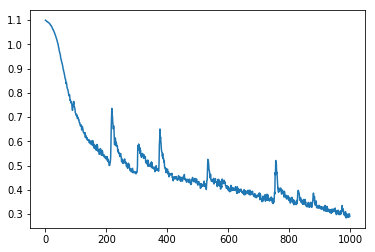

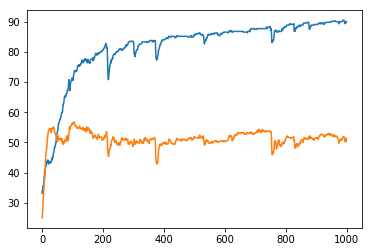

In [11]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [12]:
max(epoch_accuracies[1])

56.79347826086956

## Save model and scaler

In [13]:
torch.save(model.state_dict(), "models/passive_mass_model.pt")

In [14]:
joblib.dump(scaler, "scalers/passive_mass_scaler.sk")

['scalers/passive_mass_scaler.sk']

## Load model and evaluate

In [15]:
model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model.load_state_dict(torch.load("models/passive_mass_model.pt"))
model.eval()
model = model.cuda()

In [16]:
accuracy, predicted = evaluate(model, val_loader, return_predicted=True)

In [17]:
print(accuracy)

51.358695652173914


In [18]:
predicted = [pred.cpu() for pred in predicted]
Y_val = np.concatenate([y.cpu().numpy() for x, y in val_loader])

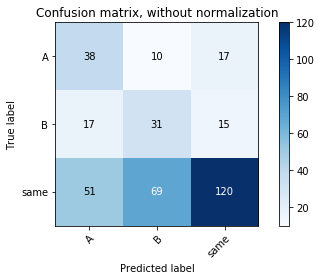

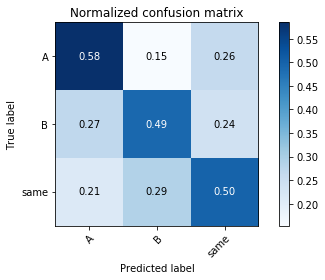

In [19]:
plot_confusion_matrix(Y_val, predicted, classes=MASS_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y_val, predicted, classes=MASS_CLASS_COLS, normalize=True)

# FORCE TRAINING  (Humans achieve 61% +- 22%)

## Read dataset and preprocess it

In [20]:
all_trials = read_dataset("data/passive_trials.h5")
train_loader, val_loader, scaler = prepare_dataset(all_trials, FORCE_CLASS_COLS, 
                                                   normalise_data=True, batch_size=128, test_size=0.3)

In [21]:
Y = []
for x,y in train_loader:
    
    Y.extend(list(y))

counts = np.unique(Y, return_counts=True)[1]

In [22]:
print("Majority class: ", np.max(counts) / np.sum(counts))

Majority class:  0.3333333333333333


## Define model, loss and optimizer

In [23]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = len(BASIC_TRAINING_COLS)    # input dimension
first_hidden_dim = 12  # hidden layer dimension
second_hidden_dim = 6     # number of hidden layers
output_dim = 3   # output dimension

model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model and plot loss and accuracy

In [25]:
epoch_losses, epoch_accuracies = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs=1000)

  0%|          | 1/1000 [00:00<12:33,  1.33it/s]

1.0986317694187164 34.72222222222222 35.810810810810814


  0%|          | 2/1000 [00:01<12:16,  1.36it/s]

1.0977091193199158 33.92857142857143 36.148648648648646


  0%|          | 3/1000 [00:02<12:09,  1.37it/s]

1.0967854261398315 33.92857142857143 36.148648648648646


  0%|          | 4/1000 [00:03<12:42,  1.31it/s]

1.0972227156162262 34.92063492063492 36.486486486486484


  0%|          | 5/1000 [00:03<13:18,  1.25it/s]

1.0963620245456696 35.317460317460316 36.486486486486484


  1%|          | 6/1000 [00:04<13:34,  1.22it/s]

1.0953750610351562 35.51587301587302 36.486486486486484


  1%|          | 7/1000 [00:05<13:57,  1.19it/s]

1.0930987298488617 35.91269841269841 37.16216216216216


  1%|          | 8/1000 [00:06<14:13,  1.16it/s]

1.0931084156036377 37.5 37.83783783783784


  1%|          | 9/1000 [00:07<14:24,  1.15it/s]

1.0926478803157806 37.5 37.5


  1%|          | 10/1000 [00:08<14:02,  1.18it/s]

1.0920988321304321 38.095238095238095 38.513513513513516


  1%|          | 11/1000 [00:08<13:10,  1.25it/s]

1.089427798986435 38.69047619047619 38.851351351351354


  1%|          | 12/1000 [00:09<12:44,  1.29it/s]

1.0891694724559784 39.88095238095238 38.513513513513516


  1%|▏         | 13/1000 [00:10<12:11,  1.35it/s]

1.0894084572792053 40.67460317460318 38.851351351351354


  1%|▏         | 14/1000 [00:10<11:46,  1.40it/s]

1.0870100855827332 41.07142857142857 40.2027027027027


  2%|▏         | 15/1000 [00:11<11:40,  1.41it/s]

1.0869399905204773 41.666666666666664 41.554054054054056


  2%|▏         | 16/1000 [00:12<11:37,  1.41it/s]

1.0852244794368744 42.65873015873016 41.891891891891895


  2%|▏         | 17/1000 [00:13<11:26,  1.43it/s]

1.0839588344097137 43.84920634920635 42.9054054054054


  2%|▏         | 18/1000 [00:13<11:28,  1.43it/s]

1.0830623507499695 45.03968253968254 42.567567567567565


  2%|▏         | 19/1000 [00:14<11:21,  1.44it/s]

1.081455647945404 45.03968253968254 42.567567567567565


  2%|▏         | 20/1000 [00:15<11:21,  1.44it/s]

1.0786090791225433 45.43650793650794 42.229729729729726


  2%|▏         | 21/1000 [00:15<11:24,  1.43it/s]

1.0762482583522797 46.82539682539682 42.229729729729726


  2%|▏         | 22/1000 [00:16<11:28,  1.42it/s]

1.0767730474472046 47.22222222222222 41.554054054054056


  2%|▏         | 23/1000 [00:17<11:33,  1.41it/s]

1.074297547340393 47.22222222222222 40.87837837837838


  2%|▏         | 24/1000 [00:17<11:27,  1.42it/s]

1.0727600753307343 47.023809523809526 40.54054054054054


  2%|▎         | 25/1000 [00:18<11:29,  1.41it/s]

1.0683550834655762 47.22222222222222 40.87837837837838


  3%|▎         | 26/1000 [00:19<11:25,  1.42it/s]

1.0674484968185425 48.41269841269841 40.54054054054054


  3%|▎         | 27/1000 [00:20<11:27,  1.42it/s]

1.0633505880832672 48.611111111111114 40.2027027027027


  3%|▎         | 28/1000 [00:20<11:27,  1.41it/s]

1.0612478852272034 48.611111111111114 40.54054054054054


  3%|▎         | 29/1000 [00:21<11:30,  1.41it/s]

1.0557115077972412 50.3968253968254 40.2027027027027


  3%|▎         | 30/1000 [00:22<12:01,  1.34it/s]

1.0505934953689575 51.19047619047619 40.87837837837838


  3%|▎         | 31/1000 [00:23<12:13,  1.32it/s]

1.0495726466178894 50.992063492063494 40.54054054054054


  3%|▎         | 32/1000 [00:23<12:16,  1.31it/s]

1.0454667210578918 51.58730158730159 40.87837837837838


  3%|▎         | 33/1000 [00:24<11:48,  1.37it/s]

1.0425093472003937 53.37301587301587 41.21621621621622


  3%|▎         | 34/1000 [00:25<11:42,  1.37it/s]

1.0340146124362946 53.76984126984127 42.229729729729726


  4%|▎         | 35/1000 [00:26<11:52,  1.36it/s]

1.0292324125766754 55.15873015873016 42.9054054054054


  4%|▎         | 36/1000 [00:26<12:31,  1.28it/s]

1.0228687524795532 54.96031746031746 42.567567567567565


  4%|▎         | 37/1000 [00:27<12:24,  1.29it/s]

1.0197818875312805 55.357142857142854 42.567567567567565


  4%|▍         | 38/1000 [00:28<12:32,  1.28it/s]

1.0088626742362976 55.55555555555556 42.567567567567565


  4%|▍         | 39/1000 [00:29<12:52,  1.24it/s]

1.0060319751501083 55.357142857142854 43.24324324324324


  4%|▍         | 40/1000 [00:30<12:34,  1.27it/s]

0.999381959438324 56.15079365079365 44.25675675675676


  4%|▍         | 41/1000 [00:30<12:25,  1.29it/s]

0.9947517961263657 57.142857142857146 44.5945945945946


  4%|▍         | 42/1000 [00:31<12:36,  1.27it/s]

0.9881677627563477 58.53174603174603 45.270270270270274


  4%|▍         | 43/1000 [00:32<12:48,  1.25it/s]

0.9807049483060837 58.13492063492063 43.58108108108108


  4%|▍         | 44/1000 [00:33<12:44,  1.25it/s]

0.9737102389335632 58.92857142857143 43.91891891891892


  4%|▍         | 45/1000 [00:34<12:58,  1.23it/s]

0.965407058596611 59.72222222222222 43.58108108108108


  5%|▍         | 46/1000 [00:34<12:40,  1.25it/s]

0.9600912928581238 60.714285714285715 44.5945945945946


  5%|▍         | 47/1000 [00:35<12:57,  1.23it/s]

0.9516052752733231 60.714285714285715 44.25675675675676


  5%|▍         | 48/1000 [00:36<13:02,  1.22it/s]

0.9412146806716919 60.91269841269841 44.932432432432435


  5%|▍         | 49/1000 [00:37<13:02,  1.22it/s]

0.9336476922035217 61.70634920634921 44.5945945945946


  5%|▌         | 50/1000 [00:38<12:38,  1.25it/s]

0.9307934939861298 61.904761904761905 44.5945945945946


  5%|▌         | 51/1000 [00:38<12:02,  1.31it/s]

0.9251631200313568 61.111111111111114 44.932432432432435


  5%|▌         | 52/1000 [00:39<11:45,  1.34it/s]

0.9178128242492676 61.30952380952381 44.932432432432435


  5%|▌         | 53/1000 [00:40<11:30,  1.37it/s]

0.9064908772706985 61.70634920634921 45.608108108108105


  5%|▌         | 54/1000 [00:40<11:23,  1.38it/s]

0.9026153832674026 63.492063492063494 45.608108108108105


  6%|▌         | 55/1000 [00:41<11:17,  1.39it/s]

0.8968798369169235 63.69047619047619 45.608108108108105


  6%|▌         | 56/1000 [00:42<11:15,  1.40it/s]

0.886932298541069 65.07936507936508 45.945945945945944


  6%|▌         | 57/1000 [00:43<11:05,  1.42it/s]

0.885000005364418 65.27777777777777 45.945945945945944


  6%|▌         | 58/1000 [00:43<11:48,  1.33it/s]

0.8785157799720764 66.46825396825396 46.95945945945946


  6%|▌         | 59/1000 [00:44<11:38,  1.35it/s]

0.8681463897228241 66.66666666666667 47.2972972972973


  6%|▌         | 60/1000 [00:45<11:20,  1.38it/s]

0.864899754524231 67.26190476190476 47.972972972972975


  6%|▌         | 61/1000 [00:45<11:01,  1.42it/s]

0.8550155758857727 68.65079365079364 48.648648648648646


  6%|▌         | 62/1000 [00:46<10:51,  1.44it/s]

0.8452979773283005 69.24603174603175 48.986486486486484


  6%|▋         | 63/1000 [00:47<10:41,  1.46it/s]

0.8365568965673447 70.43650793650794 48.986486486486484


  6%|▋         | 64/1000 [00:47<10:39,  1.46it/s]

0.8343232125043869 70.03968253968254 48.986486486486484


  6%|▋         | 65/1000 [00:48<11:18,  1.38it/s]

0.8200807869434357 70.23809523809524 49.32432432432432


  7%|▋         | 66/1000 [00:49<11:08,  1.40it/s]

0.8186445981264114 70.83333333333333 49.66216216216216


  7%|▋         | 67/1000 [00:50<11:53,  1.31it/s]

0.8087601363658905 71.82539682539682 50.33783783783784


  7%|▋         | 68/1000 [00:51<11:40,  1.33it/s]

0.8004767298698425 71.82539682539682 51.013513513513516


  7%|▋         | 69/1000 [00:51<11:58,  1.29it/s]

0.7906182408332825 72.22222222222223 51.351351351351354


  7%|▋         | 70/1000 [00:52<11:52,  1.31it/s]

0.7826111614704132 72.02380952380952 52.027027027027025


  7%|▋         | 71/1000 [00:53<12:16,  1.26it/s]

0.7756294757127762 72.22222222222223 52.36486486486486


  7%|▋         | 72/1000 [00:54<12:15,  1.26it/s]

0.7704400718212128 72.22222222222223 52.7027027027027


  7%|▋         | 73/1000 [00:55<12:37,  1.22it/s]

0.7674689292907715 72.42063492063492 52.36486486486486


  7%|▋         | 74/1000 [00:55<12:06,  1.27it/s]

0.7545192241668701 73.80952380952381 52.7027027027027


  8%|▊         | 75/1000 [00:56<11:40,  1.32it/s]

0.747526079416275 74.2063492063492 52.027027027027025


  8%|▊         | 76/1000 [00:57<11:15,  1.37it/s]

0.746022030711174 75.1984126984127 53.37837837837838


  8%|▊         | 77/1000 [00:58<11:48,  1.30it/s]

0.7394243329763412 75.9920634920635 53.37837837837838


  8%|▊         | 78/1000 [00:58<11:40,  1.32it/s]

0.7306966334581375 76.19047619047619 53.37837837837838


  8%|▊         | 79/1000 [00:59<11:29,  1.34it/s]

0.7242333590984344 76.58730158730158 53.37837837837838


  8%|▊         | 80/1000 [01:00<11:51,  1.29it/s]

0.7156908512115479 76.98412698412699 53.71621621621622


  8%|▊         | 81/1000 [01:01<12:02,  1.27it/s]

0.7078160792589188 76.38888888888889 53.37837837837838


  8%|▊         | 82/1000 [01:02<12:16,  1.25it/s]

0.6956148892641068 76.19047619047619 53.71621621621622


  8%|▊         | 83/1000 [01:02<11:48,  1.29it/s]

0.6928352117538452 76.78571428571429 53.37837837837838


  8%|▊         | 84/1000 [01:03<12:17,  1.24it/s]

0.6880293041467667 77.18253968253968 53.37837837837838


  8%|▊         | 85/1000 [01:04<11:32,  1.32it/s]

0.6803406774997711 77.77777777777777 54.391891891891895


  9%|▊         | 86/1000 [01:05<11:22,  1.34it/s]

0.6671551465988159 77.97619047619048 53.71621621621622


  9%|▊         | 87/1000 [01:05<11:05,  1.37it/s]

0.6566913425922394 77.38095238095238 53.37837837837838


  9%|▉         | 88/1000 [01:06<10:58,  1.38it/s]

0.6687778532505035 77.77777777777777 53.04054054054054


  9%|▉         | 89/1000 [01:07<10:54,  1.39it/s]

0.6556959301233292 78.17460317460318 54.054054054054056


  9%|▉         | 90/1000 [01:07<10:46,  1.41it/s]

0.6442178040742874 78.37301587301587 54.729729729729726


  9%|▉         | 91/1000 [01:08<11:08,  1.36it/s]

0.6401212066411972 78.76984126984127 54.729729729729726


  9%|▉         | 92/1000 [01:09<11:26,  1.32it/s]

0.6357502639293671 79.16666666666667 54.729729729729726


  9%|▉         | 93/1000 [01:10<10:59,  1.38it/s]

0.620490238070488 80.35714285714286 55.4054054054054


  9%|▉         | 94/1000 [01:10<11:27,  1.32it/s]

0.6162718683481216 80.35714285714286 55.4054054054054


 10%|▉         | 95/1000 [01:11<11:58,  1.26it/s]

0.6078156977891922 80.55555555555556 55.4054054054054


 10%|▉         | 96/1000 [01:12<11:29,  1.31it/s]

0.6085261777043343 80.55555555555556 54.729729729729726


 10%|▉         | 97/1000 [01:13<11:03,  1.36it/s]

0.609760694205761 80.55555555555556 54.054054054054056


 10%|▉         | 98/1000 [01:13<10:42,  1.40it/s]

0.603382520377636 80.35714285714286 53.71621621621622


 10%|▉         | 99/1000 [01:14<10:24,  1.44it/s]

0.5997471213340759 79.56349206349206 53.71621621621622


 10%|█         | 100/1000 [01:15<10:25,  1.44it/s]

0.5934552550315857 79.56349206349206 54.054054054054056


 10%|█         | 101/1000 [01:15<10:16,  1.46it/s]

0.5969751179218292 79.56349206349206 54.054054054054056


 10%|█         | 102/1000 [01:16<10:10,  1.47it/s]

0.5827898383140564 80.15873015873017 55.067567567567565


 10%|█         | 103/1000 [01:17<10:17,  1.45it/s]

0.577765092253685 80.35714285714286 55.74324324324324


 10%|█         | 104/1000 [01:17<10:41,  1.40it/s]

0.5781072378158569 80.95238095238095 56.08108108108108


 10%|█         | 105/1000 [01:18<11:25,  1.30it/s]

0.5711811408400536 81.15079365079364 55.4054054054054


 11%|█         | 106/1000 [01:19<11:39,  1.28it/s]

0.5640640184283257 81.94444444444444 56.75675675675676


 11%|█         | 107/1000 [01:20<11:46,  1.26it/s]

0.5750898793339729 81.54761904761905 56.75675675675676


 11%|█         | 108/1000 [01:21<12:13,  1.22it/s]

0.5578087270259857 81.94444444444444 56.75675675675676


 11%|█         | 109/1000 [01:22<12:32,  1.18it/s]

0.5464244112372398 81.74603174603175 56.41891891891892


 11%|█         | 110/1000 [01:23<12:37,  1.18it/s]

0.5596050173044205 81.34920634920636 56.41891891891892


 11%|█         | 111/1000 [01:23<12:32,  1.18it/s]

0.5387265309691429 80.95238095238095 56.75675675675676


 11%|█         | 112/1000 [01:24<12:30,  1.18it/s]

0.5562659576535225 81.74603174603175 57.770270270270274


 11%|█▏        | 113/1000 [01:25<12:39,  1.17it/s]

0.5503270700573921 82.14285714285714 57.770270270270274


 11%|█▏        | 114/1000 [01:26<11:53,  1.24it/s]

0.5619021579623222 82.34126984126983 58.78378378378378


 12%|█▏        | 115/1000 [01:27<12:02,  1.23it/s]

0.5487285479903221 82.34126984126983 58.78378378378378


 12%|█▏        | 116/1000 [01:27<11:32,  1.28it/s]

0.5436183139681816 81.94444444444444 58.78378378378378


 12%|█▏        | 117/1000 [01:28<11:06,  1.32it/s]

0.5567000806331635 82.53968253968254 59.12162162162162


 12%|█▏        | 118/1000 [01:29<11:26,  1.28it/s]

0.5332134291529655 83.13492063492063 59.7972972972973


 12%|█▏        | 119/1000 [01:30<11:40,  1.26it/s]

0.5261840671300888 82.93650793650794 59.12162162162162


 12%|█▏        | 120/1000 [01:31<11:20,  1.29it/s]

0.5297773703932762 83.53174603174604 59.45945945945946


 12%|█▏        | 121/1000 [01:31<10:51,  1.35it/s]

0.5217708647251129 83.73015873015873 60.13513513513514


 12%|█▏        | 122/1000 [01:32<10:42,  1.37it/s]

0.5171428099274635 83.92857142857143 60.13513513513514


 12%|█▏        | 123/1000 [01:33<11:14,  1.30it/s]

0.5158153846859932 84.12698412698413 60.13513513513514


 12%|█▏        | 124/1000 [01:34<11:47,  1.24it/s]

0.509282074868679 83.13492063492063 59.7972972972973


 12%|█▎        | 125/1000 [01:35<12:11,  1.20it/s]

0.5273449197411537 82.73809523809524 58.78378378378378


 13%|█▎        | 126/1000 [01:35<12:25,  1.17it/s]

0.5318399295210838 82.34126984126983 57.770270270270274


 13%|█▎        | 127/1000 [01:36<12:22,  1.18it/s]

0.5329862907528877 83.13492063492063 57.770270270270274


 13%|█▎        | 128/1000 [01:37<12:33,  1.16it/s]

0.5155342295765877 84.32539682539682 59.12162162162162


 13%|█▎        | 129/1000 [01:38<12:39,  1.15it/s]

0.5008719861507416 84.32539682539682 59.7972972972973


 13%|█▎        | 130/1000 [01:39<12:39,  1.15it/s]

0.4999290704727173 84.72222222222223 60.13513513513514


 13%|█▎        | 131/1000 [01:40<12:05,  1.20it/s]

0.49417687952518463 85.11904761904762 60.810810810810814


 13%|█▎        | 132/1000 [01:40<11:26,  1.26it/s]

0.4921237528324127 84.92063492063492 60.810810810810814


 13%|█▎        | 133/1000 [01:41<11:04,  1.30it/s]

0.49846457690000534 84.72222222222223 60.13513513513514


 13%|█▎        | 134/1000 [01:42<10:50,  1.33it/s]

0.4868355765938759 85.31746031746032 60.13513513513514


 14%|█▎        | 135/1000 [01:43<10:56,  1.32it/s]

0.4870700463652611 84.72222222222223 59.45945945945946


 14%|█▎        | 136/1000 [01:43<11:31,  1.25it/s]

0.4943599998950958 84.92063492063492 59.45945945945946


 14%|█▎        | 137/1000 [01:44<11:16,  1.28it/s]

0.48570679128170013 84.52380952380952 59.45945945945946


 14%|█▍        | 138/1000 [01:45<11:29,  1.25it/s]

0.47834860533475876 84.52380952380952 59.12162162162162


 14%|█▍        | 139/1000 [01:46<11:10,  1.28it/s]

0.4804350733757019 84.72222222222223 59.45945945945946


 14%|█▍        | 140/1000 [01:47<10:58,  1.31it/s]

0.4788438528776169 85.11904761904762 59.12162162162162


 14%|█▍        | 141/1000 [01:47<11:29,  1.25it/s]

0.4729374721646309 85.31746031746032 59.45945945945946


 14%|█▍        | 142/1000 [01:48<11:52,  1.20it/s]

0.4559740349650383 85.11904761904762 59.45945945945946


 14%|█▍        | 143/1000 [01:49<12:03,  1.18it/s]

0.45533815026283264 85.31746031746032 59.7972972972973


 14%|█▍        | 144/1000 [01:50<12:12,  1.17it/s]

0.4549068734049797 85.31746031746032 60.13513513513514


 14%|█▍        | 145/1000 [01:51<12:19,  1.16it/s]

0.4555684104561806 84.72222222222223 59.45945945945946


 15%|█▍        | 146/1000 [01:52<12:22,  1.15it/s]

0.4505835995078087 84.52380952380952 59.12162162162162


 15%|█▍        | 147/1000 [01:53<12:20,  1.15it/s]

0.45179661363363266 84.92063492063492 59.7972972972973


 15%|█▍        | 148/1000 [01:54<12:15,  1.16it/s]

0.4462132304906845 85.51587301587301 60.13513513513514


 15%|█▍        | 149/1000 [01:54<12:17,  1.15it/s]

0.44106558710336685 85.31746031746032 60.472972972972975


 15%|█▌        | 150/1000 [01:55<12:21,  1.15it/s]

0.4455944001674652 85.51587301587301 60.472972972972975


 15%|█▌        | 151/1000 [01:56<12:21,  1.14it/s]

0.4407558813691139 85.71428571428571 60.472972972972975


 15%|█▌        | 152/1000 [01:57<12:23,  1.14it/s]

0.4396448954939842 85.51587301587301 60.810810810810814


 15%|█▌        | 153/1000 [01:58<12:27,  1.13it/s]

0.4319160208106041 85.71428571428571 60.472972972972975


 15%|█▌        | 154/1000 [01:59<12:22,  1.14it/s]

0.427585206925869 86.11111111111111 60.13513513513514


 16%|█▌        | 155/1000 [02:00<12:23,  1.14it/s]

0.4314873591065407 86.11111111111111 60.13513513513514


 16%|█▌        | 156/1000 [02:01<12:24,  1.13it/s]

0.4393981397151947 85.91269841269842 60.13513513513514


 16%|█▌        | 157/1000 [02:01<12:11,  1.15it/s]

0.43222611397504807 85.91269841269842 60.13513513513514


 16%|█▌        | 158/1000 [02:02<12:12,  1.15it/s]

0.43697912991046906 86.11111111111111 60.810810810810814


 16%|█▌        | 159/1000 [02:03<12:15,  1.14it/s]

0.4149671569466591 85.71428571428571 60.472972972972975


 16%|█▌        | 160/1000 [02:04<11:42,  1.20it/s]

0.4207497909665108 85.91269841269842 61.148648648648646


 16%|█▌        | 161/1000 [02:05<11:56,  1.17it/s]

0.4241853281855583 86.11111111111111 61.486486486486484


 16%|█▌        | 162/1000 [02:06<11:45,  1.19it/s]

0.41110900044441223 86.7063492063492 61.148648648648646


 16%|█▋        | 163/1000 [02:06<11:16,  1.24it/s]

0.41627446562051773 86.7063492063492 61.148648648648646


 16%|█▋        | 164/1000 [02:07<10:53,  1.28it/s]

0.41613148897886276 86.7063492063492 61.148648648648646


 16%|█▋        | 165/1000 [02:08<11:04,  1.26it/s]

0.4140218570828438 86.7063492063492 60.810810810810814


 17%|█▋        | 166/1000 [02:09<11:29,  1.21it/s]

0.4119041785597801 86.7063492063492 60.472972972972975


 17%|█▋        | 167/1000 [02:10<11:27,  1.21it/s]

0.4090937599539757 86.7063492063492 60.810810810810814


 17%|█▋        | 168/1000 [02:10<10:55,  1.27it/s]

0.4042689651250839 86.7063492063492 61.486486486486484


 17%|█▋        | 169/1000 [02:11<11:13,  1.23it/s]

0.41439686715602875 86.7063492063492 61.486486486486484


 17%|█▋        | 170/1000 [02:12<11:31,  1.20it/s]

0.4054447263479233 86.30952380952381 61.82432432432432


 17%|█▋        | 171/1000 [02:13<11:08,  1.24it/s]

0.3978944271802902 86.30952380952381 61.486486486486484


 17%|█▋        | 172/1000 [02:14<10:51,  1.27it/s]

0.3981575518846512 85.91269841269842 61.148648648648646


 17%|█▋        | 173/1000 [02:14<11:07,  1.24it/s]

0.41074271500110626 86.11111111111111 60.472972972972975


 17%|█▋        | 174/1000 [02:15<11:01,  1.25it/s]

0.3923320844769478 86.30952380952381 60.810810810810814


 18%|█▊        | 175/1000 [02:16<10:38,  1.29it/s]

0.39456266164779663 86.5079365079365 60.472972972972975


 18%|█▊        | 176/1000 [02:17<10:20,  1.33it/s]

0.39332643151283264 86.9047619047619 60.810810810810814


 18%|█▊        | 177/1000 [02:17<10:10,  1.35it/s]

0.39853546023368835 87.6984126984127 60.810810810810814


 18%|█▊        | 178/1000 [02:18<10:04,  1.36it/s]

0.3927491381764412 87.5 61.148648648648646


 18%|█▊        | 179/1000 [02:19<10:03,  1.36it/s]

0.38351382315158844 87.5 60.810810810810814


 18%|█▊        | 180/1000 [02:20<09:52,  1.38it/s]

0.3915970101952553 87.6984126984127 60.810810810810814


 18%|█▊        | 181/1000 [02:20<09:49,  1.39it/s]

0.39303892850875854 87.6984126984127 60.472972972972975


 18%|█▊        | 182/1000 [02:21<09:48,  1.39it/s]

0.3745274171233177 87.5 59.7972972972973


 18%|█▊        | 183/1000 [02:22<09:49,  1.38it/s]

0.38081371039152145 87.3015873015873 59.7972972972973


 18%|█▊        | 184/1000 [02:22<09:51,  1.38it/s]

0.3937901258468628 87.3015873015873 59.45945945945946


 18%|█▊        | 185/1000 [02:23<10:02,  1.35it/s]

0.3878775015473366 87.10317460317461 59.45945945945946


 19%|█▊        | 186/1000 [02:24<10:18,  1.32it/s]

0.38878999650478363 87.10317460317461 59.45945945945946


 19%|█▊        | 187/1000 [02:25<10:38,  1.27it/s]

0.3847646936774254 87.3015873015873 59.45945945945946


 19%|█▉        | 188/1000 [02:26<11:03,  1.22it/s]

0.4031261131167412 86.9047619047619 59.45945945945946


 19%|█▉        | 189/1000 [02:27<11:19,  1.19it/s]

0.3885190784931183 86.7063492063492 60.13513513513514


 19%|█▉        | 190/1000 [02:27<11:18,  1.19it/s]

0.4035407826304436 86.5079365079365 60.472972972972975


 19%|█▉        | 191/1000 [02:28<11:31,  1.17it/s]

0.4073239341378212 85.91269841269842 59.12162162162162


 19%|█▉        | 192/1000 [02:29<11:39,  1.15it/s]

0.42821476608514786 86.7063492063492 59.12162162162162


 19%|█▉        | 193/1000 [02:30<11:34,  1.16it/s]

0.39891406148672104 86.5079365079365 59.12162162162162


 19%|█▉        | 194/1000 [02:31<11:10,  1.20it/s]

0.4091940224170685 86.9047619047619 59.45945945945946


 20%|█▉        | 195/1000 [02:32<10:54,  1.23it/s]

0.3951762244105339 87.3015873015873 59.12162162162162


 20%|█▉        | 196/1000 [02:32<10:28,  1.28it/s]

0.39558060467243195 86.7063492063492 58.445945945945944


 20%|█▉        | 197/1000 [02:33<10:36,  1.26it/s]

0.38601967692375183 86.9047619047619 58.445945945945944


 20%|█▉        | 198/1000 [02:34<10:41,  1.25it/s]

0.3977437987923622 87.10317460317461 58.108108108108105


 20%|█▉        | 199/1000 [02:35<10:52,  1.23it/s]

0.3850507214665413 87.10317460317461 58.445945945945944


 20%|██        | 200/1000 [02:36<11:08,  1.20it/s]

0.37707219272851944 87.3015873015873 58.108108108108105


 20%|██        | 201/1000 [02:37<11:15,  1.18it/s]

0.389077328145504 87.10317460317461 58.78378378378378


 20%|██        | 202/1000 [02:37<11:21,  1.17it/s]

0.3795757070183754 87.3015873015873 58.78378378378378


 20%|██        | 203/1000 [02:38<11:08,  1.19it/s]

0.36896222084760666 87.5 58.445945945945944


 20%|██        | 204/1000 [02:39<10:59,  1.21it/s]

0.3841494843363762 87.3015873015873 58.78378378378378


 20%|██        | 205/1000 [02:40<11:06,  1.19it/s]

0.3713857978582382 87.10317460317461 58.108108108108105


 21%|██        | 206/1000 [02:41<11:04,  1.20it/s]

0.36650794744491577 87.3015873015873 58.445945945945944


 21%|██        | 207/1000 [02:42<10:53,  1.21it/s]

0.36382992565631866 87.3015873015873 58.445945945945944


 21%|██        | 208/1000 [02:42<10:52,  1.21it/s]

0.36372266709804535 87.3015873015873 58.445945945945944


 21%|██        | 209/1000 [02:43<10:38,  1.24it/s]

0.3608470782637596 87.3015873015873 58.108108108108105


 21%|██        | 210/1000 [02:44<10:20,  1.27it/s]

0.3697245195508003 87.10317460317461 58.445945945945944


 21%|██        | 211/1000 [02:45<10:27,  1.26it/s]

0.3568752780556679 87.3015873015873 58.78378378378378


 21%|██        | 212/1000 [02:45<10:23,  1.26it/s]

0.3624115660786629 87.5 59.45945945945946


 21%|██▏       | 213/1000 [02:46<10:18,  1.27it/s]

0.36872806400060654 87.6984126984127 59.12162162162162


 21%|██▏       | 214/1000 [02:47<10:11,  1.29it/s]

0.3568296507000923 87.89682539682539 59.12162162162162


 22%|██▏       | 215/1000 [02:48<10:04,  1.30it/s]

0.35698023438453674 88.0952380952381 58.108108108108105


 22%|██▏       | 216/1000 [02:49<10:06,  1.29it/s]

0.3591781184077263 87.89682539682539 58.445945945945944


 22%|██▏       | 217/1000 [02:49<10:17,  1.27it/s]

0.34869448840618134 87.89682539682539 58.445945945945944


 22%|██▏       | 218/1000 [02:50<10:14,  1.27it/s]

0.35568468272686005 88.0952380952381 58.78378378378378


 22%|██▏       | 219/1000 [02:51<10:14,  1.27it/s]

0.3465959057211876 88.4920634920635 59.45945945945946


 22%|██▏       | 220/1000 [02:52<09:54,  1.31it/s]

0.351967990398407 88.4920634920635 59.12162162162162


 22%|██▏       | 221/1000 [02:52<09:51,  1.32it/s]

0.3586934581398964 88.4920634920635 59.12162162162162


 22%|██▏       | 222/1000 [02:53<10:02,  1.29it/s]

0.3414495512843132 88.0952380952381 58.445945945945944


 22%|██▏       | 223/1000 [02:54<10:03,  1.29it/s]

0.3618401736021042 87.5 58.445945945945944


 22%|██▏       | 224/1000 [02:55<09:48,  1.32it/s]

0.3466365709900856 87.89682539682539 59.45945945945946


 22%|██▎       | 225/1000 [02:55<09:41,  1.33it/s]

0.3580176308751106 88.0952380952381 59.45945945945946


 23%|██▎       | 226/1000 [02:56<09:47,  1.32it/s]

0.35908930748701096 88.0952380952381 59.7972972972973


 23%|██▎       | 227/1000 [02:57<10:13,  1.26it/s]

0.3603813052177429 87.89682539682539 58.78378378378378


 23%|██▎       | 228/1000 [02:58<10:25,  1.23it/s]

0.3514368608593941 87.89682539682539 58.108108108108105


 23%|██▎       | 229/1000 [02:59<10:24,  1.24it/s]

0.3587014749646187 86.7063492063492 57.770270270270274


 23%|██▎       | 230/1000 [02:59<10:11,  1.26it/s]

0.40418365597724915 83.53174603174604 57.770270270270274


 23%|██▎       | 231/1000 [03:00<10:05,  1.27it/s]

0.46636369079351425 82.34126984126983 57.0945945945946


 23%|██▎       | 232/1000 [03:01<10:25,  1.23it/s]

0.49954432994127274 80.95238095238095 56.75675675675676


 23%|██▎       | 233/1000 [03:02<10:15,  1.25it/s]

0.5381691977381706 81.34920634920636 57.432432432432435


 23%|██▎       | 234/1000 [03:03<10:03,  1.27it/s]

0.5350590497255325 81.54761904761905 55.74324324324324


 24%|██▎       | 235/1000 [03:03<10:13,  1.25it/s]

0.5152170732617378 81.34920634920636 56.08108108108108


 24%|██▎       | 236/1000 [03:04<10:19,  1.23it/s]

0.5116051957011223 82.53968253968254 56.75675675675676


 24%|██▎       | 237/1000 [03:05<10:12,  1.25it/s]

0.4977724850177765 82.73809523809524 56.75675675675676


 24%|██▍       | 238/1000 [03:06<10:33,  1.20it/s]

0.47904955595731735 83.53174603174604 57.0945945945946


 24%|██▍       | 239/1000 [03:07<10:46,  1.18it/s]

0.4659915566444397 83.53174603174604 57.432432432432435


 24%|██▍       | 240/1000 [03:08<10:55,  1.16it/s]

0.4682098478078842 83.53174603174604 57.432432432432435


 24%|██▍       | 241/1000 [03:09<10:32,  1.20it/s]

0.4547043591737747 83.92857142857143 58.108108108108105


 24%|██▍       | 242/1000 [03:09<09:57,  1.27it/s]

0.4357191100716591 84.52380952380952 57.432432432432435


 24%|██▍       | 243/1000 [03:10<09:39,  1.31it/s]

0.4434279352426529 84.72222222222223 56.41891891891892


 24%|██▍       | 244/1000 [03:11<09:29,  1.33it/s]

0.456779420375824 85.51587301587301 56.75675675675676


 24%|██▍       | 245/1000 [03:11<09:08,  1.38it/s]

0.4592312201857567 85.51587301587301 56.75675675675676


 25%|██▍       | 246/1000 [03:12<09:05,  1.38it/s]

0.4286430701613426 85.91269841269842 57.0945945945946


 25%|██▍       | 247/1000 [03:13<09:05,  1.38it/s]

0.4173983335494995 86.30952380952381 58.108108108108105


 25%|██▍       | 248/1000 [03:13<08:46,  1.43it/s]

0.4120957925915718 86.30952380952381 57.770270270270274


 25%|██▍       | 249/1000 [03:14<08:37,  1.45it/s]

0.4130904898047447 86.30952380952381 57.770270270270274


 25%|██▌       | 250/1000 [03:15<08:21,  1.50it/s]

0.39890074729919434 86.5079365079365 58.108108108108105


 25%|██▌       | 251/1000 [03:15<08:16,  1.51it/s]

0.3968818113207817 86.5079365079365 58.108108108108105


 25%|██▌       | 252/1000 [03:16<08:08,  1.53it/s]

0.39945198595523834 86.5079365079365 58.78378378378378


 25%|██▌       | 253/1000 [03:17<08:09,  1.53it/s]

0.3922048434615135 86.30952380952381 58.78378378378378


 25%|██▌       | 254/1000 [03:17<07:59,  1.56it/s]

0.3857693672180176 86.30952380952381 58.78378378378378


 26%|██▌       | 255/1000 [03:18<07:52,  1.58it/s]

0.395607054233551 86.7063492063492 59.12162162162162


 26%|██▌       | 256/1000 [03:18<07:50,  1.58it/s]

0.38644930720329285 86.7063492063492 58.78378378378378


 26%|██▌       | 257/1000 [03:19<07:45,  1.59it/s]

0.39347053319215775 86.9047619047619 58.445945945945944


 26%|██▌       | 258/1000 [03:20<08:15,  1.50it/s]

0.3874307721853256 86.9047619047619 58.445945945945944


 26%|██▌       | 259/1000 [03:21<08:42,  1.42it/s]

0.37830954790115356 86.7063492063492 58.445945945945944


 26%|██▌       | 260/1000 [03:22<09:12,  1.34it/s]

0.38334590196609497 87.3015873015873 59.12162162162162


 26%|██▌       | 261/1000 [03:22<09:29,  1.30it/s]

0.3703942745923996 87.3015873015873 59.45945945945946


 26%|██▌       | 262/1000 [03:23<09:27,  1.30it/s]

0.381367526948452 87.3015873015873 59.45945945945946


 26%|██▋       | 263/1000 [03:24<08:55,  1.38it/s]

0.3828084319829941 87.5 59.45945945945946


 26%|██▋       | 264/1000 [03:24<08:38,  1.42it/s]

0.3696969822049141 87.5 59.45945945945946


 26%|██▋       | 265/1000 [03:25<08:38,  1.42it/s]

0.38014210015535355 87.5 59.45945945945946


 27%|██▋       | 266/1000 [03:26<08:40,  1.41it/s]

0.3751842677593231 87.6984126984127 59.45945945945946


 27%|██▋       | 267/1000 [03:27<08:39,  1.41it/s]

0.3819493278861046 87.5 59.45945945945946


 27%|██▋       | 268/1000 [03:27<08:41,  1.40it/s]

0.37214118987321854 87.3015873015873 59.45945945945946


 27%|██▋       | 269/1000 [03:28<08:39,  1.41it/s]

0.3820262923836708 87.5 59.45945945945946


 27%|██▋       | 270/1000 [03:29<08:40,  1.40it/s]

0.36524663865566254 87.6984126984127 59.45945945945946


 27%|██▋       | 271/1000 [03:29<08:38,  1.41it/s]

0.37154411524534225 87.5 59.45945945945946


 27%|██▋       | 272/1000 [03:30<08:39,  1.40it/s]

0.3590245619416237 87.5 59.45945945945946


 27%|██▋       | 273/1000 [03:31<08:38,  1.40it/s]

0.37061288207769394 87.5 59.45945945945946


 27%|██▋       | 274/1000 [03:32<08:38,  1.40it/s]

0.35277122259140015 87.5 59.45945945945946


 28%|██▊       | 275/1000 [03:32<08:36,  1.40it/s]

0.3647959977388382 87.5 59.45945945945946


 28%|██▊       | 276/1000 [03:33<08:42,  1.39it/s]

0.35673249512910843 87.5 59.12162162162162


 28%|██▊       | 277/1000 [03:34<09:12,  1.31it/s]

0.35718776285648346 87.5 59.12162162162162


 28%|██▊       | 278/1000 [03:35<09:07,  1.32it/s]

0.3638981878757477 87.5 59.12162162162162


 28%|██▊       | 279/1000 [03:35<08:54,  1.35it/s]

0.3795103654265404 87.5 59.12162162162162


 28%|██▊       | 280/1000 [03:36<08:56,  1.34it/s]

0.34669750928878784 87.6984126984127 59.12162162162162


 28%|██▊       | 281/1000 [03:37<08:47,  1.36it/s]

0.3564732223749161 87.6984126984127 59.45945945945946


 28%|██▊       | 282/1000 [03:37<08:45,  1.37it/s]

0.35532546788454056 87.6984126984127 59.7972972972973


 28%|██▊       | 283/1000 [03:38<08:40,  1.38it/s]

0.3517874926328659 88.0952380952381 60.13513513513514


 28%|██▊       | 284/1000 [03:39<08:34,  1.39it/s]

0.3588247075676918 88.2936507936508 60.13513513513514


 28%|██▊       | 285/1000 [03:40<08:36,  1.38it/s]

0.3514693155884743 88.0952380952381 60.13513513513514


 29%|██▊       | 286/1000 [03:40<08:32,  1.39it/s]

0.34904809296131134 88.0952380952381 60.13513513513514


 29%|██▊       | 287/1000 [03:41<08:33,  1.39it/s]

0.346972718834877 88.0952380952381 60.13513513513514


 29%|██▉       | 288/1000 [03:42<08:25,  1.41it/s]

0.35500266402959824 88.0952380952381 60.13513513513514


 29%|██▉       | 289/1000 [03:42<08:30,  1.39it/s]

0.3419651910662651 88.0952380952381 60.13513513513514


 29%|██▉       | 290/1000 [03:43<08:26,  1.40it/s]

0.3467741757631302 87.89682539682539 60.13513513513514


 29%|██▉       | 291/1000 [03:44<08:28,  1.39it/s]

0.35243648290634155 87.89682539682539 60.810810810810814


 29%|██▉       | 292/1000 [03:45<08:24,  1.40it/s]

0.3447389379143715 87.89682539682539 60.810810810810814


 29%|██▉       | 293/1000 [03:45<08:15,  1.43it/s]

0.34620773047208786 88.0952380952381 60.472972972972975


 29%|██▉       | 294/1000 [03:46<08:10,  1.44it/s]

0.3372746407985687 88.2936507936508 61.148648648648646


 30%|██▉       | 295/1000 [03:47<08:14,  1.43it/s]

0.34103985875844955 88.2936507936508 60.472972972972975


 30%|██▉       | 296/1000 [03:47<08:09,  1.44it/s]

0.3388396054506302 88.2936507936508 60.472972972972975


 30%|██▉       | 297/1000 [03:48<08:02,  1.46it/s]

0.3490906283259392 88.4920634920635 60.810810810810814


 30%|██▉       | 298/1000 [03:49<07:57,  1.47it/s]

0.33693429082632065 88.2936507936508 60.810810810810814


 30%|██▉       | 299/1000 [03:50<08:34,  1.36it/s]

0.3321639746427536 88.4920634920635 60.810810810810814


 30%|███       | 300/1000 [03:50<08:59,  1.30it/s]

0.3345693498849869 88.4920634920635 60.810810810810814


 30%|███       | 301/1000 [03:51<08:50,  1.32it/s]

0.33646319061517715 88.4920634920635 60.810810810810814


 30%|███       | 302/1000 [03:52<09:13,  1.26it/s]

0.3395272120833397 88.4920634920635 60.810810810810814


 30%|███       | 303/1000 [03:53<09:04,  1.28it/s]

0.32682614773511887 88.2936507936508 60.472972972972975


 30%|███       | 304/1000 [03:53<08:56,  1.30it/s]

0.34852947294712067 88.4920634920635 60.472972972972975


 30%|███       | 305/1000 [03:54<09:16,  1.25it/s]

0.32730138301849365 88.4920634920635 60.472972972972975


 31%|███       | 306/1000 [03:55<09:31,  1.21it/s]

0.3418598771095276 88.69047619047619 60.810810810810814


 31%|███       | 307/1000 [03:56<09:38,  1.20it/s]

0.3365037143230438 88.0952380952381 60.13513513513514


 31%|███       | 308/1000 [03:57<09:50,  1.17it/s]

0.3346078470349312 88.0952380952381 60.472972972972975


 31%|███       | 309/1000 [03:58<09:48,  1.17it/s]

0.3384172394871712 88.2936507936508 60.472972972972975


 31%|███       | 310/1000 [03:59<09:43,  1.18it/s]

0.3382974937558174 88.0952380952381 58.78378378378378


 31%|███       | 311/1000 [04:00<09:49,  1.17it/s]

0.33637218177318573 88.2936507936508 59.12162162162162


 31%|███       | 312/1000 [04:00<09:41,  1.18it/s]

0.3459431901574135 88.0952380952381 57.432432432432435


 31%|███▏      | 313/1000 [04:01<09:42,  1.18it/s]

0.34616275131702423 88.0952380952381 57.0945945945946


 31%|███▏      | 314/1000 [04:02<09:51,  1.16it/s]

0.3399941399693489 87.89682539682539 57.770270270270274


 32%|███▏      | 315/1000 [04:03<09:30,  1.20it/s]

0.3511848822236061 87.89682539682539 58.108108108108105


 32%|███▏      | 316/1000 [04:04<09:03,  1.26it/s]

0.3543979227542877 88.4920634920635 58.78378378378378


 32%|███▏      | 317/1000 [04:04<08:58,  1.27it/s]

0.33841828256845474 88.4920634920635 58.78378378378378


 32%|███▏      | 318/1000 [04:05<09:00,  1.26it/s]

0.33090439438819885 88.4920634920635 58.78378378378378


 32%|███▏      | 319/1000 [04:06<08:58,  1.26it/s]

0.3395637795329094 88.69047619047619 59.45945945945946


 32%|███▏      | 320/1000 [04:07<08:52,  1.28it/s]

0.32565370202064514 88.4920634920635 60.13513513513514


 32%|███▏      | 321/1000 [04:08<09:12,  1.23it/s]

0.3319757282733917 88.88888888888889 60.13513513513514


 32%|███▏      | 322/1000 [04:08<09:09,  1.23it/s]

0.33500248193740845 88.88888888888889 60.13513513513514


 32%|███▏      | 323/1000 [04:09<09:14,  1.22it/s]

0.31320907920598984 88.88888888888889 60.13513513513514


 32%|███▏      | 324/1000 [04:10<09:21,  1.20it/s]

0.320895791053772 88.88888888888889 60.13513513513514


 32%|███▎      | 325/1000 [04:11<08:49,  1.28it/s]

0.3181215077638626 88.88888888888889 60.13513513513514


 33%|███▎      | 326/1000 [04:12<09:01,  1.25it/s]

0.32292910665273666 89.08730158730158 60.13513513513514


 33%|███▎      | 327/1000 [04:12<09:00,  1.24it/s]

0.31936950981616974 89.08730158730158 60.13513513513514


 33%|███▎      | 328/1000 [04:13<08:42,  1.29it/s]

0.31815943121910095 89.08730158730158 60.13513513513514


 33%|███▎      | 329/1000 [04:14<08:56,  1.25it/s]

0.3161293938755989 89.08730158730158 60.13513513513514


 33%|███▎      | 330/1000 [04:15<08:38,  1.29it/s]

0.30378030240535736 89.08730158730158 60.13513513513514


 33%|███▎      | 331/1000 [04:16<08:50,  1.26it/s]

0.31203241646289825 89.28571428571429 60.472972972972975


 33%|███▎      | 332/1000 [04:16<08:36,  1.29it/s]

0.3143535181879997 89.28571428571429 60.472972972972975


 33%|███▎      | 333/1000 [04:17<08:26,  1.32it/s]

0.31141965091228485 89.28571428571429 60.13513513513514


 33%|███▎      | 334/1000 [04:18<08:23,  1.32it/s]

0.3092156648635864 89.28571428571429 60.472972972972975


 34%|███▎      | 335/1000 [04:19<08:26,  1.31it/s]

0.30713531374931335 89.28571428571429 60.810810810810814


 34%|███▎      | 336/1000 [04:19<08:39,  1.28it/s]

0.3083640858530998 89.08730158730158 60.810810810810814


 34%|███▎      | 337/1000 [04:20<08:59,  1.23it/s]

0.3025849983096123 89.08730158730158 60.810810810810814


 34%|███▍      | 338/1000 [04:21<09:11,  1.20it/s]

0.30064528435468674 89.08730158730158 60.810810810810814


 34%|███▍      | 339/1000 [04:22<09:21,  1.18it/s]

0.3092018663883209 89.28571428571429 60.810810810810814


 34%|███▍      | 340/1000 [04:23<09:18,  1.18it/s]

0.3144766390323639 89.28571428571429 60.810810810810814


 34%|███▍      | 341/1000 [04:24<08:42,  1.26it/s]

0.31300561875104904 89.48412698412699 60.472972972972975


 34%|███▍      | 342/1000 [04:24<08:18,  1.32it/s]

0.29852842539548874 89.88095238095238 60.472972972972975


 34%|███▍      | 343/1000 [04:25<08:09,  1.34it/s]

0.3026147112250328 89.88095238095238 60.472972972972975


 34%|███▍      | 344/1000 [04:26<08:32,  1.28it/s]

0.3079080283641815 89.88095238095238 60.472972972972975


 34%|███▍      | 345/1000 [04:26<08:09,  1.34it/s]

0.29799868911504745 89.88095238095238 60.810810810810814


 35%|███▍      | 346/1000 [04:27<07:55,  1.38it/s]

0.29553522914648056 89.88095238095238 60.810810810810814


 35%|███▍      | 347/1000 [04:28<07:41,  1.42it/s]

0.29848218709230423 89.88095238095238 60.810810810810814


 35%|███▍      | 348/1000 [04:29<07:53,  1.38it/s]

0.30282261222600937 89.88095238095238 60.810810810810814


 35%|███▍      | 349/1000 [04:29<08:03,  1.35it/s]

0.29097621887922287 89.68253968253968 60.810810810810814


 35%|███▌      | 350/1000 [04:30<07:53,  1.37it/s]

0.28757593780755997 89.68253968253968 60.810810810810814


 35%|███▌      | 351/1000 [04:31<08:02,  1.35it/s]

0.3071671798825264 89.68253968253968 60.810810810810814


 35%|███▌      | 352/1000 [04:32<08:21,  1.29it/s]

0.29458265006542206 89.68253968253968 60.472972972972975


 35%|███▌      | 353/1000 [04:32<08:06,  1.33it/s]

0.3004463016986847 89.68253968253968 60.472972972972975


 35%|███▌      | 354/1000 [04:33<08:16,  1.30it/s]

0.3020871505141258 89.68253968253968 60.472972972972975


 36%|███▌      | 355/1000 [04:34<07:45,  1.38it/s]

0.2977540045976639 89.68253968253968 60.472972972972975


 36%|███▌      | 356/1000 [04:34<07:25,  1.44it/s]

0.2919672802090645 89.88095238095238 60.472972972972975


 36%|███▌      | 357/1000 [04:35<07:21,  1.46it/s]

0.30029983818531036 89.88095238095238 60.810810810810814


 36%|███▌      | 358/1000 [04:36<07:50,  1.37it/s]

0.2951948121190071 89.68253968253968 60.472972972972975


 36%|███▌      | 359/1000 [04:37<07:51,  1.36it/s]

0.2864411473274231 89.68253968253968 60.472972972972975


 36%|███▌      | 360/1000 [04:37<07:55,  1.35it/s]

0.293642558157444 89.48412698412699 60.13513513513514


 36%|███▌      | 361/1000 [04:38<08:22,  1.27it/s]

0.2986603081226349 89.48412698412699 60.13513513513514


 36%|███▌      | 362/1000 [04:39<08:40,  1.23it/s]

0.29375434666872025 89.28571428571429 60.472972972972975


 36%|███▋      | 363/1000 [04:40<08:40,  1.22it/s]

0.3000449538230896 89.28571428571429 60.472972972972975


 36%|███▋      | 364/1000 [04:41<08:02,  1.32it/s]

0.30531416833400726 89.08730158730158 60.472972972972975


 36%|███▋      | 365/1000 [04:41<07:53,  1.34it/s]

0.3042016699910164 89.28571428571429 60.472972972972975


 37%|███▋      | 366/1000 [04:42<07:44,  1.36it/s]

0.31206871569156647 90.27777777777777 61.486486486486484


 37%|███▋      | 367/1000 [04:43<07:42,  1.37it/s]

0.28297659754753113 89.48412698412699 60.472972972972975


 37%|███▋      | 368/1000 [04:44<07:58,  1.32it/s]

0.3237040266394615 88.69047619047619 59.12162162162162


 37%|███▋      | 369/1000 [04:44<07:48,  1.35it/s]

0.32843104749917984 88.69047619047619 58.78378378378378


 37%|███▋      | 370/1000 [04:45<07:38,  1.38it/s]

0.31218546628952026 89.28571428571429 59.12162162162162


 37%|███▋      | 371/1000 [04:46<08:01,  1.31it/s]

0.32108697295188904 89.48412698412699 58.445945945945944


 37%|███▋      | 372/1000 [04:47<07:46,  1.35it/s]

0.30159052461385727 89.68253968253968 58.445945945945944


 37%|███▋      | 373/1000 [04:47<08:02,  1.30it/s]

0.31347645819187164 89.48412698412699 58.78378378378378


 37%|███▋      | 374/1000 [04:48<07:49,  1.33it/s]

0.3025200590491295 89.28571428571429 58.445945945945944


 38%|███▊      | 375/1000 [04:49<07:57,  1.31it/s]

0.3035196512937546 89.28571428571429 58.445945945945944


 38%|███▊      | 376/1000 [04:50<07:56,  1.31it/s]

0.2983122318983078 89.48412698412699 59.12162162162162


 38%|███▊      | 377/1000 [04:50<08:13,  1.26it/s]

0.3033381253480911 89.68253968253968 59.45945945945946


 38%|███▊      | 378/1000 [04:51<07:56,  1.31it/s]

0.3029584661126137 89.68253968253968 59.45945945945946


 38%|███▊      | 379/1000 [04:52<07:49,  1.32it/s]

0.29360439628362656 89.28571428571429 59.45945945945946


 38%|███▊      | 380/1000 [04:53<07:41,  1.34it/s]

0.286026768386364 89.28571428571429 59.12162162162162


 38%|███▊      | 381/1000 [04:53<07:36,  1.35it/s]

0.2969648689031601 89.08730158730158 59.12162162162162


 38%|███▊      | 382/1000 [04:54<07:21,  1.40it/s]

0.2862211689352989 89.28571428571429 59.12162162162162


 38%|███▊      | 383/1000 [04:55<07:10,  1.43it/s]

0.2989629656076431 89.28571428571429 59.12162162162162


 38%|███▊      | 384/1000 [04:55<07:14,  1.42it/s]

0.29274728894233704 89.48412698412699 59.45945945945946


 38%|███▊      | 385/1000 [04:56<07:14,  1.42it/s]

0.2945023402571678 89.48412698412699 59.45945945945946


 39%|███▊      | 386/1000 [04:57<07:10,  1.43it/s]

0.2838347963988781 89.88095238095238 59.45945945945946


 39%|███▊      | 387/1000 [04:58<07:09,  1.43it/s]

0.28565970808267593 90.27777777777777 59.7972972972973


 39%|███▉      | 388/1000 [04:58<07:05,  1.44it/s]

0.2780720740556717 90.27777777777777 59.7972972972973


 39%|███▉      | 389/1000 [04:59<07:09,  1.42it/s]

0.2859133630990982 90.67460317460318 60.472972972972975


 39%|███▉      | 390/1000 [05:00<07:11,  1.41it/s]

0.27426960691809654 90.67460317460318 60.472972972972975


 39%|███▉      | 391/1000 [05:00<07:09,  1.42it/s]

0.28238437697291374 90.67460317460318 60.472972972972975


 39%|███▉      | 392/1000 [05:01<07:06,  1.43it/s]

0.28603900223970413 90.67460317460318 60.472972972972975


 39%|███▉      | 393/1000 [05:02<07:30,  1.35it/s]

0.28464213758707047 90.67460317460318 60.472972972972975


 39%|███▉      | 394/1000 [05:03<07:29,  1.35it/s]

0.28173820674419403 90.67460317460318 60.472972972972975


 40%|███▉      | 395/1000 [05:03<07:22,  1.37it/s]

0.27504177391529083 90.47619047619048 60.472972972972975


 40%|███▉      | 396/1000 [05:04<07:31,  1.34it/s]

0.27872247248888016 90.27777777777777 60.472972972972975


 40%|███▉      | 397/1000 [05:05<07:37,  1.32it/s]

0.2870657593011856 90.47619047619048 60.472972972972975


 40%|███▉      | 398/1000 [05:06<07:47,  1.29it/s]

0.2953159064054489 90.67460317460318 60.810810810810814


 40%|███▉      | 399/1000 [05:07<07:58,  1.26it/s]

0.28279079496860504 90.67460317460318 60.810810810810814


 40%|████      | 400/1000 [05:07<07:31,  1.33it/s]

0.2888414151966572 90.47619047619048 60.472972972972975


 40%|████      | 401/1000 [05:08<07:19,  1.36it/s]

0.28714900836348534 90.47619047619048 60.472972972972975


 40%|████      | 402/1000 [05:09<07:17,  1.37it/s]

0.28410302102565765 90.67460317460318 60.810810810810814


 40%|████      | 403/1000 [05:09<07:26,  1.34it/s]

0.2732624523341656 90.67460317460318 60.810810810810814


 40%|████      | 404/1000 [05:10<07:43,  1.28it/s]

0.28537046536803246 90.67460317460318 60.810810810810814


 40%|████      | 405/1000 [05:11<07:36,  1.30it/s]

0.28097837790846825 90.67460317460318 60.810810810810814


 41%|████      | 406/1000 [05:12<07:34,  1.31it/s]

0.2763602137565613 90.67460317460318 60.810810810810814


 41%|████      | 407/1000 [05:13<07:42,  1.28it/s]

0.27089377865195274 90.67460317460318 60.810810810810814


 41%|████      | 408/1000 [05:13<07:37,  1.29it/s]

0.2670355699956417 90.67460317460318 60.810810810810814


 41%|████      | 409/1000 [05:14<07:33,  1.30it/s]

0.27584024518728256 91.07142857142857 61.148648648648646


 41%|████      | 410/1000 [05:15<07:28,  1.31it/s]

0.27581894025206566 91.07142857142857 61.148648648648646


 41%|████      | 411/1000 [05:16<07:41,  1.28it/s]

0.267185777425766 91.26984126984127 62.16216216216216


 41%|████      | 412/1000 [05:17<07:55,  1.24it/s]

0.2726364880800247 91.26984126984127 62.16216216216216


 41%|████▏     | 413/1000 [05:17<07:54,  1.24it/s]

0.27302269265055656 91.46825396825396 62.16216216216216


 41%|████▏     | 414/1000 [05:18<07:31,  1.30it/s]

0.269953653216362 91.46825396825396 62.5


 42%|████▏     | 415/1000 [05:19<07:20,  1.33it/s]

0.2729762904345989 91.46825396825396 62.16216216216216


 42%|████▏     | 416/1000 [05:20<07:41,  1.27it/s]

0.28144942969083786 91.46825396825396 62.16216216216216


 42%|████▏     | 417/1000 [05:20<07:19,  1.33it/s]

0.262080542743206 91.26984126984127 62.5


 42%|████▏     | 418/1000 [05:21<07:33,  1.28it/s]

0.26297713071107864 91.26984126984127 62.5


 42%|████▏     | 419/1000 [05:22<07:22,  1.31it/s]

0.2649708315730095 91.26984126984127 62.5


 42%|████▏     | 420/1000 [05:23<07:15,  1.33it/s]

0.27429644763469696 91.26984126984127 62.5


 42%|████▏     | 421/1000 [05:23<07:10,  1.35it/s]

0.264247540384531 91.26984126984127 62.83783783783784


 42%|████▏     | 422/1000 [05:24<07:03,  1.37it/s]

0.2765204533934593 91.26984126984127 62.5


 42%|████▏     | 423/1000 [05:25<06:59,  1.37it/s]

0.2661256641149521 91.07142857142857 62.5


 42%|████▏     | 424/1000 [05:25<06:57,  1.38it/s]

0.27775273099541664 91.26984126984127 62.5


 42%|████▎     | 425/1000 [05:26<06:53,  1.39it/s]

0.27186616510152817 91.26984126984127 62.83783783783784


 43%|████▎     | 426/1000 [05:27<06:54,  1.39it/s]

0.2726918198168278 91.66666666666667 63.17567567567568


 43%|████▎     | 427/1000 [05:28<06:51,  1.39it/s]

0.2627001516520977 91.86507936507937 62.16216216216216


 43%|████▎     | 428/1000 [05:28<07:12,  1.32it/s]

0.25992345809936523 91.86507936507937 62.16216216216216


 43%|████▎     | 429/1000 [05:29<06:54,  1.38it/s]

0.25286753475666046 92.06349206349206 62.16216216216216


 43%|████▎     | 430/1000 [05:30<07:02,  1.35it/s]

0.25666049867868423 92.06349206349206 62.5


 43%|████▎     | 431/1000 [05:30<06:44,  1.41it/s]

0.2682312875986099 92.06349206349206 62.5


 43%|████▎     | 432/1000 [05:31<06:28,  1.46it/s]

0.2650648206472397 92.06349206349206 62.5


 43%|████▎     | 433/1000 [05:32<06:53,  1.37it/s]

0.2591744214296341 92.26190476190476 62.5


 43%|████▎     | 434/1000 [05:33<07:13,  1.31it/s]

0.2650168500840664 92.26190476190476 62.5


 44%|████▎     | 435/1000 [05:33<06:54,  1.36it/s]

0.2573292814195156 92.26190476190476 62.5


 44%|████▎     | 436/1000 [05:34<07:18,  1.29it/s]

0.2534305676817894 92.26190476190476 62.16216216216216


 44%|████▎     | 437/1000 [05:35<07:15,  1.29it/s]

0.24861230328679085 92.26190476190476 62.5


 44%|████▍     | 438/1000 [05:36<07:10,  1.30it/s]

0.2503274828195572 92.26190476190476 62.5


 44%|████▍     | 439/1000 [05:37<06:59,  1.34it/s]

0.24904348701238632 92.26190476190476 62.5


 44%|████▍     | 440/1000 [05:37<07:07,  1.31it/s]

0.24304069206118584 92.46031746031746 62.5


 44%|████▍     | 441/1000 [05:38<07:23,  1.26it/s]

0.2528235763311386 92.46031746031746 62.5


 44%|████▍     | 442/1000 [05:39<07:24,  1.26it/s]

0.25645529106259346 92.46031746031746 62.5


 44%|████▍     | 443/1000 [05:40<07:31,  1.23it/s]

0.2585284486413002 92.46031746031746 62.5


 44%|████▍     | 444/1000 [05:41<07:42,  1.20it/s]

0.25975748524069786 92.46031746031746 62.5


 44%|████▍     | 445/1000 [05:42<07:43,  1.20it/s]

0.25322842597961426 92.46031746031746 62.16216216216216


 45%|████▍     | 446/1000 [05:42<07:37,  1.21it/s]

0.2531169764697552 92.46031746031746 62.5


 45%|████▍     | 447/1000 [05:43<07:39,  1.20it/s]

0.2527581937611103 92.46031746031746 62.5


 45%|████▍     | 448/1000 [05:44<07:42,  1.19it/s]

0.25733544304966927 92.46031746031746 62.5


 45%|████▍     | 449/1000 [05:45<07:42,  1.19it/s]

0.2441718727350235 92.46031746031746 62.5


 45%|████▌     | 450/1000 [05:46<07:30,  1.22it/s]

0.2511180005967617 92.46031746031746 62.5


 45%|████▌     | 451/1000 [05:46<07:13,  1.27it/s]

0.25235509499907494 92.46031746031746 62.5


 45%|████▌     | 452/1000 [05:47<07:02,  1.30it/s]

0.2719920612871647 92.46031746031746 62.5


 45%|████▌     | 453/1000 [05:48<06:48,  1.34it/s]

0.2453862614929676 92.46031746031746 62.5


 45%|████▌     | 454/1000 [05:49<06:42,  1.35it/s]

0.24788180366158485 92.46031746031746 62.83783783783784


 46%|████▌     | 455/1000 [05:49<06:41,  1.36it/s]

0.24835513904690742 92.46031746031746 62.5


 46%|████▌     | 456/1000 [05:50<06:41,  1.35it/s]

0.25248171389102936 92.06349206349206 62.5


 46%|████▌     | 457/1000 [05:51<06:38,  1.36it/s]

0.25112371519207954 92.26190476190476 62.5


 46%|████▌     | 458/1000 [05:51<06:31,  1.39it/s]

0.2624812200665474 92.46031746031746 62.16216216216216


 46%|████▌     | 459/1000 [05:52<06:22,  1.41it/s]

0.244123175740242 92.46031746031746 62.5


 46%|████▌     | 460/1000 [05:53<06:23,  1.41it/s]

0.24176397919654846 92.46031746031746 62.5


 46%|████▌     | 461/1000 [05:54<06:22,  1.41it/s]

0.24673814326524734 92.46031746031746 62.5


 46%|████▌     | 462/1000 [05:54<06:17,  1.43it/s]

0.2399768941104412 92.46031746031746 62.83783783783784


 46%|████▋     | 463/1000 [05:55<06:14,  1.43it/s]

0.2516414597630501 92.46031746031746 63.17567567567568


 46%|████▋     | 464/1000 [05:56<06:13,  1.43it/s]

0.25708721950650215 92.46031746031746 63.17567567567568


 46%|████▋     | 465/1000 [05:56<06:11,  1.44it/s]

0.24717692285776138 92.46031746031746 63.17567567567568


 47%|████▋     | 466/1000 [05:57<06:32,  1.36it/s]

0.2472870983183384 92.46031746031746 63.17567567567568


 47%|████▋     | 467/1000 [05:58<06:39,  1.33it/s]

0.24445164948701859 92.46031746031746 63.513513513513516


 47%|████▋     | 468/1000 [05:59<06:36,  1.34it/s]

0.24605756998062134 92.26190476190476 63.513513513513516


 47%|████▋     | 469/1000 [05:59<06:42,  1.32it/s]

0.24892615526914597 92.46031746031746 63.851351351351354


 47%|████▋     | 470/1000 [06:00<06:47,  1.30it/s]

0.24573272466659546 92.46031746031746 63.851351351351354


 47%|████▋     | 471/1000 [06:01<06:39,  1.32it/s]

0.2365700900554657 92.46031746031746 63.851351351351354


 47%|████▋     | 472/1000 [06:02<06:40,  1.32it/s]

0.2412279173731804 92.46031746031746 63.851351351351354


 47%|████▋     | 473/1000 [06:02<06:25,  1.37it/s]

0.23961191624403 92.46031746031746 63.851351351351354


 47%|████▋     | 474/1000 [06:03<06:16,  1.40it/s]

0.23842846229672432 92.46031746031746 63.513513513513516


 48%|████▊     | 475/1000 [06:04<06:28,  1.35it/s]

0.23818492889404297 92.46031746031746 63.17567567567568


 48%|████▊     | 476/1000 [06:05<06:46,  1.29it/s]

0.26057299971580505 92.46031746031746 62.5


 48%|████▊     | 477/1000 [06:06<07:00,  1.24it/s]

0.24413015320897102 92.46031746031746 62.5


 48%|████▊     | 478/1000 [06:06<06:54,  1.26it/s]

0.24515362083911896 92.46031746031746 62.16216216216216


 48%|████▊     | 479/1000 [06:07<06:43,  1.29it/s]

0.2502523995935917 92.26190476190476 61.82432432432432


 48%|████▊     | 480/1000 [06:08<06:38,  1.31it/s]

0.25227416306734085 92.26190476190476 62.16216216216216


 48%|████▊     | 481/1000 [06:09<06:31,  1.33it/s]

0.24093539640307426 92.26190476190476 62.83783783783784


 48%|████▊     | 482/1000 [06:09<06:27,  1.34it/s]

0.24095868319272995 92.06349206349206 62.16216216216216


 48%|████▊     | 483/1000 [06:10<06:22,  1.35it/s]

0.24358660355210304 92.26190476190476 61.486486486486484


 48%|████▊     | 484/1000 [06:11<06:18,  1.36it/s]

0.23680825904011726 92.26190476190476 61.82432432432432


 48%|████▊     | 485/1000 [06:11<06:15,  1.37it/s]

0.2411710061132908 92.26190476190476 61.148648648648646


 49%|████▊     | 486/1000 [06:12<06:13,  1.38it/s]

0.24694237112998962 92.46031746031746 61.486486486486484


 49%|████▊     | 487/1000 [06:13<06:19,  1.35it/s]

0.2456047683954239 92.46031746031746 61.486486486486484


 49%|████▉     | 488/1000 [06:14<06:18,  1.35it/s]

0.23582183569669724 92.46031746031746 61.148648648648646


 49%|████▉     | 489/1000 [06:14<06:14,  1.36it/s]

0.24037492647767067 91.86507936507937 60.810810810810814


 49%|████▉     | 490/1000 [06:15<06:11,  1.37it/s]

0.26622045040130615 91.46825396825396 59.7972972972973


 49%|████▉     | 491/1000 [06:16<06:08,  1.38it/s]

0.27997365966439247 91.46825396825396 59.7972972972973


 49%|████▉     | 492/1000 [06:17<06:05,  1.39it/s]

0.2853081673383713 91.26984126984127 59.45945945945946


 49%|████▉     | 493/1000 [06:17<06:10,  1.37it/s]

0.2724217176437378 91.26984126984127 59.7972972972973


 49%|████▉     | 494/1000 [06:18<06:11,  1.36it/s]

0.29248781874775887 91.26984126984127 60.13513513513514


 50%|████▉     | 495/1000 [06:19<06:05,  1.38it/s]

0.2644893042743206 91.26984126984127 60.13513513513514


 50%|████▉     | 496/1000 [06:19<06:06,  1.38it/s]

0.26314476877450943 91.46825396825396 59.7972972972973


 50%|████▉     | 497/1000 [06:20<06:05,  1.38it/s]

0.26978180184960365 91.46825396825396 59.7972972972973


 50%|████▉     | 498/1000 [06:21<06:05,  1.37it/s]

0.2558171711862087 91.66666666666667 60.13513513513514


 50%|████▉     | 499/1000 [06:22<05:59,  1.39it/s]

0.253205768764019 91.66666666666667 60.472972972972975


 50%|█████     | 500/1000 [06:22<05:58,  1.40it/s]

0.25154418870806694 91.66666666666667 60.13513513513514


 50%|█████     | 501/1000 [06:23<05:59,  1.39it/s]

0.2468755692243576 91.86507936507937 59.7972972972973


 50%|█████     | 502/1000 [06:24<05:59,  1.39it/s]

0.2611371837556362 92.26190476190476 59.7972972972973


 50%|█████     | 503/1000 [06:24<05:55,  1.40it/s]

0.25649404525756836 92.46031746031746 59.45945945945946


 50%|█████     | 504/1000 [06:25<05:55,  1.40it/s]

0.23910722509026527 92.46031746031746 60.13513513513514


 50%|█████     | 505/1000 [06:26<05:54,  1.40it/s]

0.2526264227926731 92.46031746031746 59.12162162162162


 51%|█████     | 506/1000 [06:27<05:51,  1.41it/s]

0.24640903249382973 92.46031746031746 59.12162162162162


 51%|█████     | 507/1000 [06:27<05:54,  1.39it/s]

0.23336370661854744 92.46031746031746 59.12162162162162


 51%|█████     | 508/1000 [06:28<05:47,  1.41it/s]

0.23279009014368057 92.46031746031746 59.12162162162162


 51%|█████     | 509/1000 [06:29<05:48,  1.41it/s]

0.24216559156775475 92.46031746031746 59.12162162162162


 51%|█████     | 510/1000 [06:29<05:48,  1.41it/s]

0.23792653530836105 92.46031746031746 59.12162162162162


 51%|█████     | 511/1000 [06:30<05:45,  1.41it/s]

0.23329442739486694 92.65873015873017 59.45945945945946


 51%|█████     | 512/1000 [06:31<05:47,  1.41it/s]

0.24099574983119965 92.65873015873017 59.45945945945946


 51%|█████▏    | 513/1000 [06:32<05:51,  1.38it/s]

0.23964307829737663 92.65873015873017 59.45945945945946


 51%|█████▏    | 514/1000 [06:32<05:50,  1.39it/s]

0.23715348914265633 92.46031746031746 59.12162162162162


 52%|█████▏    | 515/1000 [06:33<05:48,  1.39it/s]

0.23395342379808426 92.46031746031746 58.78378378378378


 52%|█████▏    | 516/1000 [06:34<05:47,  1.39it/s]

0.23260505124926567 92.65873015873017 59.12162162162162


 52%|█████▏    | 517/1000 [06:34<05:44,  1.40it/s]

0.2334427870810032 92.65873015873017 58.78378378378378


 52%|█████▏    | 518/1000 [06:35<05:42,  1.41it/s]

0.23612789437174797 92.85714285714286 59.12162162162162


 52%|█████▏    | 519/1000 [06:36<05:41,  1.41it/s]

0.22503731027245522 92.85714285714286 58.78378378378378


 52%|█████▏    | 520/1000 [06:37<05:42,  1.40it/s]

0.2404421530663967 93.05555555555556 59.12162162162162


 52%|█████▏    | 521/1000 [06:37<05:43,  1.40it/s]

0.22536399587988853 92.85714285714286 59.7972972972973


 52%|█████▏    | 522/1000 [06:38<05:46,  1.38it/s]

0.22792867198586464 92.65873015873017 60.810810810810814


 52%|█████▏    | 523/1000 [06:39<05:45,  1.38it/s]

0.23254838213324547 92.65873015873017 60.810810810810814


 52%|█████▏    | 524/1000 [06:40<05:44,  1.38it/s]

0.235819473862648 92.65873015873017 60.810810810810814


 52%|█████▎    | 525/1000 [06:40<05:42,  1.39it/s]

0.22599999979138374 92.85714285714286 60.472972972972975


 53%|█████▎    | 526/1000 [06:41<05:41,  1.39it/s]

0.2394714057445526 93.05555555555556 60.810810810810814


 53%|█████▎    | 527/1000 [06:42<05:41,  1.38it/s]

0.2241216115653515 93.05555555555556 61.148648648648646


 53%|█████▎    | 528/1000 [06:42<05:42,  1.38it/s]

0.22969306260347366 93.05555555555556 60.13513513513514


 53%|█████▎    | 529/1000 [06:43<05:40,  1.38it/s]

0.22644243016839027 93.05555555555556 59.7972972972973


 53%|█████▎    | 530/1000 [06:44<05:38,  1.39it/s]

0.23682856187224388 93.05555555555556 60.810810810810814


 53%|█████▎    | 531/1000 [06:45<05:37,  1.39it/s]

0.22293055802583694 93.05555555555556 60.472972972972975


 53%|█████▎    | 532/1000 [06:45<05:37,  1.39it/s]

0.21688934415578842 93.05555555555556 60.810810810810814


 53%|█████▎    | 533/1000 [06:46<05:36,  1.39it/s]

0.22857265919446945 92.85714285714286 60.810810810810814


 53%|█████▎    | 534/1000 [06:47<05:35,  1.39it/s]

0.2316778190433979 92.85714285714286 60.810810810810814


 54%|█████▎    | 535/1000 [06:47<05:34,  1.39it/s]

0.22586873546242714 93.25396825396825 61.148648648648646


 54%|█████▎    | 536/1000 [06:48<05:33,  1.39it/s]

0.23151592537760735 93.45238095238095 61.148648648648646


 54%|█████▎    | 537/1000 [06:49<05:32,  1.39it/s]

0.21437441557645798 93.45238095238095 60.810810810810814


 54%|█████▍    | 538/1000 [06:50<05:32,  1.39it/s]

0.22412535548210144 93.45238095238095 60.810810810810814


 54%|█████▍    | 539/1000 [06:50<05:32,  1.39it/s]

0.21672441810369492 93.45238095238095 60.810810810810814


 54%|█████▍    | 540/1000 [06:51<05:29,  1.40it/s]

0.22548586502671242 93.45238095238095 60.810810810810814


 54%|█████▍    | 541/1000 [06:52<05:28,  1.40it/s]

0.21903139725327492 93.65079365079364 61.148648648648646


 54%|█████▍    | 542/1000 [06:52<05:26,  1.40it/s]

0.22599996998906136 93.65079365079364 60.810810810810814


 54%|█████▍    | 543/1000 [06:53<05:25,  1.40it/s]

0.22353490814566612 93.65079365079364 60.810810810810814


 54%|█████▍    | 544/1000 [06:54<05:28,  1.39it/s]

0.22491323202848434 93.65079365079364 60.810810810810814


 55%|█████▍    | 545/1000 [06:55<05:26,  1.39it/s]

0.21198445186018944 93.65079365079364 61.148648648648646


 55%|█████▍    | 546/1000 [06:55<05:28,  1.38it/s]

0.22215089946985245 93.45238095238095 61.148648648648646


 55%|█████▍    | 547/1000 [06:56<05:25,  1.39it/s]

0.20800204947590828 93.45238095238095 61.148648648648646


 55%|█████▍    | 548/1000 [06:57<05:24,  1.39it/s]

0.21535583585500717 93.45238095238095 61.148648648648646


 55%|█████▍    | 549/1000 [06:58<05:23,  1.40it/s]

0.21845798939466476 93.45238095238095 61.148648648648646


 55%|█████▌    | 550/1000 [06:58<05:22,  1.40it/s]

0.2157754749059677 93.45238095238095 61.148648648648646


 55%|█████▌    | 551/1000 [06:59<05:21,  1.40it/s]

0.22357425093650818 93.45238095238095 61.82432432432432


 55%|█████▌    | 552/1000 [07:00<05:20,  1.40it/s]

0.22786850109696388 93.65079365079364 61.82432432432432


 55%|█████▌    | 553/1000 [07:00<05:19,  1.40it/s]

0.2178148776292801 93.65079365079364 61.82432432432432


 55%|█████▌    | 554/1000 [07:01<05:26,  1.36it/s]

0.2137179933488369 93.65079365079364 61.82432432432432


 56%|█████▌    | 555/1000 [07:02<05:22,  1.38it/s]

0.20222879759967327 93.65079365079364 61.148648648648646


 56%|█████▌    | 556/1000 [07:03<05:17,  1.40it/s]

0.21512580662965775 93.84920634920636 61.148648648648646


 56%|█████▌    | 557/1000 [07:03<05:15,  1.40it/s]

0.2024465687572956 93.84920634920636 61.148648648648646


 56%|█████▌    | 558/1000 [07:04<05:30,  1.34it/s]

0.2083968035876751 93.84920634920636 61.148648648648646


 56%|█████▌    | 559/1000 [07:05<05:23,  1.36it/s]

0.20782437920570374 93.84920634920636 60.810810810810814


 56%|█████▌    | 560/1000 [07:05<05:17,  1.38it/s]

0.21042435616254807 93.84920634920636 60.472972972972975


 56%|█████▌    | 561/1000 [07:06<05:15,  1.39it/s]

0.2122550532221794 94.04761904761905 60.13513513513514


 56%|█████▌    | 562/1000 [07:07<05:13,  1.40it/s]

0.21165990456938744 94.04761904761905 60.13513513513514


 56%|█████▋    | 563/1000 [07:08<05:14,  1.39it/s]

0.20011558756232262 93.84920634920636 60.472972972972975


 56%|█████▋    | 564/1000 [07:08<05:14,  1.39it/s]

0.22733693569898605 93.65079365079364 59.7972972972973


 56%|█████▋    | 565/1000 [07:09<05:13,  1.39it/s]

0.2183457538485527 94.04761904761905 59.45945945945946


 57%|█████▋    | 566/1000 [07:10<05:11,  1.39it/s]

0.2162090577185154 93.84920634920636 59.45945945945946


 57%|█████▋    | 567/1000 [07:10<05:10,  1.40it/s]

0.22486038878560066 93.84920634920636 59.7972972972973


 57%|█████▋    | 568/1000 [07:11<05:10,  1.39it/s]

0.2128031775355339 93.84920634920636 59.7972972972973


 57%|█████▋    | 569/1000 [07:12<05:09,  1.39it/s]

0.20584028959274292 93.84920634920636 60.472972972972975


 57%|█████▋    | 570/1000 [07:13<05:07,  1.40it/s]

0.2011440321803093 94.04761904761905 61.82432432432432


 57%|█████▋    | 571/1000 [07:13<05:05,  1.40it/s]

0.20920591428875923 94.24603174603175 61.82432432432432


 57%|█████▋    | 572/1000 [07:14<04:55,  1.45it/s]

0.19344688951969147 94.24603174603175 61.82432432432432


 57%|█████▋    | 573/1000 [07:15<04:45,  1.50it/s]

0.20534434914588928 94.04761904761905 61.148648648648646


 57%|█████▋    | 574/1000 [07:15<04:53,  1.45it/s]

0.20377551764249802 94.04761904761905 60.810810810810814


 57%|█████▊    | 575/1000 [07:16<04:58,  1.42it/s]

0.19865603372454643 94.04761904761905 60.810810810810814


 58%|█████▊    | 576/1000 [07:17<04:59,  1.41it/s]

0.20004725456237793 93.84920634920636 60.810810810810814


 58%|█████▊    | 577/1000 [07:18<05:01,  1.40it/s]

0.20275940001010895 94.04761904761905 60.810810810810814


 58%|█████▊    | 578/1000 [07:18<05:00,  1.41it/s]

0.198882844299078 94.04761904761905 61.148648648648646


 58%|█████▊    | 579/1000 [07:19<04:58,  1.41it/s]

0.21296099945902824 94.24603174603175 60.472972972972975


 58%|█████▊    | 580/1000 [07:20<04:59,  1.40it/s]

0.20780394971370697 93.84920634920636 60.13513513513514


 58%|█████▊    | 581/1000 [07:20<04:54,  1.42it/s]

0.2118484564125538 93.65079365079364 60.13513513513514


 58%|█████▊    | 582/1000 [07:21<04:53,  1.42it/s]

0.2106843963265419 93.05555555555556 59.7972972972973


 58%|█████▊    | 583/1000 [07:22<04:56,  1.40it/s]

0.21278006210923195 93.05555555555556 59.12162162162162


 58%|█████▊    | 584/1000 [07:22<04:54,  1.41it/s]

0.25262441486120224 92.85714285714286 59.12162162162162


 58%|█████▊    | 585/1000 [07:23<04:56,  1.40it/s]

0.23918022587895393 93.05555555555556 57.432432432432435


 59%|█████▊    | 586/1000 [07:24<04:58,  1.39it/s]

0.24216608703136444 93.25396825396825 57.0945945945946


 59%|█████▊    | 587/1000 [07:25<04:55,  1.40it/s]

0.23375140875577927 93.25396825396825 58.108108108108105


 59%|█████▉    | 588/1000 [07:25<05:06,  1.35it/s]

0.21013463661074638 93.45238095238095 57.432432432432435


 59%|█████▉    | 589/1000 [07:26<05:07,  1.34it/s]

0.22067103907465935 93.45238095238095 58.108108108108105


 59%|█████▉    | 590/1000 [07:27<05:02,  1.35it/s]

0.22782984748482704 93.65079365079364 58.445945945945944


 59%|█████▉    | 591/1000 [07:28<05:04,  1.34it/s]

0.20421577244997025 93.65079365079364 58.108108108108105


 59%|█████▉    | 592/1000 [07:28<04:57,  1.37it/s]

0.20026854053139687 94.04761904761905 58.445945945945944


 59%|█████▉    | 593/1000 [07:29<04:56,  1.37it/s]

0.21441736444830894 94.44444444444444 58.445945945945944


 59%|█████▉    | 594/1000 [07:30<04:51,  1.39it/s]

0.2095060907304287 94.64285714285714 58.78378378378378


 60%|█████▉    | 595/1000 [07:30<04:49,  1.40it/s]

0.2029825523495674 94.44444444444444 57.0945945945946


 60%|█████▉    | 596/1000 [07:31<04:38,  1.45it/s]

0.20805038511753082 94.24603174603175 57.0945945945946


 60%|█████▉    | 597/1000 [07:32<04:32,  1.48it/s]

0.20170965790748596 94.24603174603175 57.0945945945946


 60%|█████▉    | 598/1000 [07:32<04:32,  1.48it/s]

0.21251273155212402 94.64285714285714 57.770270270270274


 60%|█████▉    | 599/1000 [07:33<04:38,  1.44it/s]

0.205784659832716 94.64285714285714 57.432432432432435


 60%|██████    | 600/1000 [07:34<04:56,  1.35it/s]

0.19144940748810768 94.64285714285714 57.432432432432435


 60%|██████    | 601/1000 [07:35<04:42,  1.41it/s]

0.18949153274297714 94.64285714285714 57.432432432432435


 60%|██████    | 602/1000 [07:35<04:38,  1.43it/s]

0.19952843338251114 94.64285714285714 57.432432432432435


 60%|██████    | 603/1000 [07:36<04:43,  1.40it/s]

0.1952917668968439 94.44444444444444 58.108108108108105


 60%|██████    | 604/1000 [07:37<04:47,  1.38it/s]

0.19988718628883362 94.44444444444444 58.108108108108105


 60%|██████    | 605/1000 [07:38<04:49,  1.37it/s]

0.1908576488494873 94.44444444444444 58.78378378378378


 61%|██████    | 606/1000 [07:38<04:44,  1.38it/s]

0.19590075500309467 94.44444444444444 59.12162162162162


 61%|██████    | 607/1000 [07:39<04:44,  1.38it/s]

0.18511563912034035 94.64285714285714 59.45945945945946


 61%|██████    | 608/1000 [07:40<04:41,  1.39it/s]

0.19124506786465645 94.64285714285714 59.7972972972973


 61%|██████    | 609/1000 [07:41<04:48,  1.36it/s]

0.18618891388177872 94.84126984126983 60.472972972972975


 61%|██████    | 610/1000 [07:41<04:51,  1.34it/s]

0.1797662191092968 94.84126984126983 60.810810810810814


 61%|██████    | 611/1000 [07:42<05:03,  1.28it/s]

0.18522672541439533 94.64285714285714 60.810810810810814


 61%|██████    | 612/1000 [07:43<04:59,  1.29it/s]

0.19305052049458027 94.64285714285714 60.472972972972975


 61%|██████▏   | 613/1000 [07:44<04:48,  1.34it/s]

0.1747813280671835 94.64285714285714 60.472972972972975


 61%|██████▏   | 614/1000 [07:44<04:43,  1.36it/s]

0.1736262496560812 94.64285714285714 60.472972972972975


 62%|██████▏   | 615/1000 [07:45<04:35,  1.40it/s]

0.1757564526051283 94.64285714285714 60.472972972972975


 62%|██████▏   | 616/1000 [07:46<04:33,  1.40it/s]

0.16449583694338799 94.84126984126983 60.472972972972975


 62%|██████▏   | 617/1000 [07:46<04:40,  1.37it/s]

0.17739358730614185 94.84126984126983 60.810810810810814


 62%|██████▏   | 618/1000 [07:47<04:52,  1.31it/s]

0.1631583459675312 94.84126984126983 60.472972972972975


 62%|██████▏   | 619/1000 [07:48<04:48,  1.32it/s]

0.17011796310544014 94.64285714285714 60.472972972972975


 62%|██████▏   | 620/1000 [07:49<04:45,  1.33it/s]

0.17419476248323917 94.84126984126983 59.45945945945946


 62%|██████▏   | 621/1000 [07:49<04:41,  1.35it/s]

0.16937694884836674 94.84126984126983 59.45945945945946


 62%|██████▏   | 622/1000 [07:50<04:36,  1.36it/s]

0.1628369353711605 94.84126984126983 59.7972972972973


 62%|██████▏   | 623/1000 [07:51<04:32,  1.38it/s]

0.17238099314272404 94.84126984126983 59.45945945945946


 62%|██████▏   | 624/1000 [07:52<04:46,  1.31it/s]

0.16844668425619602 94.84126984126983 59.45945945945946


 62%|██████▎   | 625/1000 [07:52<04:37,  1.35it/s]

0.17498508468270302 94.84126984126983 60.13513513513514


 63%|██████▎   | 626/1000 [07:53<04:38,  1.34it/s]

0.1713881716132164 95.03968253968254 60.13513513513514


 63%|██████▎   | 627/1000 [07:54<04:41,  1.32it/s]

0.16625191643834114 95.03968253968254 59.45945945945946


 63%|██████▎   | 628/1000 [07:55<04:34,  1.36it/s]

0.1650178376585245 95.03968253968254 60.472972972972975


 63%|██████▎   | 629/1000 [07:55<04:32,  1.36it/s]

0.16916776075959206 94.84126984126983 60.472972972972975


 63%|██████▎   | 630/1000 [07:56<04:28,  1.38it/s]

0.1770012080669403 94.84126984126983 60.810810810810814


 63%|██████▎   | 631/1000 [07:57<04:26,  1.38it/s]

0.16746750473976135 95.03968253968254 60.472972972972975


 63%|██████▎   | 632/1000 [07:58<04:26,  1.38it/s]

0.16183901205658913 95.03968253968254 60.13513513513514


 63%|██████▎   | 633/1000 [07:58<04:25,  1.38it/s]

0.179346464574337 95.03968253968254 60.13513513513514


 63%|██████▎   | 634/1000 [07:59<04:24,  1.38it/s]

0.15646549127995968 95.03968253968254 60.13513513513514


 64%|██████▎   | 635/1000 [08:00<04:24,  1.38it/s]

0.17631813883781433 95.03968253968254 60.13513513513514


 64%|██████▎   | 636/1000 [08:00<04:21,  1.39it/s]

0.15573054738342762 95.03968253968254 60.810810810810814


 64%|██████▎   | 637/1000 [08:01<04:21,  1.39it/s]

0.15930050611495972 95.03968253968254 60.472972972972975


 64%|██████▍   | 638/1000 [08:02<04:18,  1.40it/s]

0.1650384422391653 94.84126984126983 60.472972972972975


 64%|██████▍   | 639/1000 [08:03<04:20,  1.39it/s]

0.16121630743145943 94.84126984126983 60.810810810810814


 64%|██████▍   | 640/1000 [08:03<04:16,  1.40it/s]

0.1725668553262949 94.84126984126983 60.810810810810814


 64%|██████▍   | 641/1000 [08:04<04:17,  1.40it/s]

0.17226531356573105 95.03968253968254 60.13513513513514


 64%|██████▍   | 642/1000 [08:05<04:18,  1.39it/s]

0.16657614335417747 95.03968253968254 60.472972972972975


 64%|██████▍   | 643/1000 [08:05<04:18,  1.38it/s]

0.17238404229283333 95.23809523809524 60.13513513513514


 64%|██████▍   | 644/1000 [08:06<04:17,  1.38it/s]

0.16550241596996784 95.23809523809524 60.13513513513514


 64%|██████▍   | 645/1000 [08:07<04:15,  1.39it/s]

0.15399546921253204 95.23809523809524 60.13513513513514


 65%|██████▍   | 646/1000 [08:08<04:12,  1.40it/s]

0.15718119218945503 95.43650793650794 60.472972972972975


 65%|██████▍   | 647/1000 [08:08<04:12,  1.40it/s]

0.15778223983943462 95.63492063492063 60.472972972972975


 65%|██████▍   | 648/1000 [08:09<04:12,  1.39it/s]

0.15785769373178482 95.43650793650794 60.13513513513514


 65%|██████▍   | 649/1000 [08:10<04:12,  1.39it/s]

0.15435419976711273 95.43650793650794 60.13513513513514


 65%|██████▌   | 650/1000 [08:10<04:12,  1.39it/s]

0.1633900310844183 95.43650793650794 60.13513513513514


 65%|██████▌   | 651/1000 [08:11<04:12,  1.38it/s]

0.16264499723911285 95.43650793650794 60.472972972972975


 65%|██████▌   | 652/1000 [08:12<04:11,  1.38it/s]

0.15432564169168472 95.43650793650794 60.472972972972975


 65%|██████▌   | 653/1000 [08:13<04:10,  1.39it/s]

0.1527241375297308 95.43650793650794 60.472972972972975


 65%|██████▌   | 654/1000 [08:13<04:12,  1.37it/s]

0.1553401555866003 95.43650793650794 60.13513513513514


 66%|██████▌   | 655/1000 [08:14<04:11,  1.37it/s]

0.15271810442209244 95.23809523809524 60.13513513513514


 66%|██████▌   | 656/1000 [08:15<04:10,  1.37it/s]

0.1582155991345644 95.23809523809524 60.13513513513514


 66%|██████▌   | 657/1000 [08:16<04:09,  1.37it/s]

0.16164050437510014 95.23809523809524 60.13513513513514


 66%|██████▌   | 658/1000 [08:16<04:08,  1.38it/s]

0.1536023635417223 95.23809523809524 60.13513513513514


 66%|██████▌   | 659/1000 [08:17<04:07,  1.38it/s]

0.16808927990496159 95.23809523809524 60.13513513513514


 66%|██████▌   | 660/1000 [08:18<04:05,  1.39it/s]

0.17445874586701393 95.43650793650794 60.13513513513514


 66%|██████▌   | 661/1000 [08:18<04:07,  1.37it/s]

0.1482473537325859 95.43650793650794 60.472972972972975


 66%|██████▌   | 662/1000 [08:19<04:03,  1.39it/s]

0.16056603752076626 95.43650793650794 60.13513513513514


 66%|██████▋   | 663/1000 [08:20<04:01,  1.39it/s]

0.15015485510230064 95.63492063492063 60.13513513513514


 66%|██████▋   | 664/1000 [08:21<03:59,  1.40it/s]

0.15113481879234314 95.63492063492063 60.472972972972975


 66%|██████▋   | 665/1000 [08:21<03:52,  1.44it/s]

0.1518873181194067 95.43650793650794 60.472972972972975


 67%|██████▋   | 666/1000 [08:22<03:47,  1.47it/s]

0.149224154651165 95.43650793650794 60.472972972972975


 67%|██████▋   | 667/1000 [08:23<03:46,  1.47it/s]

0.14615181647241116 95.43650793650794 60.13513513513514


 67%|██████▋   | 668/1000 [08:23<03:41,  1.50it/s]

0.15102894604206085 95.43650793650794 60.13513513513514


 67%|██████▋   | 669/1000 [08:24<03:42,  1.49it/s]

0.14569930732250214 95.43650793650794 60.13513513513514


 67%|██████▋   | 670/1000 [08:25<03:39,  1.51it/s]

0.14643334411084652 95.63492063492063 60.472972972972975


 67%|██████▋   | 671/1000 [08:25<03:33,  1.54it/s]

0.1481846645474434 95.63492063492063 60.472972972972975


 67%|██████▋   | 672/1000 [08:26<03:31,  1.55it/s]

0.14342538826167583 95.63492063492063 60.13513513513514


 67%|██████▋   | 673/1000 [08:26<03:28,  1.57it/s]

0.14643189311027527 95.63492063492063 60.13513513513514


 67%|██████▋   | 674/1000 [08:27<03:28,  1.56it/s]

0.1592609491199255 95.63492063492063 60.13513513513514


 68%|██████▊   | 675/1000 [08:28<03:27,  1.57it/s]

0.14349081739783287 95.63492063492063 60.13513513513514


 68%|██████▊   | 676/1000 [08:28<03:25,  1.57it/s]

0.1581888608634472 95.63492063492063 60.13513513513514


 68%|██████▊   | 677/1000 [08:29<03:23,  1.59it/s]

0.14506473951041698 95.83333333333333 60.472972972972975


 68%|██████▊   | 678/1000 [08:30<03:23,  1.59it/s]

0.14474755339324474 95.23809523809524 62.16216216216216


 68%|██████▊   | 679/1000 [08:30<03:24,  1.57it/s]

0.16095244698226452 95.83333333333333 61.486486486486484


 68%|██████▊   | 680/1000 [08:31<03:22,  1.58it/s]

0.15731459110975266 95.83333333333333 61.148648648648646


 68%|██████▊   | 681/1000 [08:31<03:21,  1.58it/s]

0.152520302683115 95.83333333333333 61.148648648648646


 68%|██████▊   | 682/1000 [08:32<03:21,  1.58it/s]

0.1530368234962225 96.03174603174604 61.148648648648646


 68%|██████▊   | 683/1000 [08:33<03:19,  1.59it/s]

0.15437967889010906 95.63492063492063 61.486486486486484


 68%|██████▊   | 684/1000 [08:33<03:21,  1.57it/s]

0.1522681526839733 95.63492063492063 61.82432432432432


 68%|██████▊   | 685/1000 [08:34<03:18,  1.59it/s]

0.15710235200822353 95.63492063492063 59.7972972972973


 69%|██████▊   | 686/1000 [08:35<03:21,  1.56it/s]

0.14297462068498135 95.23809523809524 59.12162162162162


 69%|██████▊   | 687/1000 [08:35<03:28,  1.50it/s]

0.17753811553120613 95.23809523809524 59.45945945945946


 69%|██████▉   | 688/1000 [08:36<03:32,  1.47it/s]

0.17080695182085037 94.84126984126983 59.45945945945946


 69%|██████▉   | 689/1000 [08:37<03:36,  1.44it/s]

0.22690576687455177 93.25396825396825 58.78378378378378


 69%|██████▉   | 690/1000 [08:38<03:38,  1.42it/s]

0.2905435226857662 92.65873015873017 58.445945945945944


 69%|██████▉   | 691/1000 [08:38<03:43,  1.38it/s]

0.3006379120051861 92.46031746031746 58.445945945945944


 69%|██████▉   | 692/1000 [08:39<03:40,  1.40it/s]

0.26260288804769516 93.25396825396825 58.78378378378378


 69%|██████▉   | 693/1000 [08:40<03:38,  1.40it/s]

0.2527330256998539 93.84920634920636 59.12162162162162


 69%|██████▉   | 694/1000 [08:40<03:38,  1.40it/s]

0.28446243330836296 94.04761904761905 59.7972972972973


 70%|██████▉   | 695/1000 [08:41<03:38,  1.40it/s]

0.24949172511696815 94.64285714285714 60.810810810810814


 70%|██████▉   | 696/1000 [08:42<03:37,  1.39it/s]

0.2104215919971466 94.64285714285714 60.810810810810814


 70%|██████▉   | 697/1000 [08:43<03:35,  1.40it/s]

0.21267304569482803 95.23809523809524 61.148648648648646


 70%|██████▉   | 698/1000 [08:43<03:36,  1.40it/s]

0.19822166115045547 95.63492063492063 61.148648648648646


 70%|██████▉   | 699/1000 [08:44<03:35,  1.40it/s]

0.19706203043460846 95.23809523809524 61.148648648648646


 70%|███████   | 700/1000 [08:45<03:32,  1.41it/s]

0.1856939010322094 95.23809523809524 60.810810810810814


 70%|███████   | 701/1000 [08:45<03:34,  1.39it/s]

0.20703747123479843 95.03968253968254 60.810810810810814


 70%|███████   | 702/1000 [08:46<03:34,  1.39it/s]

0.19946712628006935 95.43650793650794 60.810810810810814


 70%|███████   | 703/1000 [08:47<03:32,  1.40it/s]

0.19785340875387192 95.23809523809524 60.810810810810814


 70%|███████   | 704/1000 [08:48<03:28,  1.42it/s]

0.18044759705662727 95.23809523809524 60.810810810810814


 70%|███████   | 705/1000 [08:48<03:27,  1.42it/s]

0.1702781617641449 95.23809523809524 60.810810810810814


 71%|███████   | 706/1000 [08:49<03:28,  1.41it/s]

0.1891924925148487 95.23809523809524 60.810810810810814


 71%|███████   | 707/1000 [08:50<03:31,  1.39it/s]

0.17581713572144508 95.23809523809524 60.810810810810814


 71%|███████   | 708/1000 [08:50<03:30,  1.39it/s]

0.1763259842991829 95.43650793650794 60.810810810810814


 71%|███████   | 709/1000 [08:51<03:30,  1.38it/s]

0.18455218151211739 95.23809523809524 61.486486486486484


 71%|███████   | 710/1000 [08:52<03:34,  1.35it/s]

0.1617412157356739 95.63492063492063 61.486486486486484


 71%|███████   | 711/1000 [08:53<03:34,  1.35it/s]

0.16745287738740444 95.83333333333333 61.486486486486484


 71%|███████   | 712/1000 [08:53<03:31,  1.36it/s]

0.16437843814492226 95.83333333333333 61.148648648648646


 71%|███████▏  | 713/1000 [08:54<03:32,  1.35it/s]

0.16719400510191917 95.23809523809524 61.148648648648646


 71%|███████▏  | 714/1000 [08:55<03:30,  1.36it/s]

0.18748187646269798 94.44444444444444 60.13513513513514


 72%|███████▏  | 715/1000 [08:56<03:30,  1.36it/s]

0.20882457867264748 93.84920634920636 59.7972972972973


 72%|███████▏  | 716/1000 [08:56<03:25,  1.38it/s]

0.24634148180484772 94.04761904761905 59.7972972972973


 72%|███████▏  | 717/1000 [08:57<03:26,  1.37it/s]

0.2372436225414276 94.24603174603175 59.45945945945946


 72%|███████▏  | 718/1000 [08:58<03:22,  1.39it/s]

0.23426903784275055 93.84920634920636 59.45945945945946


 72%|███████▏  | 719/1000 [08:59<03:22,  1.39it/s]

0.22570110484957695 93.45238095238095 59.12162162162162


 72%|███████▏  | 720/1000 [08:59<03:22,  1.39it/s]

0.24398935213685036 94.24603174603175 58.78378378378378


 72%|███████▏  | 721/1000 [09:00<03:21,  1.38it/s]

0.23354288563132286 94.44444444444444 58.445945945945944


 72%|███████▏  | 722/1000 [09:01<03:19,  1.39it/s]

0.21947390586137772 94.84126984126983 59.45945945945946


 72%|███████▏  | 723/1000 [09:01<03:18,  1.40it/s]

0.22654255479574203 94.44444444444444 59.7972972972973


 72%|███████▏  | 724/1000 [09:02<03:17,  1.40it/s]

0.211185984313488 94.44444444444444 59.45945945945946


 72%|███████▎  | 725/1000 [09:03<03:22,  1.36it/s]

0.22088532149791718 94.64285714285714 59.45945945945946


 73%|███████▎  | 726/1000 [09:04<03:19,  1.37it/s]

0.1930360607802868 94.64285714285714 60.472972972972975


 73%|███████▎  | 727/1000 [09:04<03:18,  1.38it/s]

0.18700622767210007 94.84126984126983 60.13513513513514


 73%|███████▎  | 728/1000 [09:05<03:14,  1.40it/s]

0.1970655471086502 95.23809523809524 60.810810810810814


 73%|███████▎  | 729/1000 [09:06<03:13,  1.40it/s]

0.17443199083209038 95.23809523809524 60.810810810810814


 73%|███████▎  | 730/1000 [09:06<03:13,  1.40it/s]

0.17627906054258347 95.43650793650794 61.148648648648646


 73%|███████▎  | 731/1000 [09:07<03:14,  1.38it/s]

0.20225685462355614 95.03968253968254 60.472972972972975


 73%|███████▎  | 732/1000 [09:08<03:10,  1.41it/s]

0.1781494952738285 95.03968253968254 60.472972972972975


 73%|███████▎  | 733/1000 [09:09<03:11,  1.40it/s]

0.17061540111899376 95.03968253968254 60.13513513513514


 73%|███████▎  | 734/1000 [09:09<03:10,  1.40it/s]

0.17841199040412903 95.03968253968254 60.13513513513514


 74%|███████▎  | 735/1000 [09:10<03:13,  1.37it/s]

0.1593453474342823 94.84126984126983 60.13513513513514


 74%|███████▎  | 736/1000 [09:11<03:13,  1.37it/s]

0.17568064108490944 94.84126984126983 59.7972972972973


 74%|███████▎  | 737/1000 [09:12<03:11,  1.37it/s]

0.18276364728808403 95.23809523809524 59.7972972972973


 74%|███████▍  | 738/1000 [09:12<03:09,  1.38it/s]

0.18209148943424225 95.23809523809524 59.45945945945946


 74%|███████▍  | 739/1000 [09:13<03:08,  1.38it/s]

0.165026742964983 95.43650793650794 59.7972972972973


 74%|███████▍  | 740/1000 [09:14<03:06,  1.39it/s]

0.17046751827001572 95.43650793650794 59.45945945945946


 74%|███████▍  | 741/1000 [09:14<03:00,  1.44it/s]

0.17275488376617432 95.43650793650794 59.45945945945946


 74%|███████▍  | 742/1000 [09:15<02:55,  1.47it/s]

0.16860585287213326 95.43650793650794 59.45945945945946


 74%|███████▍  | 743/1000 [09:16<02:57,  1.45it/s]

0.17501265183091164 95.43650793650794 60.13513513513514


 74%|███████▍  | 744/1000 [09:16<02:59,  1.43it/s]

0.19989612326025963 95.03968253968254 59.7972972972973


 74%|███████▍  | 745/1000 [09:17<02:59,  1.42it/s]

0.21220869198441505 93.84920634920636 58.108108108108105


 75%|███████▍  | 746/1000 [09:18<03:00,  1.41it/s]

0.2324688620865345 94.04761904761905 58.108108108108105


 75%|███████▍  | 747/1000 [09:19<03:00,  1.40it/s]

0.21327098831534386 94.44444444444444 58.78378378378378


 75%|███████▍  | 748/1000 [09:19<02:59,  1.41it/s]

0.2098294496536255 94.84126984126983 59.45945945945946


 75%|███████▍  | 749/1000 [09:20<02:58,  1.40it/s]

0.18535438179969788 94.84126984126983 58.78378378378378


 75%|███████▌  | 750/1000 [09:21<02:58,  1.40it/s]

0.19827568531036377 95.03968253968254 59.7972972972973


 75%|███████▌  | 751/1000 [09:21<02:55,  1.42it/s]

0.19175339490175247 95.03968253968254 59.7972972972973


 75%|███████▌  | 752/1000 [09:22<02:56,  1.41it/s]

0.19229623302817345 94.84126984126983 59.45945945945946


 75%|███████▌  | 753/1000 [09:23<02:55,  1.41it/s]

0.18170370906591415 95.03968253968254 60.810810810810814


 75%|███████▌  | 754/1000 [09:24<02:57,  1.39it/s]

0.18475066125392914 95.03968253968254 60.13513513513514


 76%|███████▌  | 755/1000 [09:24<02:55,  1.39it/s]

0.18869192898273468 95.23809523809524 60.13513513513514


 76%|███████▌  | 756/1000 [09:25<02:54,  1.39it/s]

0.1740814447402954 95.23809523809524 60.13513513513514


 76%|███████▌  | 757/1000 [09:26<02:54,  1.39it/s]

0.1713595949113369 95.43650793650794 60.472972972972975


 76%|███████▌  | 758/1000 [09:26<02:53,  1.40it/s]

0.176086638122797 95.43650793650794 60.472972972972975


 76%|███████▌  | 759/1000 [09:27<02:52,  1.39it/s]

0.17891814559698105 95.43650793650794 60.810810810810814


 76%|███████▌  | 760/1000 [09:28<02:50,  1.41it/s]

0.16183603554964066 95.43650793650794 61.148648648648646


 76%|███████▌  | 761/1000 [09:29<02:52,  1.39it/s]

0.16123610734939575 95.43650793650794 61.148648648648646


 76%|███████▌  | 762/1000 [09:29<02:51,  1.39it/s]

0.16262288764119148 95.43650793650794 61.148648648648646


 76%|███████▋  | 763/1000 [09:30<02:50,  1.39it/s]

0.17054283246397972 95.43650793650794 61.148648648648646


 76%|███████▋  | 764/1000 [09:31<02:49,  1.40it/s]

0.1717660240828991 95.43650793650794 61.148648648648646


 76%|███████▋  | 765/1000 [09:31<02:48,  1.40it/s]

0.16252383589744568 95.43650793650794 61.486486486486484


 77%|███████▋  | 766/1000 [09:32<02:45,  1.42it/s]

0.17825593054294586 95.43650793650794 61.486486486486484


 77%|███████▋  | 767/1000 [09:33<02:45,  1.41it/s]

0.14798294007778168 95.43650793650794 61.82432432432432


 77%|███████▋  | 768/1000 [09:33<02:41,  1.43it/s]

0.15903891995549202 95.63492063492063 61.82432432432432


 77%|███████▋  | 769/1000 [09:34<02:42,  1.42it/s]

0.1506279967725277 95.63492063492063 61.82432432432432


 77%|███████▋  | 770/1000 [09:35<02:42,  1.41it/s]

0.14975134655833244 95.83333333333333 61.486486486486484


 77%|███████▋  | 771/1000 [09:36<02:42,  1.41it/s]

0.15650545433163643 95.83333333333333 61.486486486486484


 77%|███████▋  | 772/1000 [09:36<02:42,  1.40it/s]

0.15296809375286102 95.83333333333333 61.486486486486484


 77%|███████▋  | 773/1000 [09:37<02:42,  1.40it/s]

0.15206896886229515 95.63492063492063 61.148648648648646


 77%|███████▋  | 774/1000 [09:38<02:41,  1.40it/s]

0.15772372111678123 95.63492063492063 61.148648648648646


 78%|███████▊  | 775/1000 [09:39<02:42,  1.38it/s]

0.15223003923892975 95.63492063492063 61.486486486486484


 78%|███████▊  | 776/1000 [09:39<02:40,  1.39it/s]

0.14256636053323746 95.83333333333333 61.148648648648646


 78%|███████▊  | 777/1000 [09:40<02:40,  1.39it/s]

0.14964735507965088 95.83333333333333 61.148648648648646


 78%|███████▊  | 778/1000 [09:41<02:39,  1.39it/s]

0.14661228097975254 96.23015873015873 61.148648648648646


 78%|███████▊  | 779/1000 [09:41<02:39,  1.39it/s]

0.14897971227765083 96.23015873015873 61.148648648648646


 78%|███████▊  | 780/1000 [09:42<02:36,  1.40it/s]

0.14387666434049606 96.23015873015873 61.148648648648646


 78%|███████▊  | 781/1000 [09:43<02:36,  1.40it/s]

0.1433643065392971 96.23015873015873 61.148648648648646


 78%|███████▊  | 782/1000 [09:44<02:37,  1.39it/s]

0.15275246649980545 96.23015873015873 61.148648648648646


 78%|███████▊  | 783/1000 [09:44<02:36,  1.38it/s]

0.14451264031231403 96.03174603174604 61.148648648648646


 78%|███████▊  | 784/1000 [09:45<02:34,  1.39it/s]

0.13732651062309742 96.03174603174604 61.148648648648646


 78%|███████▊  | 785/1000 [09:46<02:34,  1.39it/s]

0.15388872846961021 96.03174603174604 61.148648648648646


 79%|███████▊  | 786/1000 [09:46<02:33,  1.39it/s]

0.1518983282148838 95.63492063492063 62.16216216216216


 79%|███████▊  | 787/1000 [09:47<02:31,  1.40it/s]

0.15052743442356586 96.03174603174604 62.5


 79%|███████▉  | 788/1000 [09:48<02:31,  1.40it/s]

0.14280873723328114 96.03174603174604 62.5


 79%|███████▉  | 789/1000 [09:49<02:29,  1.41it/s]

0.13783248886466026 96.42857142857143 62.83783783783784


 79%|███████▉  | 790/1000 [09:49<02:29,  1.40it/s]

0.14582962356507778 96.42857142857143 62.83783783783784


 79%|███████▉  | 791/1000 [09:50<02:29,  1.40it/s]

0.14743894152343273 96.42857142857143 62.83783783783784


 79%|███████▉  | 792/1000 [09:51<02:29,  1.39it/s]

0.13553078472614288 96.42857142857143 62.83783783783784


 79%|███████▉  | 793/1000 [09:51<02:29,  1.39it/s]

0.14024392515420914 96.42857142857143 62.83783783783784


 79%|███████▉  | 794/1000 [09:52<02:28,  1.39it/s]

0.15435022115707397 96.62698412698413 62.83783783783784


 80%|███████▉  | 795/1000 [09:53<02:27,  1.39it/s]

0.15110406652092934 96.82539682539682 62.5


 80%|███████▉  | 796/1000 [09:54<02:24,  1.41it/s]

0.14342554286122322 96.82539682539682 62.16216216216216


 80%|███████▉  | 797/1000 [09:54<02:24,  1.41it/s]

0.1423359252512455 96.82539682539682 62.5


 80%|███████▉  | 798/1000 [09:55<02:24,  1.40it/s]

0.1347550991922617 96.82539682539682 62.5


 80%|███████▉  | 799/1000 [09:56<02:22,  1.41it/s]

0.14766176789999008 96.82539682539682 62.5


 80%|████████  | 800/1000 [09:56<02:22,  1.40it/s]

0.13305486179888248 96.82539682539682 62.5


 80%|████████  | 801/1000 [09:57<02:22,  1.40it/s]

0.13961362466216087 96.82539682539682 62.5


 80%|████████  | 802/1000 [09:58<02:21,  1.40it/s]

0.13138949312269688 96.82539682539682 61.82432432432432


 80%|████████  | 803/1000 [09:59<02:23,  1.37it/s]

0.13127518072724342 96.62698412698413 61.82432432432432


 80%|████████  | 804/1000 [09:59<02:21,  1.39it/s]

0.14352146536111832 96.62698412698413 61.82432432432432


 80%|████████  | 805/1000 [10:00<02:20,  1.39it/s]

0.1402064636349678 96.62698412698413 62.16216216216216


 81%|████████  | 806/1000 [10:01<02:19,  1.39it/s]

0.14658066257834435 96.62698412698413 62.83783783783784


 81%|████████  | 807/1000 [10:01<02:19,  1.39it/s]

0.13347064703702927 96.62698412698413 62.83783783783784


 81%|████████  | 808/1000 [10:02<02:15,  1.41it/s]

0.12494138069450855 96.62698412698413 62.83783783783784


 81%|████████  | 809/1000 [10:03<02:16,  1.40it/s]

0.13831323571503162 96.62698412698413 62.83783783783784


 81%|████████  | 810/1000 [10:04<02:17,  1.38it/s]

0.12658605352044106 96.82539682539682 62.83783783783784


 81%|████████  | 811/1000 [10:04<02:17,  1.37it/s]

0.13181589171290398 96.62698412698413 62.5


 81%|████████  | 812/1000 [10:05<02:14,  1.39it/s]

0.13490701280534267 96.42857142857143 62.5


 81%|████████▏ | 813/1000 [10:06<02:14,  1.39it/s]

0.1414329707622528 96.42857142857143 62.83783783783784


 81%|████████▏ | 814/1000 [10:07<02:13,  1.39it/s]

0.1333753801882267 96.62698412698413 62.83783783783784


 82%|████████▏ | 815/1000 [10:07<02:13,  1.39it/s]

0.13460826128721237 96.62698412698413 62.83783783783784


 82%|████████▏ | 816/1000 [10:08<02:11,  1.40it/s]

0.12185796536505222 96.62698412698413 62.83783783783784


 82%|████████▏ | 817/1000 [10:09<02:19,  1.32it/s]

0.13942283391952515 96.82539682539682 63.17567567567568


 82%|████████▏ | 818/1000 [10:10<02:24,  1.26it/s]

0.12394031323492527 96.82539682539682 62.83783783783784


 82%|████████▏ | 819/1000 [10:11<02:27,  1.23it/s]

0.13064287044107914 96.82539682539682 62.16216216216216


 82%|████████▏ | 820/1000 [10:11<02:28,  1.21it/s]

0.13128983974456787 96.82539682539682 62.16216216216216


 82%|████████▏ | 821/1000 [10:12<02:30,  1.19it/s]

0.12127696350216866 96.82539682539682 62.16216216216216


 82%|████████▏ | 822/1000 [10:13<02:29,  1.19it/s]

0.1256523784250021 96.82539682539682 62.5


 82%|████████▏ | 823/1000 [10:14<02:29,  1.18it/s]

0.12749478220939636 96.82539682539682 63.17567567567568


 82%|████████▏ | 824/1000 [10:15<02:29,  1.17it/s]

0.13784144073724747 96.62698412698413 63.17567567567568


 82%|████████▎ | 825/1000 [10:16<02:29,  1.17it/s]

0.1325049977749586 96.62698412698413 63.17567567567568


 83%|████████▎ | 826/1000 [10:17<02:28,  1.17it/s]

0.13303294964134693 96.62698412698413 62.5


 83%|████████▎ | 827/1000 [10:17<02:28,  1.17it/s]

0.12952288798987865 96.82539682539682 62.5


 83%|████████▎ | 828/1000 [10:18<02:20,  1.22it/s]

0.14771625213325024 96.82539682539682 62.5


 83%|████████▎ | 829/1000 [10:19<02:12,  1.29it/s]

0.13129018247127533 96.82539682539682 61.82432432432432


 83%|████████▎ | 830/1000 [10:19<02:05,  1.36it/s]

0.12633858993649483 96.82539682539682 61.82432432432432


 83%|████████▎ | 831/1000 [10:20<01:59,  1.42it/s]

0.13923020474612713 96.82539682539682 61.82432432432432


 83%|████████▎ | 832/1000 [10:21<01:54,  1.46it/s]

0.12250897102057934 96.82539682539682 61.82432432432432


 83%|████████▎ | 833/1000 [10:21<01:52,  1.49it/s]

0.1258000899106264 96.82539682539682 61.82432432432432


 83%|████████▎ | 834/1000 [10:22<01:52,  1.48it/s]

0.12944945506751537 96.82539682539682 61.82432432432432


 84%|████████▎ | 835/1000 [10:23<01:51,  1.49it/s]

0.1336875483393669 97.02380952380952 61.82432432432432


 84%|████████▎ | 836/1000 [10:23<01:50,  1.49it/s]

0.13668150268495083 97.02380952380952 61.82432432432432


 84%|████████▎ | 837/1000 [10:24<01:49,  1.49it/s]

0.1244812048971653 97.02380952380952 61.486486486486484


 84%|████████▍ | 838/1000 [10:25<01:47,  1.51it/s]

0.13810196332633495 97.02380952380952 61.82432432432432


 84%|████████▍ | 839/1000 [10:25<01:46,  1.51it/s]

0.12730229832231998 97.02380952380952 61.82432432432432


 84%|████████▍ | 840/1000 [10:26<01:46,  1.50it/s]

0.12628693133592606 97.22222222222223 62.16216216216216


 84%|████████▍ | 841/1000 [10:27<01:45,  1.51it/s]

0.13324260525405407 97.22222222222223 62.16216216216216


 84%|████████▍ | 842/1000 [10:27<01:44,  1.51it/s]

0.12446965835988522 97.22222222222223 62.16216216216216


 84%|████████▍ | 843/1000 [10:28<01:42,  1.53it/s]

0.11801060661673546 97.22222222222223 62.16216216216216


 84%|████████▍ | 844/1000 [10:29<01:42,  1.53it/s]

0.1244908981025219 97.22222222222223 62.16216216216216


 84%|████████▍ | 845/1000 [10:29<01:43,  1.50it/s]

0.13061529584228992 97.22222222222223 62.16216216216216


 85%|████████▍ | 846/1000 [10:30<01:42,  1.50it/s]

0.12230989150702953 97.22222222222223 62.16216216216216


 85%|████████▍ | 847/1000 [10:31<01:41,  1.50it/s]

0.13068368285894394 97.22222222222223 62.83783783783784


 85%|████████▍ | 848/1000 [10:31<01:41,  1.50it/s]

0.11456366628408432 97.22222222222223 62.83783783783784


 85%|████████▍ | 849/1000 [10:32<01:41,  1.49it/s]

0.12240708991885185 97.22222222222223 63.17567567567568


 85%|████████▌ | 850/1000 [10:33<01:40,  1.49it/s]

0.12065544538199902 97.02380952380952 63.17567567567568


 85%|████████▌ | 851/1000 [10:33<01:37,  1.52it/s]

0.11793623864650726 97.02380952380952 63.17567567567568


 85%|████████▌ | 852/1000 [10:34<01:38,  1.50it/s]

0.12480911239981651 97.22222222222223 63.17567567567568


 85%|████████▌ | 853/1000 [10:35<01:37,  1.51it/s]

0.13532677479088306 97.22222222222223 63.17567567567568


 85%|████████▌ | 854/1000 [10:35<01:36,  1.52it/s]

0.11967842280864716 97.22222222222223 62.16216216216216


 86%|████████▌ | 855/1000 [10:36<01:37,  1.49it/s]

0.13570693135261536 97.22222222222223 62.16216216216216


 86%|████████▌ | 856/1000 [10:37<01:36,  1.49it/s]

0.12876616977155209 97.22222222222223 62.16216216216216


 86%|████████▌ | 857/1000 [10:37<01:35,  1.50it/s]

0.13135532103478909 97.22222222222223 61.82432432432432


 86%|████████▌ | 858/1000 [10:38<01:35,  1.49it/s]

0.13072945550084114 97.22222222222223 61.82432432432432


 86%|████████▌ | 859/1000 [10:39<01:34,  1.49it/s]

0.12363151274621487 97.22222222222223 61.148648648648646


 86%|████████▌ | 860/1000 [10:39<01:32,  1.51it/s]

0.12548647448420525 96.62698412698413 60.810810810810814


 86%|████████▌ | 861/1000 [10:40<01:31,  1.51it/s]

0.12594199739396572 96.62698412698413 60.810810810810814


 86%|████████▌ | 862/1000 [10:41<01:29,  1.54it/s]

0.13319766148924828 96.82539682539682 60.810810810810814


 86%|████████▋ | 863/1000 [10:41<01:35,  1.43it/s]

0.12499723397195339 97.22222222222223 60.810810810810814


 86%|████████▋ | 864/1000 [10:42<01:40,  1.35it/s]

0.13067923672497272 97.22222222222223 61.148648648648646


 86%|████████▋ | 865/1000 [10:43<01:43,  1.31it/s]

0.1265745460987091 97.22222222222223 61.82432432432432


 87%|████████▋ | 866/1000 [10:44<01:46,  1.26it/s]

0.12869060970842838 97.22222222222223 61.82432432432432


 87%|████████▋ | 867/1000 [10:45<01:47,  1.23it/s]

0.12610146775841713 97.22222222222223 62.83783783783784


 87%|████████▋ | 868/1000 [10:46<01:46,  1.23it/s]

0.11973444372415543 97.22222222222223 62.83783783783784


 87%|████████▋ | 869/1000 [10:46<01:44,  1.26it/s]

0.12847581133246422 97.22222222222223 62.83783783783784


 87%|████████▋ | 870/1000 [10:47<01:40,  1.29it/s]

0.1171782910823822 97.22222222222223 62.83783783783784


 87%|████████▋ | 871/1000 [10:48<01:34,  1.37it/s]

0.11829735338687897 97.22222222222223 62.83783783783784


 87%|████████▋ | 872/1000 [10:48<01:29,  1.43it/s]

0.12463401444256306 96.62698412698413 62.16216216216216


 87%|████████▋ | 873/1000 [10:49<01:26,  1.46it/s]

0.13397916592657566 96.62698412698413 62.16216216216216


 87%|████████▋ | 874/1000 [10:50<01:29,  1.40it/s]

0.14586855098605156 96.62698412698413 62.16216216216216


 88%|████████▊ | 875/1000 [10:50<01:26,  1.45it/s]

0.133418470621109 96.82539682539682 61.82432432432432


 88%|████████▊ | 876/1000 [10:51<01:27,  1.42it/s]

0.1369067970663309 97.22222222222223 61.486486486486484


 88%|████████▊ | 877/1000 [10:52<01:30,  1.35it/s]

0.11779334768652916 97.02380952380952 61.148648648648646


 88%|████████▊ | 878/1000 [10:53<01:29,  1.37it/s]

0.13933936692774296 97.22222222222223 61.486486486486484


 88%|████████▊ | 879/1000 [10:53<01:29,  1.36it/s]

0.14608176425099373 97.22222222222223 61.148648648648646


 88%|████████▊ | 880/1000 [10:54<01:29,  1.34it/s]

0.1374230682849884 97.22222222222223 61.486486486486484


 88%|████████▊ | 881/1000 [10:55<01:29,  1.32it/s]

0.12883096933364868 97.22222222222223 61.486486486486484


 88%|████████▊ | 882/1000 [10:56<01:28,  1.33it/s]

0.14272592030465603 97.22222222222223 61.486486486486484


 88%|████████▊ | 883/1000 [10:56<01:27,  1.34it/s]

0.12553034536540508 97.02380952380952 61.486486486486484


 88%|████████▊ | 884/1000 [10:57<01:24,  1.38it/s]

0.11968573369085789 97.02380952380952 61.486486486486484


 88%|████████▊ | 885/1000 [10:58<01:24,  1.37it/s]

0.11259684897959232 96.62698412698413 60.810810810810814


 89%|████████▊ | 886/1000 [10:59<01:23,  1.37it/s]

0.1324379425495863 96.82539682539682 61.148648648648646


 89%|████████▊ | 887/1000 [10:59<01:22,  1.36it/s]

0.13182716071605682 97.02380952380952 61.148648648648646


 89%|████████▉ | 888/1000 [11:00<01:23,  1.34it/s]

0.13063486479222775 97.02380952380952 61.148648648648646


 89%|████████▉ | 889/1000 [11:01<01:22,  1.35it/s]

0.13078868947923183 97.22222222222223 61.486486486486484


 89%|████████▉ | 890/1000 [11:02<01:23,  1.31it/s]

0.12383263744413853 97.22222222222223 61.486486486486484


 89%|████████▉ | 891/1000 [11:02<01:21,  1.33it/s]

0.11628588102757931 97.22222222222223 61.486486486486484


 89%|████████▉ | 892/1000 [11:03<01:20,  1.34it/s]

0.11837570369243622 97.22222222222223 61.486486486486484


 89%|████████▉ | 893/1000 [11:04<01:18,  1.36it/s]

0.1138018574565649 97.22222222222223 61.486486486486484


 89%|████████▉ | 894/1000 [11:05<01:17,  1.36it/s]

0.11065266467630863 97.02380952380952 61.486486486486484


 90%|████████▉ | 895/1000 [11:05<01:16,  1.38it/s]

0.11651202104985714 97.02380952380952 61.82432432432432


 90%|████████▉ | 896/1000 [11:06<01:16,  1.36it/s]

0.11334867589175701 97.02380952380952 62.5


 90%|████████▉ | 897/1000 [11:07<01:18,  1.31it/s]

0.12048353254795074 97.02380952380952 62.5


 90%|████████▉ | 898/1000 [11:08<01:18,  1.29it/s]

0.11858013458549976 97.02380952380952 62.5


 90%|████████▉ | 899/1000 [11:08<01:20,  1.25it/s]

0.12067770212888718 97.02380952380952 62.5


 90%|█████████ | 900/1000 [11:09<01:21,  1.23it/s]

0.11902466975152493 97.02380952380952 62.5


 90%|█████████ | 901/1000 [11:10<01:20,  1.22it/s]

0.11367972008883953 97.02380952380952 62.5


 90%|█████████ | 902/1000 [11:11<01:15,  1.30it/s]

0.1125831138342619 97.02380952380952 62.5


 90%|█████████ | 903/1000 [11:11<01:11,  1.35it/s]

0.10014041513204575 97.02380952380952 62.5


 90%|█████████ | 904/1000 [11:12<01:09,  1.38it/s]

0.10655103623867035 97.02380952380952 62.5


 90%|█████████ | 905/1000 [11:13<01:09,  1.37it/s]

0.11607406288385391 96.82539682539682 62.5


 91%|█████████ | 906/1000 [11:14<01:12,  1.29it/s]

0.10596537031233311 96.82539682539682 62.5


 91%|█████████ | 907/1000 [11:15<01:13,  1.27it/s]

0.11127900704741478 96.82539682539682 62.5


 91%|█████████ | 908/1000 [11:15<01:11,  1.28it/s]

0.11330975405871868 96.82539682539682 62.5


 91%|█████████ | 909/1000 [11:16<01:10,  1.29it/s]

0.10506500862538815 96.82539682539682 62.5


 91%|█████████ | 910/1000 [11:17<01:08,  1.31it/s]

0.10960145480930805 96.82539682539682 62.5


 91%|█████████ | 911/1000 [11:18<01:07,  1.32it/s]

0.11380426026880741 96.82539682539682 62.5


 91%|█████████ | 912/1000 [11:18<01:07,  1.30it/s]

0.1173753347247839 97.02380952380952 62.83783783783784


 91%|█████████▏| 913/1000 [11:19<01:07,  1.28it/s]

0.11425785534083843 97.02380952380952 62.5


 91%|█████████▏| 914/1000 [11:20<01:07,  1.28it/s]

0.11807399988174438 97.02380952380952 62.5


 92%|█████████▏| 915/1000 [11:21<01:05,  1.30it/s]

0.11481202021241188 96.82539682539682 62.5


 92%|█████████▏| 916/1000 [11:22<01:05,  1.29it/s]

0.11689531616866589 96.82539682539682 62.5


 92%|█████████▏| 917/1000 [11:22<01:03,  1.30it/s]

0.1276813019067049 96.82539682539682 62.5


 92%|█████████▏| 918/1000 [11:23<01:04,  1.26it/s]

0.11735421046614647 97.02380952380952 62.16216216216216


 92%|█████████▏| 919/1000 [11:24<01:04,  1.26it/s]

0.11219709180295467 97.02380952380952 62.16216216216216


 92%|█████████▏| 920/1000 [11:25<01:02,  1.27it/s]

0.10877398401498795 97.02380952380952 62.16216216216216


 92%|█████████▏| 921/1000 [11:25<01:01,  1.29it/s]

0.10864090360701084 97.02380952380952 62.16216216216216


 92%|█████████▏| 922/1000 [11:26<01:02,  1.25it/s]

0.11369045823812485 97.02380952380952 62.16216216216216


 92%|█████████▏| 923/1000 [11:27<01:02,  1.24it/s]

0.10998734645545483 96.62698412698413 61.82432432432432


 92%|█████████▏| 924/1000 [11:28<01:03,  1.20it/s]

0.11772038787603378 97.02380952380952 62.16216216216216


 92%|█████████▎| 925/1000 [11:29<01:02,  1.20it/s]

0.1323413085192442 97.02380952380952 62.16216216216216


 93%|█████████▎| 926/1000 [11:30<00:59,  1.24it/s]

0.1286194808781147 97.02380952380952 62.16216216216216


 93%|█████████▎| 927/1000 [11:30<00:58,  1.25it/s]

0.11686421558260918 97.02380952380952 61.82432432432432


 93%|█████████▎| 928/1000 [11:31<00:55,  1.29it/s]

0.12187199108302593 96.82539682539682 61.486486486486484


 93%|█████████▎| 929/1000 [11:32<00:54,  1.31it/s]

0.12750962004065514 97.02380952380952 61.82432432432432


 93%|█████████▎| 930/1000 [11:33<00:52,  1.33it/s]

0.12093544006347656 96.82539682539682 61.82432432432432


 93%|█████████▎| 931/1000 [11:33<00:50,  1.37it/s]

0.11771611124277115 96.82539682539682 62.16216216216216


 93%|█████████▎| 932/1000 [11:34<00:49,  1.37it/s]

0.12013867683708668 96.82539682539682 61.82432432432432


 93%|█████████▎| 933/1000 [11:35<00:48,  1.37it/s]

0.11953359469771385 96.82539682539682 61.82432432432432


 93%|█████████▎| 934/1000 [11:35<00:47,  1.38it/s]

0.12400710210204124 96.62698412698413 61.82432432432432


 94%|█████████▎| 935/1000 [11:36<00:47,  1.37it/s]

0.13332132808864117 96.82539682539682 62.16216216216216


 94%|█████████▎| 936/1000 [11:37<00:47,  1.35it/s]

0.11613399535417557 96.82539682539682 62.16216216216216


 94%|█████████▎| 937/1000 [11:38<00:46,  1.36it/s]

0.1184769719839096 96.82539682539682 62.16216216216216


 94%|█████████▍| 938/1000 [11:38<00:46,  1.32it/s]

0.11730948835611343 96.82539682539682 62.16216216216216


 94%|█████████▍| 939/1000 [11:39<00:46,  1.32it/s]

0.11936826072633266 96.82539682539682 62.16216216216216


 94%|█████████▍| 940/1000 [11:40<00:45,  1.31it/s]

0.11990291997790337 96.82539682539682 62.16216216216216


 94%|█████████▍| 941/1000 [11:41<00:44,  1.33it/s]

0.1165415607392788 96.82539682539682 62.5


 94%|█████████▍| 942/1000 [11:42<00:44,  1.30it/s]

0.13109231926500797 96.82539682539682 62.5


 94%|█████████▍| 943/1000 [11:42<00:44,  1.28it/s]

0.13308140635490417 96.82539682539682 62.5


 94%|█████████▍| 944/1000 [11:43<00:44,  1.25it/s]

0.1177613977342844 96.82539682539682 62.5


 94%|█████████▍| 945/1000 [11:44<00:44,  1.25it/s]

0.1144805084913969 96.82539682539682 62.5


 95%|█████████▍| 946/1000 [11:45<00:44,  1.22it/s]

0.11512689664959908 96.82539682539682 62.5


 95%|█████████▍| 947/1000 [11:46<00:44,  1.20it/s]

0.11431755870580673 96.82539682539682 62.5


 95%|█████████▍| 948/1000 [11:46<00:41,  1.27it/s]

0.12014717981219292 96.82539682539682 62.5


 95%|█████████▍| 949/1000 [11:47<00:41,  1.24it/s]

0.11557168513536453 96.82539682539682 62.5


 95%|█████████▌| 950/1000 [11:48<00:41,  1.20it/s]

0.109440378844738 96.82539682539682 62.5


 95%|█████████▌| 951/1000 [11:49<00:39,  1.25it/s]

0.11099872179329395 96.82539682539682 62.5


 95%|█████████▌| 952/1000 [11:50<00:38,  1.24it/s]

0.11252615042030811 96.82539682539682 62.5


 95%|█████████▌| 953/1000 [11:50<00:37,  1.26it/s]

0.11590208485722542 96.82539682539682 62.5


 95%|█████████▌| 954/1000 [11:51<00:36,  1.26it/s]

0.12219470925629139 96.82539682539682 62.5


 96%|█████████▌| 955/1000 [11:52<00:34,  1.30it/s]

0.10685611888766289 96.82539682539682 62.5


 96%|█████████▌| 956/1000 [11:53<00:33,  1.33it/s]

0.12014438025653362 96.82539682539682 62.83783783783784


 96%|█████████▌| 957/1000 [11:53<00:32,  1.34it/s]

0.10823509283363819 96.82539682539682 62.5


 96%|█████████▌| 958/1000 [11:54<00:30,  1.38it/s]

0.11067792400717735 97.02380952380952 62.5


 96%|█████████▌| 959/1000 [11:55<00:29,  1.38it/s]

0.10461541451513767 97.02380952380952 62.5


 96%|█████████▌| 960/1000 [11:55<00:28,  1.40it/s]

0.10505315288901329 97.02380952380952 62.5


 96%|█████████▌| 961/1000 [11:56<00:28,  1.37it/s]

0.11907018907368183 96.82539682539682 62.5


 96%|█████████▌| 962/1000 [11:57<00:28,  1.34it/s]

0.11116541735827923 96.82539682539682 62.5


 96%|█████████▋| 963/1000 [11:58<00:27,  1.35it/s]

0.11571971513330936 97.02380952380952 62.5


 96%|█████████▋| 964/1000 [11:58<00:26,  1.36it/s]

0.11048893816769123 97.02380952380952 62.5


 96%|█████████▋| 965/1000 [11:59<00:25,  1.39it/s]

0.1062955167144537 96.82539682539682 62.5


 97%|█████████▋| 966/1000 [12:00<00:24,  1.39it/s]

0.11496589705348015 96.82539682539682 62.5


 97%|█████████▋| 967/1000 [12:01<00:23,  1.39it/s]

0.1263843048363924 96.82539682539682 62.5


 97%|█████████▋| 968/1000 [12:01<00:22,  1.41it/s]

0.10672801919281483 96.82539682539682 62.5


 97%|█████████▋| 969/1000 [12:02<00:21,  1.41it/s]

0.11389429122209549 97.02380952380952 62.5


 97%|█████████▋| 970/1000 [12:03<00:21,  1.40it/s]

0.10433018766343594 97.02380952380952 62.5


 97%|█████████▋| 971/1000 [12:03<00:20,  1.39it/s]

0.1161611657589674 97.02380952380952 62.5


 97%|█████████▋| 972/1000 [12:04<00:20,  1.38it/s]

0.09409596864134073 97.02380952380952 62.5


 97%|█████████▋| 973/1000 [12:05<00:19,  1.39it/s]

0.1000030841678381 97.02380952380952 62.5


 97%|█████████▋| 974/1000 [12:06<00:18,  1.39it/s]

0.10950672440230846 97.02380952380952 62.5


 98%|█████████▊| 975/1000 [12:06<00:18,  1.39it/s]

0.10345990769565105 97.02380952380952 61.82432432432432


 98%|█████████▊| 976/1000 [12:07<00:17,  1.39it/s]

0.11558663658797741 97.02380952380952 61.486486486486484


 98%|█████████▊| 977/1000 [12:08<00:16,  1.41it/s]

0.13286112993955612 97.02380952380952 61.82432432432432


 98%|█████████▊| 978/1000 [12:08<00:15,  1.41it/s]

0.10356096178293228 96.82539682539682 62.16216216216216


 98%|█████████▊| 979/1000 [12:09<00:14,  1.42it/s]

0.10884012840688229 96.62698412698413 62.5


 98%|█████████▊| 980/1000 [12:10<00:14,  1.41it/s]

0.13665683008730412 96.62698412698413 62.16216216216216


 98%|█████████▊| 981/1000 [12:11<00:13,  1.38it/s]

0.1305503360927105 96.62698412698413 63.513513513513516


 98%|█████████▊| 982/1000 [12:11<00:13,  1.38it/s]

0.1337026134133339 96.62698412698413 63.17567567567568


 98%|█████████▊| 983/1000 [12:12<00:12,  1.39it/s]

0.12203164584934711 97.02380952380952 64.1891891891892


 98%|█████████▊| 984/1000 [12:13<00:11,  1.39it/s]

0.11071241367608309 96.82539682539682 62.83783783783784


 98%|█████████▊| 985/1000 [12:13<00:10,  1.39it/s]

0.13288677483797073 96.23015873015873 62.83783783783784


 99%|█████████▊| 986/1000 [12:14<00:10,  1.38it/s]

0.15166298113763332 96.03174603174604 61.82432432432432


 99%|█████████▊| 987/1000 [12:15<00:09,  1.38it/s]

0.16748671792447567 96.82539682539682 61.486486486486484


 99%|█████████▉| 988/1000 [12:16<00:08,  1.39it/s]

0.14856875129044056 97.22222222222223 61.82432432432432


 99%|█████████▉| 989/1000 [12:16<00:07,  1.39it/s]

0.11902299895882607 97.22222222222223 62.5


 99%|█████████▉| 990/1000 [12:17<00:07,  1.39it/s]

0.10583597235381603 97.42063492063492 63.513513513513516


 99%|█████████▉| 991/1000 [12:18<00:06,  1.40it/s]

0.10527724400162697 97.42063492063492 63.17567567567568


 99%|█████████▉| 992/1000 [12:19<00:05,  1.41it/s]

0.0942264162003994 97.61904761904762 63.851351351351354


 99%|█████████▉| 993/1000 [12:19<00:05,  1.40it/s]

0.10732076689600945 97.42063492063492 63.851351351351354


 99%|█████████▉| 994/1000 [12:20<00:04,  1.40it/s]

0.0983230508863926 97.42063492063492 63.17567567567568


100%|█████████▉| 995/1000 [12:21<00:03,  1.39it/s]

0.11513520032167435 97.61904761904762 63.513513513513516


100%|█████████▉| 996/1000 [12:21<00:02,  1.41it/s]

0.10565426759421825 97.61904761904762 63.513513513513516


100%|█████████▉| 997/1000 [12:22<00:02,  1.40it/s]

0.09305278584361076 97.61904761904762 63.513513513513516


100%|█████████▉| 998/1000 [12:23<00:01,  1.40it/s]

0.10288507491350174 97.61904761904762 63.851351351351354


100%|█████████▉| 999/1000 [12:24<00:00,  1.39it/s]

0.09449676983058453 97.61904761904762 63.851351351351354


100%|██████████| 1000/1000 [12:24<00:00,  1.40it/s]

0.10388371907174587 97.61904761904762 63.851351351351354


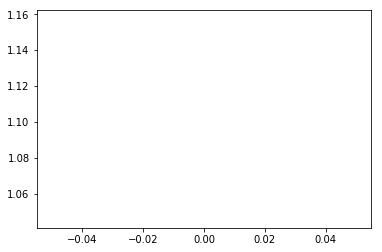

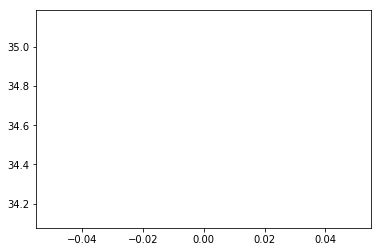

In [24]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [25]:
max(epoch_accuracies[1])

35.13513513513514

## Save model and scaler

In [27]:
torch.save(model.state_dict(), "models/passive_force_model.pt")

In [28]:
joblib.dump(scaler, "scalers/passive_force_scaler.sk")

['scalers/passive_force_scaler.sk']

## Load model and evaluate

In [29]:
model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model.load_state_dict(torch.load("models/passive_force_model.pt"))
model.eval()
model = model.cuda()

In [30]:
accuracy, predicted = evaluate(model, val_loader, return_predicted=True)

In [31]:
print(accuracy)

35.13513513513514


In [32]:
predicted = [pred.cpu() for pred in predicted]
Y_val = np.concatenate([y.cpu().numpy() for x, y in val_loader])

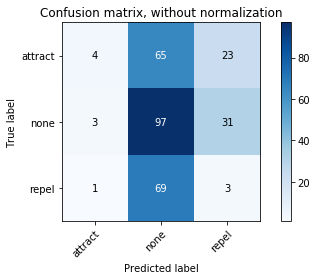

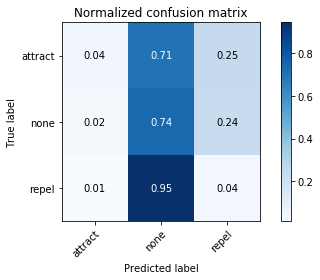

In [33]:
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=True)